In [1]:

%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from slab import Experiment, dsfit, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
from slab.dsfit import *
import os
from scipy.interpolate import griddata
from numpy import mgrid, array, zeros,abs,pi,cos,transpose, linspace
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from tempfile import TemporaryFile
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
import json
from h5py import File
from datetime import datetime
import time
from slab.datamanagement import SlabFile
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from slab.dsfit import *
from scipy.optimize import curve_fit
# import experiments.fitting as fitter
from matplotlib.colors import Normalize
import matplotlib

## Import modules from parent and multimode expts

In [3]:
import json
import os

# Get the current working directory
path = os.getcwd()
print("Current Path:", path)

# Isolate the parent directory
parent_path = os.path.dirname(path)
print("Parent Path:", parent_path)

# Add the parent path to the sys.path
sys.path.append(parent_path)

Current Path: c:\_Lib\python\multimode_expts\analysis_notebooks\temperature
Parent Path: c:\_Lib\python\multimode_expts\analysis_notebooks


In [4]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
if expts_path not in sys.path:
    sys.path.insert(0, expts_path)
    print('Path added at highest priority')

# Verify the path is added
print(sys.path)


Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\temperature', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\temperature', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\

In [5]:
from multimode_expts.fit_display import *

importing from path  C:\_Lib\python\multimode_expts\experiments\clifford_averager_program.py
imported experiments.clifford_averager_program
importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qram_protocol_timestepped.py
imported experiments.qram_protocol_timestepped
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demolution_readout
imported experiments.qubit_cavity.out_and_back
imported experiments.qubit_cavity.photo_resolved_pulse_probe
impo

In [6]:
import experiments.fitting as fitter
from numpy.linalg import inv

# Exp path

In [7]:

# print("path: ", path)

"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

data_parent =  r'H:\Shared drives\SLab\Multimode\experiment\240911'
expt_path=data_parent+'\\data1'
print('Data are extracted from', expt_path)

Data are extracted from H:\Shared drives\SLab\Multimode\experiment\240911\data1


# parity detection temperature

## Markovian model

In [8]:
from pylab import*

In [9]:
def get_evolution_matrices(attrs):
    '''Return Trnasmisson and Reflection matrices'''
    # device parameters
    trigger_period = 2.5+1 # all times in micro seconds (1us readout, 2.5 relaxation delay, )
    man_no = attrs['config']['expt']['man_no']
    parity_time = attrs['config']['device']['manipulate']['revival_time'][man_no - 1]
    print('parity_time', parity_time)
    # parity_time = 1.7366205852286094
    cav_t1 = 209 # man 1 T1
    if man_no == 2: 
        print('using man 2 T1')
        cav_t1 = 120  # man 2 T1
    qubit_t1 = 368 #493 # qubit decay time
    qubit_t2 = 148 #259 # qubit dephasing time
    # cav_n = 7.3e-4
    cav_n= 0.0
    qubit_n = 1.59e-2 # residual qubit population

    confusion_matrix = attrs['config']['device']['readout']['confusion_matrix_without_reset']
    if attrs['config']['expt']['active_reset']:
        print('using active reset confusion matrix')
        confusion_matrix = attrs['config']['device']['readout']['confusion_matrix_with_reset']
    
    g_infidelity = 1-confusion_matrix[0]#, 0.0032428050263477726, 0.016634449079255258, 0.9833655509207447#0.9889999999999999#, 0.01100000000000012, 0.024800000000000003, 0.9752##0.9900000000000003 # infidelity of qubit g readout   no active reset
    e_infidelity = 1-confusion_matrix[-1]#0.9764 # infidelity of qubit e readout   no active reset
    print('g_infidelity', g_infidelity)
    print('e_infidelity', e_infidelity)
    parity_err = 0

    P01 = cav_n * (1-exp(-trigger_period/cav_t1))
    P10 = 1-exp(-trigger_period/cav_t1)
    Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err
    Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err

    T = asarray([[(1-P01)*(1-Pge), (1-P01)*Pge, P01*Pge, P01*(1-Pge)],
        [(1-P01)*Peg, (1-P01)*(1-Peg), P01*(1-Peg), P01*Peg],
        [P10*(1-Pge), P10*Pge, (1-P10)*Pge, (1-P10)*(1-Pge)],
        [P10*Peg, P10*(1-Peg), (1-P10)*(1-Peg), (1-P10)*Peg]])

    E = 0.5*asarray([[1-g_infidelity, g_infidelity],
        [e_infidelity, 1- e_infidelity],
        [1-g_infidelity, g_infidelity],
        [e_infidelity, 1- e_infidelity]])
    
    return T, E



In [10]:
# State reconstrution algorithms for the HMM

# 
def forward(meas_seq, T, E):
    '''
    probability of possible state at i-th time step given all previous measurements
    
    N = # of states in system
    alpha[i,j] = At i'th measurement, probability of being in state j (states are product states of cavity and qubit )

    meas_seq[i] = at i'th measurement, which state was observed (g or e )
    
    '''
    num_meas = len(meas_seq)
    N = T.shape[0]
    alpha = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25] # assume flat prior
    alpha[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
    return alpha

# probability of future measurements given state at i-th time step
def backward(meas_seq, T, E):
        
    '''  
    beta[i,j] = At the j'th measurement, probability of being in state i 

    T[n,:] * E[:, meas_seq[t+1]] = Prob. that current state is n , conditioned on what the next state is and the measurement outcome of next state 
    beta[:,t+1] = Prob. state-wise of next measurement    

    '''
    N = T.shape[0]
    num_meas = len(meas_seq)

    beta = zeros((N,num_meas))
    beta[:,-1:] = 1 # all|cavity, qubit> states have equal probability at last time step

    for t in reversed(range(num_meas-1)):
        for n in range(N):
            beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])

    return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm

        '''SUmming up probabilities of being in all states after the last measurement?!?'''
        return  forward(meas_seq, T, E)[-1].sum()

# product of forward and backward probabilities
# probability of state at i-th time step given the entire measurement record
def gamma(meas_seq,T,E, ret_all=False):
    '''
    https://arxiv.org/pdf/1607.02529
    '''
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)

    product = multiply(alpha,beta.T)

    normalized_product = np.array([row/np.sum(row) for row in product])

    #obs_prob = np.array([np.sum(row) for row in product])#alpha[-1].sum()#likelihood(meas_seq, T, E) # some kind of normalization (should be 1 )
    #print(obs_prob)
    if ret_all:
        return normalized_product, alpha, beta, obs_prob

    return normalized_product 
#(multiply(alpha,beta.T) / obs_prob)

def wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = None, E=None):
    '''We will have 10^5 sequences, some of which are same; so running dict is a book-keeping tool
    to avoid recalculating gamma for the same sequence'''
    # print(running_dict)
    # print('T', T)
    # print('E', E)
    if meas_sequence not in running_dict['meas_sequence']:
        running_dict['meas_sequence'].append(meas_sequence)
        gamma_matrix = gamma(meas_sequence, T = T, E = E)
        running_dict['gamma_first_row'].append(gamma_matrix[0,:])
    idx = running_dict['meas_sequence'].index(meas_sequence)
    # print('idx', idx)
    # print(len(running_dict['gamma_first_row']))
    
    return running_dict['gamma_first_row'][idx], running_dict



# returns the most likely state seqeunce given the measurement record
# not used in this work
def viterbi(meas_seq, T, E):
    # returns the most likely state sequence given observed sequence
    # using the Viterbi algorithm
    num_meas = len(meas_seq)
    N = T.shape[0]
    delta = zeros((num_meas, N))
    psi = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25]
    delta[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        for j in range(N):
            delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
            psi[t,j] = argmax(delta[t-1]*T[:,j])

    # backtrack
    states = zeros(num_meas, dtype=int32)
    states[num_meas-1] = argmax(delta[num_meas-1])
    for t in range(num_meas-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

In [11]:
def compute_threshold_counts(meas_sequence_list, threshold_list, running_dict = {'meas_sequence': [], 'gamma_first_row': []}, T = None, E = None):
    '''Given a list of measurement sequences, compute the number of times the likelihood ratio exceeds a threshold
    '''
    threshold_counts = [0 for i in range(len(threshold_list))]
    for i in tqdm(range(len(meas_sequence_list)), desc="Processing"):

        if i % 10000 == 0:
            # reset the running_dict every 10000 sequences
            running_dict = {'meas_sequence': [], 'gamma_first_row': []}

        # print(meas_sequence_list[i])
        meas_sequence = meas_sequence_list[i]
        # print(meas_sequence)
        gamma_first_row, running_dict = wrapper_gamma(meas_sequence, running_dict, T=T, E=E)

        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        likelihood_ratio = P1/P0  

        for jdx, threshold in enumerate(threshold_list):
            # Compare the probabilities of the two models to obtain a likelihood ratio
            if likelihood_ratio > threshold:
                threshold_counts[jdx] += 1
    return threshold_counts, running_dict   

def plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, threshold_list, frequency_list, mode_labels, 
                                        meas_number = 1e5):
    ''' Plot the thermal photon population and M1 temperature as a function of threshold'''
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    for mode_idx, threshold_counts in enumerate(threshold_counts_list):
        frequency = frequency_list[mode_idx]
        mode_label = mode_labels[mode_idx]
        
        dark_counts = np.array(threshold_counts) / (meas_number)#20000

        thermal_photon_population = []
        for i in range(len(dark_counts)):
            thermal_photon_population.append(dark_counts[i] / efficiency_list[i])

        now = np.array(thermal_photon_population) / 2
        tempr = []
        for i in range(len(now)):
            tempr.append(48 * frequency / (np.log(1 + 1 / now[i])))

        # Plot thermal photon population
        ax1.plot(threshold_list, thermal_photon_population, 'o-', label=mode_label)
        

        # Plot M1 Temperature
        ax2.plot(threshold_list, tempr, 'o-', label=mode_label)
        
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Thermal photon population')
    ax1.set_title('Dark photon')

    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('M1 Temperature (mK)')
    ax2.set_title('M1 Temperature')

        #plt.suptitle(f'{mode_label} Thermal Photon Population Temperature vs. Threshold')

        # Adjust layout and display the plots
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Collect all the data

In [185]:
columns = ['file_name', 'mode', 'T', 'E', 'threshold_list', 'counts_list', 'n_reps', 'man_no_for_parity', 'reset', 'single_photon']
df = pd.DataFrame(columns=columns)

modes = ['M1', 'M1', 'M1-S1', 'M1-S2', 'M1-S3', 'M1-S4', 'M1-S5', 'M1-S6', 'M1-S7', 'M1-D1', 'M1-C','M2', 'M2-D2'] * 2 + ['M2', 'M2'] * 2
# modes = ['M1', 'M2', 'M1', 'M1-S1', 'M1-S6'] * 2 
# modes =  #['M1', 'M1', 'M1-S1',  'M1-S7', 'M1-D1', 'M1-C', 'M2' ] * 2
file_no_start = 163
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]

for idx, mode in enumerate(modes): 
    # add row to dataframe
    file_no = int(file_no_start + idx)
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')
    reset = attrs['config']['expt']['active_reset']

    prepulse_len = 0
    if attrs['config']['expt']['prepulse']:
        prepulse_len = len(attrs['config']['expt']['pre_sweep_pulse'][0])

    single_photon = False
    if prepulse_len >1: 
        single_photon = True
    file_no = int(file_no_start + idx)
    T, E = get_evolution_matrices(attrs)

    df.loc[idx] = [f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5', mode, T, E, full_threshold_list, [0 for i in range(len(full_threshold_list))], 0, attrs['config']['expt']['man_no'], reset, single_photon]   
    print(f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')

df

parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00163_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00164_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00165_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00166_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00167_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043
00168_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.

file_name   mode  \
0   00163_cavity_temperature_sweep_parity_with_wit...     M1   
1   00164_cavity_temperature_sweep_parity_with_wit...     M1   
2   00165_cavity_temperature_sweep_parity_with_wit...  M1-S1   
3   00166_cavity_temperature_sweep_parity_with_wit...  M1-S2   
4   00167_cavity_temperature_sweep_parity_with_wit...  M1-S3   
5   00168_cavity_temperature_sweep_parity_with_wit...  M1-S4   
6   00169_cavity_temperature_sweep_parity_with_wit...  M1-S5   
7   00170_cavity_temperature_sweep_parity_with_wit...  M1-S6   
8   00171_cavity_temperature_sweep_parity_with_wit...  M1-S7   
9   00172_cavity_temperature_sweep_parity_with_wit...  M1-D1   
10  00173_cavity_temperature_sweep_parity_with_wit...   M1-C   
11  00174_cavity_temperature_sweep_parity_with_wit...     M2   
12  00175_cavity_temperature_sweep_parity_with_wit...  M2-D2   
13  00176_cavity_temperature_sweep_parity_with_wit...     M1   
14  00177_cavity_temperature_sweep_parity_with_wit...     M1   
15  00178_cavity_temperature_sweep_parity_with_wit...  M1-S1   
16  00179_cavity_temperature_sweep_parity_with_wit...  M1-S2   
17  00180_cavity_temperature_sweep_parity_with_wit...  M1-S3   
18  00181_cavity_temperature_sweep_parity_with_wit...  M1-S4   
19  00182_cavity_temperature_sweep_parity_with_wit...  M1-S5   
20  00183_cavity_temperature_sweep_parity_with_wit...  M1-S6   
21  00184_cavity_temperature_sweep_parity_with_wit...  M1-S7   
22  00185_cavity_temperature_sweep_parity_with_wit...  M1-D1   
23  00186_cavity_temperature_sweep_parity_with_wit...   M1-C   
24  00187_cavity_temperature_sweep_parity_with_wit...     M2   
25  00188_cavity_temperature_sweep_parity_with_wit...  M2-D2   
26  00189_cavity_temperature_sweep_parity_with_wit...     M2   
27  00190_cavity_temperature_sweep_parity_with_wit...     M2   
28  00191_cavity_temperature_sweep_parity_with_wit...     M2   
29  00192_cavity_temperature_sweep_parity_with_wit...     M2   

                                                    T  \
0   [[0.9885400581248439, 0.011459941875156051, 0....   
1   [[0.9885400581248439, 0.011459941875156051, 0....   
2   [[0.9885400581248439, 0.011459941875156051, 0....   
3   [[0.9885400581248439, 0.011459941875156051, 0....   
4   [[0.9885400581248439, 0.011459941875156051, 0....   
5   [[0.9885400581248439, 0.011459941875156051, 0....   
6   [[0.9885400581248439, 0.011459941875156051, 0....   
7   [[0.9885400581248439, 0.011459941875156051, 0....   
8   [[0.9885400581248439, 0.011459941875156051, 0....   
9   [[0.9885400581248439, 0.011459941875156051, 0....   
10  [[0.9885400581248439, 0.011459941875156051, 0....   
11  [[0.9885400581248439, 0.011459941875156051, 0....   
12  [[0.9885400581248439, 0.011459941875156051, 0....   
13  [[0.9885400581248439, 0.011459941875156051, 0....   
14  [[0.9885400581248439, 0.011459941875156051, 0....   
15  [[0.9885400581248439, 0.011459941875156051, 0....   
16  [[0.9885400581248439, 0.011459941875156051, 0....   
17  [[0.9885400581248439, 0.011459941875156051, 0....   
18  [[0.9885400581248439, 0.011459941875156051, 0....   
19  [[0.9885400581248439, 0.011459941875156051, 0....   
20  [[0.9885400581248439, 0.011459941875156051, 0....   
21  [[0.9885400581248439, 0.011459941875156051, 0....   
22  [[0.9885400581248439, 0.011459941875156051, 0....   
23  [[0.9885400581248439, 0.011459941875156051, 0....   
24  [[0.9885400581248439, 0.011459941875156051, 0....   
25  [[0.9885400581248439, 0.011459941875156051, 0....   
26  [[0.9885400581248439, 0.011459941875156051, 0....   
27  [[0.9885400581248439, 0.011459941875156051, 0....   
28  [[0.9885400581248439, 0.011459941875156051, 0....   
29  [[0.9885400581248439, 0.011459941875156051, 0....   

                                                    E  \
0   [[0.49557499999999993, 0.004425000000000068], ...   
1   [[0.49557499999999993, 0.004425000000000068], ...   
2   [[0.49557499999999993, 0.004425000000000068], ...   
3   [[0.49557499999999993, 0.004425000000000068], ...   
4   [[

In [186]:
# Save the dataframe '
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_corrected1211.csv'
file_path = os.path.join(folder, file_name)

# Ensure the directory exists
os.makedirs(folder, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")


DataFrame saved to H:\Shared drives\SLab\Multimode\experiment\240911\RAM_paper_results\datasets\Cavity_Temp_Parity_corrected1211.csv


### Fix M1 single photon calib

In [111]:
df.loc[7, 'file_name'] = '00022_ParityTempExperiment.h5'
df_idx = 7
file_name = df.loc[df_idx, 'file_name']
mode = df.loc[df_idx, 'mode']
T = df.loc[df_idx, 'T']
E = df.loc[df_idx, 'E']
threshold_list = ast.literal_eval(df.loc[df_idx, 'threshold_list'])

print(f'Processing {file_name} for {mode} mode')

temp_data, attrs = prev_data(expt_path, file_name)
readout_threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
active_reset = attrs['config']['expt']['active_reset']
if active_reset:
    readouts_per_rep +=3

aa, bb = parity_temp_display(temp_data, attrs, active_reset=active_reset, threshold = readout_threshold, readouts_per_rep= readouts_per_rep)

T, E = get_evolution_matrices(attrs)
threshold_counts, m1_running_dict = compute_threshold_counts(bb, threshold_list, T = T, E = E)#, m1_running_dict)
df['counts_list'][df_idx] = threshold_counts
df['n_reps'][df_idx] = len(bb)
print(f'{mode} done')
df.to_csv(file_path, index=False)

Processing 00022_ParityTempExperiment.h5 for M1 mode
calling parity post select modified
size of ilist 19340
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 19340/19340 [00:41<00:00, 468.80it/s]

M1 done



C:\Users\26049\AppData\Local\Temp\ipykernel_10340\3910831488.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['counts_list'][df_idx] = threshold_counts
C:\Users\26049\AppData\Local\Temp\ipykernel_10340\3910831488.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_reps'][df_idx] = len(bb)


In [113]:
df.loc[df_idx, 'single_photon'] = True

### Read CSV

In [187]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_corrected1211.csv'
file_path = os.path.join(folder, file_name)
df =pd.read_csv(file_path)

### Filling up the df created on eesh local

In [197]:
import ast 

for df_idx in range(0, len(df) , 1):
    file_name = df.loc[df_idx, 'file_name']
    mode = df.loc[df_idx, 'mode']
    T = df.loc[df_idx, 'T']
    E = df.loc[df_idx, 'E']
    threshold_list = ast.literal_eval(df.loc[df_idx, 'threshold_list'])

    print(f'Processing {file_name} for {mode} mode')

    temp_data, attrs = prev_data(expt_path, file_name)
    readout_threshold = attrs['config']['device']['readout']['threshold'][0]
    readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
    active_reset = attrs['config']['expt']['active_reset']
    if active_reset:
        readouts_per_rep +=3

    aa, bb = parity_temp_display(temp_data, attrs, active_reset=active_reset, threshold = readout_threshold, readouts_per_rep= readouts_per_rep,
                                 consistent_parity_check_bool=True, consistent_cutoff=3)

    T, E = get_evolution_matrices(attrs)
    threshold_counts, m1_running_dict = compute_threshold_counts(bb, threshold_list, T = T, E = E)#, m1_running_dict)
    df['counts_list'][df_idx] = threshold_counts
    df['n_reps'][df_idx] = len(bb)
    print(f'{mode} done')
    df.to_csv(file_path, index=False)




Processing 00163_cavity_temperature_sweep_parity_with_without_reset.h5 for M1 mode
len of state string list before consistency check 100000
len of state string list after consistency check 91122
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 91122/91122 [03:11<00:00, 475.67it/s]
C:\Users\26049\AppData\Local\Temp\ipykernel_10340\848620685.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['counts_list'][df_idx] = threshold_counts
C:\Users\26049\AppData\Local\Temp\ipykernel_10340\848620685.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_reps'][df_idx] = len(bb)


M1 done
Processing 00164_cavity_temperature_sweep_parity_with_without_reset.h5 for M1 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98559
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98559/98559 [01:16<00:00, 1294.06it/s]


M1 done
Processing 00165_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S1 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98600
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98600/98600 [01:17<00:00, 1278.73it/s]


M1-S1 done
Processing 00166_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S2 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98620
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98620/98620 [01:14<00:00, 1330.58it/s]


M1-S2 done
Processing 00167_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S3 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98594
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98594/98594 [01:15<00:00, 1313.73it/s]


M1-S3 done
Processing 00168_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S4 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98622
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98622/98622 [01:15<00:00, 1311.05it/s]


M1-S4 done
Processing 00169_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S5 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98560
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98560/98560 [01:11<00:00, 1368.93it/s]


M1-S5 done
Processing 00170_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S6 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98402
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98402/98402 [01:16<00:00, 1291.91it/s]


M1-S6 done
Processing 00171_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S7 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98506
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98506/98506 [01:17<00:00, 1270.74it/s]


M1-S7 done
Processing 00172_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-D1 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98480
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98480/98480 [01:17<00:00, 1275.93it/s]


M1-D1 done
Processing 00173_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-C mode
len of state string list before consistency check 100000
len of state string list after consistency check 98461
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98461/98461 [01:19<00:00, 1243.44it/s]


M1-C done
Processing 00174_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98507
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98507/98507 [01:14<00:00, 1327.76it/s]


M2 done
Processing 00175_cavity_temperature_sweep_parity_with_without_reset.h5 for M2-D2 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98475
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98475/98475 [01:15<00:00, 1296.11it/s]


M2-D2 done
Processing 00176_cavity_temperature_sweep_parity_with_without_reset.h5 for M1 mode
calling parity post select modified
size of ilist 99047
len of state string list before consistency check 99047
len of state string list after consistency check 90859
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 90859/90859 [02:59<00:00, 506.40it/s]


M1 done
Processing 00177_cavity_temperature_sweep_parity_with_without_reset.h5 for M1 mode
calling parity post select modified
size of ilist 99031
len of state string list before consistency check 99031
len of state string list after consistency check 97537
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97537/97537 [01:12<00:00, 1354.19it/s]


M1 done
Processing 00178_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S1 mode
calling parity post select modified
size of ilist 99095
len of state string list before consistency check 99095
len of state string list after consistency check 97456
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97456/97456 [01:11<00:00, 1355.89it/s]


M1-S1 done
Processing 00179_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S2 mode
calling parity post select modified
size of ilist 99146
len of state string list before consistency check 99146
len of state string list after consistency check 97524
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97524/97524 [01:10<00:00, 1378.74it/s]


M1-S2 done
Processing 00180_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S3 mode
calling parity post select modified
size of ilist 99093
len of state string list before consistency check 99093
len of state string list after consistency check 97460
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97460/97460 [01:09<00:00, 1411.76it/s]


M1-S3 done
Processing 00181_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S4 mode
calling parity post select modified
size of ilist 99163
len of state string list before consistency check 99163
len of state string list after consistency check 97516
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97516/97516 [01:10<00:00, 1389.99it/s]


M1-S4 done
Processing 00182_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S5 mode
calling parity post select modified
size of ilist 99017
len of state string list before consistency check 99017
len of state string list after consistency check 97371
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97371/97371 [01:13<00:00, 1319.83it/s]


M1-S5 done
Processing 00183_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S6 mode
calling parity post select modified
size of ilist 99134
len of state string list before consistency check 99134
len of state string list after consistency check 97261
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97261/97261 [01:14<00:00, 1308.18it/s]


M1-S6 done
Processing 00184_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S7 mode
calling parity post select modified
size of ilist 99090
len of state string list before consistency check 99090
len of state string list after consistency check 97448
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97448/97448 [01:11<00:00, 1363.02it/s]


M1-S7 done
Processing 00185_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-D1 mode
calling parity post select modified
size of ilist 99137
len of state string list before consistency check 99137
len of state string list after consistency check 97632
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97632/97632 [01:08<00:00, 1425.44it/s]


M1-D1 done
Processing 00186_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-C mode
calling parity post select modified
size of ilist 99075
len of state string list before consistency check 99075
len of state string list after consistency check 97258
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97258/97258 [01:13<00:00, 1327.26it/s]


M1-C done
Processing 00187_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
calling parity post select modified
size of ilist 99127
len of state string list before consistency check 99127
len of state string list after consistency check 97609
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97609/97609 [01:07<00:00, 1444.90it/s]


M2 done
Processing 00188_cavity_temperature_sweep_parity_with_without_reset.h5 for M2-D2 mode
calling parity post select modified
size of ilist 99140
len of state string list before consistency check 99140
len of state string list after consistency check 97644
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


Processing: 100%|██████████| 97644/97644 [01:09<00:00, 1408.54it/s]


M2-D2 done
Processing 00189_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
len of state string list before consistency check 100000
len of state string list after consistency check 89915
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 89915/89915 [02:35<00:00, 578.51it/s]


M2 done
Processing 00190_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
len of state string list before consistency check 100000
len of state string list after consistency check 98210
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


Processing: 100%|██████████| 98210/98210 [01:16<00:00, 1277.22it/s]


M2 done
Processing 00191_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
calling parity post select modified
size of ilist 98922
len of state string list before consistency check 98922
len of state string list after consistency check 88689
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0035469977197875036
e_infidelity 0.013768302080657602


Processing: 100%|██████████| 88689/88689 [02:41<00:00, 550.83it/s]


M2 done
Processing 00192_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
calling parity post select modified
size of ilist 98839
len of state string list before consistency check 98839
len of state string list after consistency check 96982
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0035469977197875036
e_infidelity 0.013768302080657602


Processing: 100%|██████████| 96982/96982 [01:15<00:00, 1276.62it/s]

M2 done


In [198]:
df

file_name   mode  \
0   00163_cavity_temperature_sweep_parity_with_wit...     M1   
1   00164_cavity_temperature_sweep_parity_with_wit...     M1   
2   00165_cavity_temperature_sweep_parity_with_wit...  M1-S1   
3   00166_cavity_temperature_sweep_parity_with_wit...  M1-S2   
4   00167_cavity_temperature_sweep_parity_with_wit...  M1-S3   
5   00168_cavity_temperature_sweep_parity_with_wit...  M1-S4   
6   00169_cavity_temperature_sweep_parity_with_wit...  M1-S5   
7   00170_cavity_temperature_sweep_parity_with_wit...  M1-S6   
8   00171_cavity_temperature_sweep_parity_with_wit...  M1-S7   
9   00172_cavity_temperature_sweep_parity_with_wit...  M1-D1   
10  00173_cavity_temperature_sweep_parity_with_wit...   M1-C   
11  00174_cavity_temperature_sweep_parity_with_wit...     M2   
12  00175_cavity_temperature_sweep_parity_with_wit...  M2-D2   
13  00176_cavity_temperature_sweep_parity_with_wit...     M1   
14  00177_cavity_temperature_sweep_parity_with_wit...     M1   
15  00178_cavity_temperature_sweep_parity_with_wit...  M1-S1   
16  00179_cavity_temperature_sweep_parity_with_wit...  M1-S2   
17  00180_cavity_temperature_sweep_parity_with_wit...  M1-S3   
18  00181_cavity_temperature_sweep_parity_with_wit...  M1-S4   
19  00182_cavity_temperature_sweep_parity_with_wit...  M1-S5   
20  00183_cavity_temperature_sweep_parity_with_wit...  M1-S6   
21  00184_cavity_temperature_sweep_parity_with_wit...  M1-S7   
22  00185_cavity_temperature_sweep_parity_with_wit...  M1-D1   
23  00186_cavity_temperature_sweep_parity_with_wit...   M1-C   
24  00187_cavity_temperature_sweep_parity_with_wit...     M2   
25  00188_cavity_temperature_sweep_parity_with_wit...  M2-D2   
26  00189_cavity_temperature_sweep_parity_with_wit...     M2   
27  00190_cavity_temperature_sweep_parity_with_wit...     M2   
28  00191_cavity_temperature_sweep_parity_with_wit...     M2   
29  00192_cavity_temperature_sweep_parity_with_wit...     M2   

                                                    T  \
0   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
1   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
2   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
3   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
4   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
5   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
6   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
7   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
8   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
9   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
10  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
11  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
12  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
13  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
14  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
15  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
16  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
17  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
18  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
19  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
20  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
21  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
22  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
23  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
24  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
25  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
26  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
27  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
28  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
29  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   

                                                    E  \
0   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
1   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
2   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
3   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
4   [[

In [105]:
temp_data, attrs = prev_data(expt_path, '00156_cavity_temperature_sweep_parity_with_without_reset.h5')
attrs['config']['device']['readout']['threshold'][0]

-75.0

In [106]:
attrs['config']['device']['readout']

{'trig_offset': [450],
 'frequency': [748.8],
 'gain': [700],
 'phase': [31],
 'threshold': [-75.0],
 'threshold_list': [-75.0],
 'man1_drive_list': [0],
 'man2_drive_list': [0],
 'readout_length': [1.0],
 'relax_delay': [100],
 'confusion_matrix_with_reset': [0.9980303030303033,
  0.0019696969696967326,
  0.01665124884366328,
  0.9833487511563367],
 'confusion_matrix_without_reset': [0.9911499999999999,
  0.008850000000000136,
  0.023799999999999998,
  0.9762]}

# Looking at all data

#### Rough Temperatures

In [12]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_corrected1211.csv'
file_path = os.path.join(folder, file_name)
df =pd.read_csv(file_path)

In [34]:
folder

'H:\\Shared drives\\SLab\\Multimode\\experiment\\240911\\RAM_paper_results\\datasets'

In [13]:
df

file_name   mode  \
0   00163_cavity_temperature_sweep_parity_with_wit...     M1   
1   00164_cavity_temperature_sweep_parity_with_wit...     M1   
2   00165_cavity_temperature_sweep_parity_with_wit...  M1-S1   
3   00166_cavity_temperature_sweep_parity_with_wit...  M1-S2   
4   00167_cavity_temperature_sweep_parity_with_wit...  M1-S3   
5   00168_cavity_temperature_sweep_parity_with_wit...  M1-S4   
6   00169_cavity_temperature_sweep_parity_with_wit...  M1-S5   
7   00170_cavity_temperature_sweep_parity_with_wit...  M1-S6   
8   00171_cavity_temperature_sweep_parity_with_wit...  M1-S7   
9   00172_cavity_temperature_sweep_parity_with_wit...  M1-D1   
10  00173_cavity_temperature_sweep_parity_with_wit...   M1-C   
11  00174_cavity_temperature_sweep_parity_with_wit...     M2   
12  00175_cavity_temperature_sweep_parity_with_wit...  M2-D2   
13  00176_cavity_temperature_sweep_parity_with_wit...     M1   
14  00177_cavity_temperature_sweep_parity_with_wit...     M1   
15  00178_cavity_temperature_sweep_parity_with_wit...  M1-S1   
16  00179_cavity_temperature_sweep_parity_with_wit...  M1-S2   
17  00180_cavity_temperature_sweep_parity_with_wit...  M1-S3   
18  00181_cavity_temperature_sweep_parity_with_wit...  M1-S4   
19  00182_cavity_temperature_sweep_parity_with_wit...  M1-S5   
20  00183_cavity_temperature_sweep_parity_with_wit...  M1-S6   
21  00184_cavity_temperature_sweep_parity_with_wit...  M1-S7   
22  00185_cavity_temperature_sweep_parity_with_wit...  M1-D1   
23  00186_cavity_temperature_sweep_parity_with_wit...   M1-C   
24  00187_cavity_temperature_sweep_parity_with_wit...     M2   
25  00188_cavity_temperature_sweep_parity_with_wit...  M2-D2   
26  00189_cavity_temperature_sweep_parity_with_wit...     M2   
27  00190_cavity_temperature_sweep_parity_with_wit...     M2   
28  00191_cavity_temperature_sweep_parity_with_wit...     M2   
29  00192_cavity_temperature_sweep_parity_with_wit...     M2   

                                                    T  \
0   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
1   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
2   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
3   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
4   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
5   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
6   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
7   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
8   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
9   [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
10  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
11  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
12  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
13  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
14  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
15  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
16  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
17  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
18  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
19  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
20  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
21  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
22  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
23  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
24  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
25  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
26  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
27  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
28  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
29  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   

                                                    E  \
0   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
1   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
2   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
3   [[0.495575 0.004425]\n [0.0119   0.4881  ]\n [...   
4   [[

In [30]:
import ast 
def calculate_efficiencies_and_errs(df):

    '''Assuming df to only contain 1 row '''
    
    file_name = df['file_name'][0]
    temp_data, attrs = prev_data(expt_path, file_name)
    n = df['n_reps'][0]
    threshold_counts = df['counts_list'][0]
    #convert threshold counts which is an array inside string to a list
    threshold_counts = ast.literal_eval(threshold_counts)
    efficiency_list = np.array(threshold_counts) / n
    efficiency_list_err = np.sqrt(efficiency_list *(1 - efficiency_list) / n) # sqrt(p(1-p)/n)
    return efficiency_list, efficiency_list_err

def plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, threshold_list, frequency_list, mode_labels, 
                                        meas_number = None, eff_meas_number = 2e5, supertitle = ''):
    ''' Plot the thermal photon population and M1 temperature as a function of threshold
    
    meas_number is a list: how many repetitions of parity temp experiment (differs due to active reset)'''
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    efficiency_list_err = np.sqrt(efficiency_list * (1 - efficiency_list) / eff_meas_number) # sqrt(p(1-p)/n)
    ax3.errorbar(threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
    
    
    for mode_idx, threshold_counts in enumerate(threshold_counts_list):
        frequency = frequency_list[mode_idx]
        mode_label = mode_labels[mode_idx]
        
        dark_counts = np.array(threshold_counts) / (meas_number[mode_idx])#20000
        dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / meas_number[mode_idx]) # sqrt(p(1-p)/n)



        

        thermal_photon_population = []
        thermal_photon_population_err = []
        for i in range(len(dark_counts)):
            thermal_photon_population.append(dark_counts[i] / efficiency_list[i])
            ratio = dark_counts[i] / efficiency_list[i]
            # if mode_label == 'M1-S6': 
            #     print('dark', dark_counts[i])
            #     print('ratio', ratio)
            #     print('freq', frequency)
            err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
            thermal_photon_population_err.append(err)

        now = np.array(thermal_photon_population) / 2
        now_err = np.array(thermal_photon_population_err) / 2
        tempr = []
        tempr_err = []
        for i in range(len(now)):
            temp_single_val = 48 * frequency / (np.log(1 + 1 / now[i]))
            if mode_label == 'M1-S6': 
                # print('dark', dark_counts[i])
                # print('ratio', ratio)
                print('dark_count ', now[i])
                print('temp', temp_single_val)
                print('freq', frequency)
            tempr.append(temp_single_val)
            temp_err = np.abs(temp_single_val * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
            tempr_err.append(temp_err)


        # Plot thermal photon population
        #ax1.plot(threshold_list, thermal_photon_population, 'o-', label=mode_label)
        ax1.errorbar(threshold_list, thermal_photon_population, yerr=thermal_photon_population_err, fmt='o-', label=mode_label, capsize=5)
        

        # Plot M1 Temperature
        # ax2.plot(threshold_list, tempr, 'o-', label=mode_label)
        # print(tempr_err)
        # print(tempr)
        # print(mode_label)
        ax2.errorbar(threshold_list, tempr, yerr=tempr_err, fmt='o-', label=mode_label, capsize=5)
        
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Dark photons ($\delta/\eta$)')
    ax1.set_title('Dark photon')
    ax1.legend()

    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Temperature (mK)')
    ax2.set_title('M1 Temperature')
    ax2.legend()

    ax3.set_xscale('log')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Efficiency($\eta$)')

    plt.suptitle(supertitle)

        # Adjust layout and display the plots
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_thermal_photon_and_temperature_noeff(threshold_counts_list, efficiency_list, threshold_list, frequency_list, mode_labels, 
                                        meas_number = None, eff_meas_number = 2e5, supertitle = ''):
    ''' Plot the thermal photon population and M1 temperature as a function of threshold
    
    meas_number is a list: how many repetitions of parity temp experiment (differs due to active reset)'''
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    efficiency_list_err = np.sqrt(efficiency_list * (1 - efficiency_list) / eff_meas_number) # sqrt(p(1-p)/n)
    #ax3.errorbar(threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
    
    
    for mode_idx, threshold_counts in enumerate(threshold_counts_list):
        frequency = frequency_list[mode_idx]
        mode_label = mode_labels[mode_idx]
        
        dark_counts = np.array(threshold_counts) / (meas_number[mode_idx])#20000
        dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / meas_number[mode_idx]) # sqrt(p(1-p)/n)



        

        thermal_photon_population = []
        thermal_photon_population_err = []
        for i in range(len(dark_counts)):
            thermal_photon_population.append(dark_counts[i] / efficiency_list[i])
            ratio = dark_counts[i] / efficiency_list[i]
            # if mode_label == 'M1-S6': 
            #     print('dark', dark_counts[i])
            #     print('ratio', ratio)
            #     print('freq', frequency)
            err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
            thermal_photon_population_err.append(err)

        now = np.array(thermal_photon_population) / 2
        now_err = np.array(thermal_photon_population_err) / 2
        tempr = []
        tempr_err = []
        for i in range(len(now)):
            temp_single_val = 48 * frequency / (np.log(1 + 1 / now[i]))
            if mode_label == 'M1-S6': 
                # print('dark', dark_counts[i])
                # print('ratio', ratio)
                print('dark_count ', now[i])
                print('temp', temp_single_val)
                print('freq', frequency)
            tempr.append(temp_single_val)
            temp_err = np.abs(temp_single_val * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
            tempr_err.append(temp_err)


        # Plot thermal photon population
        #ax1.plot(threshold_list, thermal_photon_population, 'o-', label=mode_label)
        ax1.errorbar(threshold_list, thermal_photon_population, yerr=thermal_photon_population_err, fmt='o-', label=mode_label, capsize=5)
        

        # Plot M1 Temperature
        # ax2.plot(threshold_list, tempr, 'o-', label=mode_label)
        # print(tempr_err)
        # print(tempr)
        # print(mode_label)
        ax2.errorbar(threshold_list, tempr, yerr=tempr_err, fmt='o-', label=mode_label, capsize=5)
        
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Dark photons ($\delta/\eta$)')
    ax1.set_title('Dark photon')
    ax1.legend()

    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Temperature (mK)')
    ax2.set_title('M1 Temperature')
    ax2.legend()

    # ax3.set_xscale('log')
    # ax3.set_xlabel('Threshold')
    # ax3.set_ylabel('Efficiency($\eta$)')

    plt.suptitle(supertitle)

        # Adjust layout and display the plots
    plt.legend()
    plt.tight_layout()
    plt.show()
    return fig 

def plot_efficiency( efficiency_list, threshold_list,  eff_meas_number = 2e5):
    ''' Plot the thermal photon population and M1 temperature as a function of threshold
    
    meas_number is a list: how many repetitions of parity temp experiment (differs due to active reset)'''
    
    # Create subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

    efficiency_list_err = np.sqrt(efficiency_list * (1 - efficiency_list) / eff_meas_number) # sqrt(p(1-p)/n)
    ax1.errorbar(threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
    
    

    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Efficiency($\eta$)')
        # Adjust layout and display the plots
    plt.legend()
    plt.tight_layout()
    plt.show()
    return fig


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dark_count  0.005365565353886593
temp 57.136375852242075
freq 6.22918
dark_count  0.005374309596460312
temp 57.154065324159355
freq 6.22918
dark_count  0.005207767723824715
temp 56.81400406801703
freq 6.22918
dark_count  0.005239452110491772
temp 56.879219463634804
freq 6.22918
dark_count  0.005104305319674572
temp 56.599299108015785
freq 6.22918
dark_count  0.005054700603715398
temp 56.49538925211464
freq 6.22918
dark_count  0.004973719878277139
temp 56.324366609710864
freq 6.22918
dark_count  0.004791943879461974
temp 55.93397575088652
freq 6.22918
dark_count  0.004792210388157995
temp 55.93455490632793
freq 6.22918
dark_count  0.004765047926202453
temp 55.87542251031837
freq 6.22918
dark_count  0.004760484704723184
temp 55.86546751832961
freq 6.22918
dark_count  0.004770816492422829
temp 55.887998418450145
freq 6.22918
dark_count  0.004765776078097831
temp 55.87701046724866
freq 6.22918
dark_count  0.004823947176533916
temp 56.003377677661085
freq 6.22918
dark_count  0.0048357045493

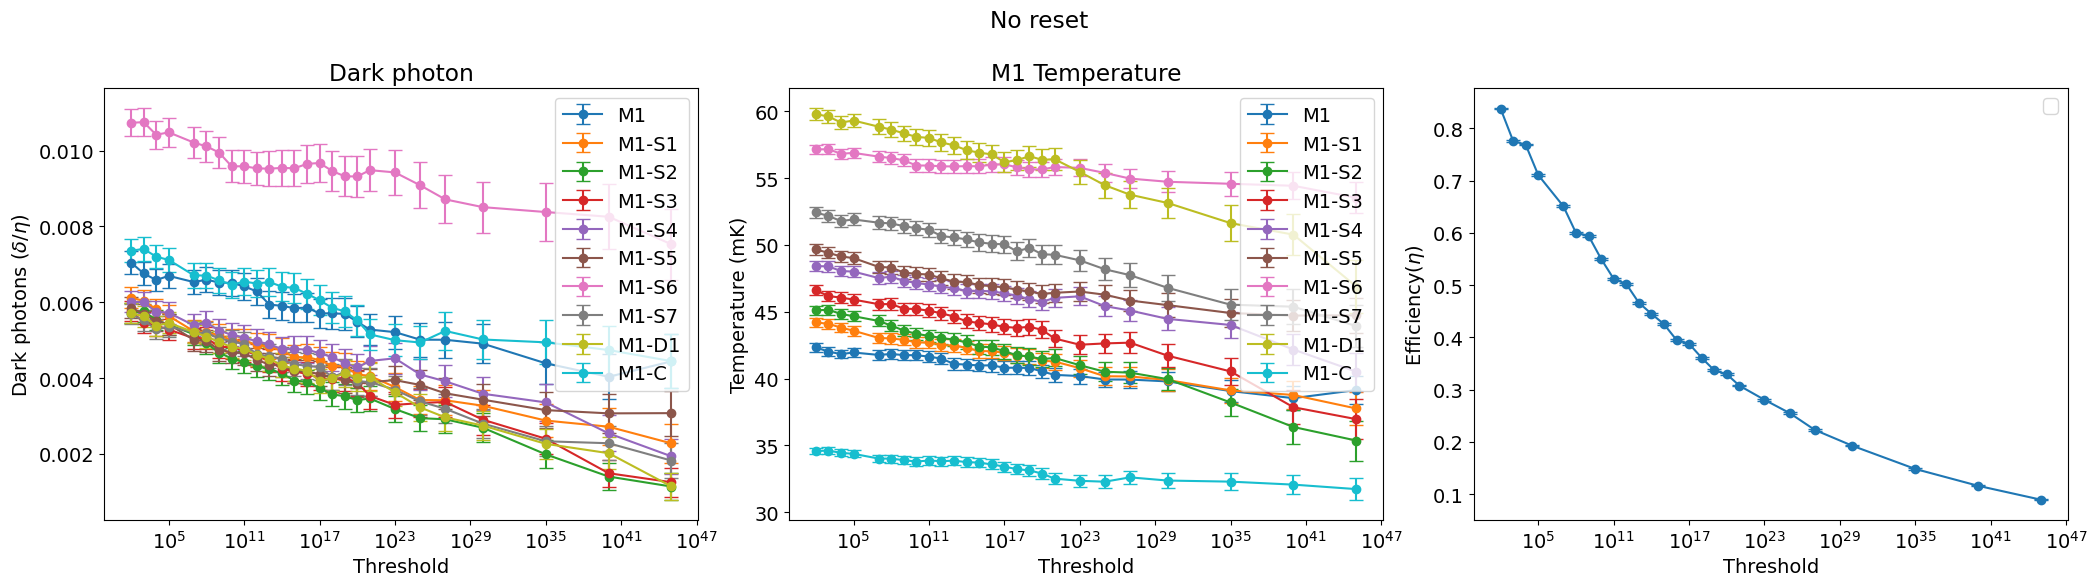

In [17]:
reset = False
man_no_for_parity = 1
single_photon = False
end_idx=-1 # for thresholds
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925, 2313.3, -944]) * 1e-3)
num_modes = len(frequencies)
# select the rows with the correct reset and man_no_for_parity
df_modes = df[(df['reset'] == reset) & (df['man_no_for_parity'] == man_no_for_parity) & (df['single_photon'] == single_photon)]

df_efficiency = df[(df['reset'] == reset) & (df['man_no_for_parity'] == man_no_for_parity) & (df['single_photon'] == True)]

#caculate efficiences
efficiency_list, efficiency_list_err = calculate_efficiencies_and_errs(df_efficiency)

# calculate dark counts for all modes
threshold_counts_list = [ ast.literal_eval(counts_list)[:end_idx] for counts_list in df_modes['counts_list']][:num_modes]#[:1]
full_threshold_list = ast.literal_eval(df.loc[0, 'threshold_list'])[:end_idx]
mode_labels = df_modes['mode'].to_list()
  


# get meas_num 
file_name =df_efficiency['file_name'][0]
temp_data, attrs = prev_data(expt_path, file_name)
meas_number = [ reps for reps in df_modes['n_reps']] #attrs['config']['expt']['reps']
eff_meas_number = df_efficiency.loc[0, 'n_reps']
plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list[:end_idx], full_threshold_list, frequencies, mode_labels, meas_number,
                                    eff_meas_number=eff_meas_number,
                                    supertitle ='No reset')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


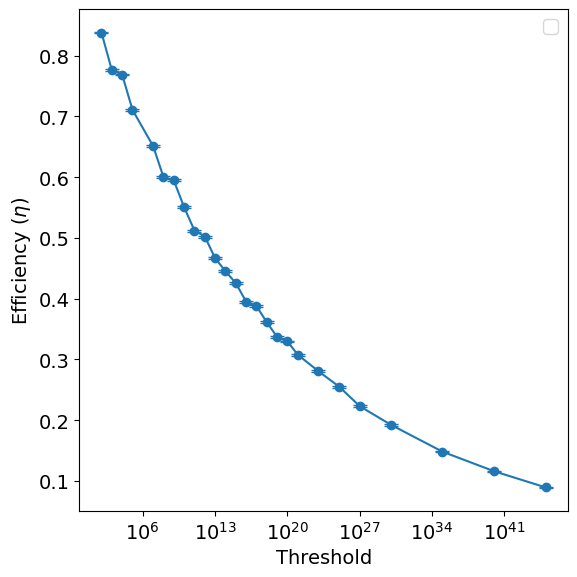

In [28]:
fig = plot_efficiency(efficiency_list[:end_idx], full_threshold_list, 
                                    eff_meas_number=eff_meas_number)
fig.savefig('figures/efficiency_no_reset_M1_250115.png', dpi=300)

dark_count  0.005365565353886593
temp 57.136375852242075
freq 6.22918
dark_count  0.005374309596460312
temp 57.154065324159355
freq 6.22918
dark_count  0.005207767723824715
temp 56.81400406801703
freq 6.22918
dark_count  0.005239452110491772
temp 56.879219463634804
freq 6.22918
dark_count  0.005104305319674572
temp 56.599299108015785
freq 6.22918
dark_count  0.005054700603715398
temp 56.49538925211464
freq 6.22918
dark_count  0.004973719878277139
temp 56.324366609710864
freq 6.22918
dark_count  0.004791943879461974
temp 55.93397575088652
freq 6.22918
dark_count  0.004792210388157995
temp 55.93455490632793
freq 6.22918
dark_count  0.004765047926202453
temp 55.87542251031837
freq 6.22918
dark_count  0.004760484704723184
temp 55.86546751832961
freq 6.22918
dark_count  0.004770816492422829
temp 55.887998418450145
freq 6.22918
dark_count  0.004765776078097831
temp 55.87701046724866
freq 6.22918
dark_count  0.004823947176533916
temp 56.003377677661085
freq 6.22918
dark_count  0.0048357045493

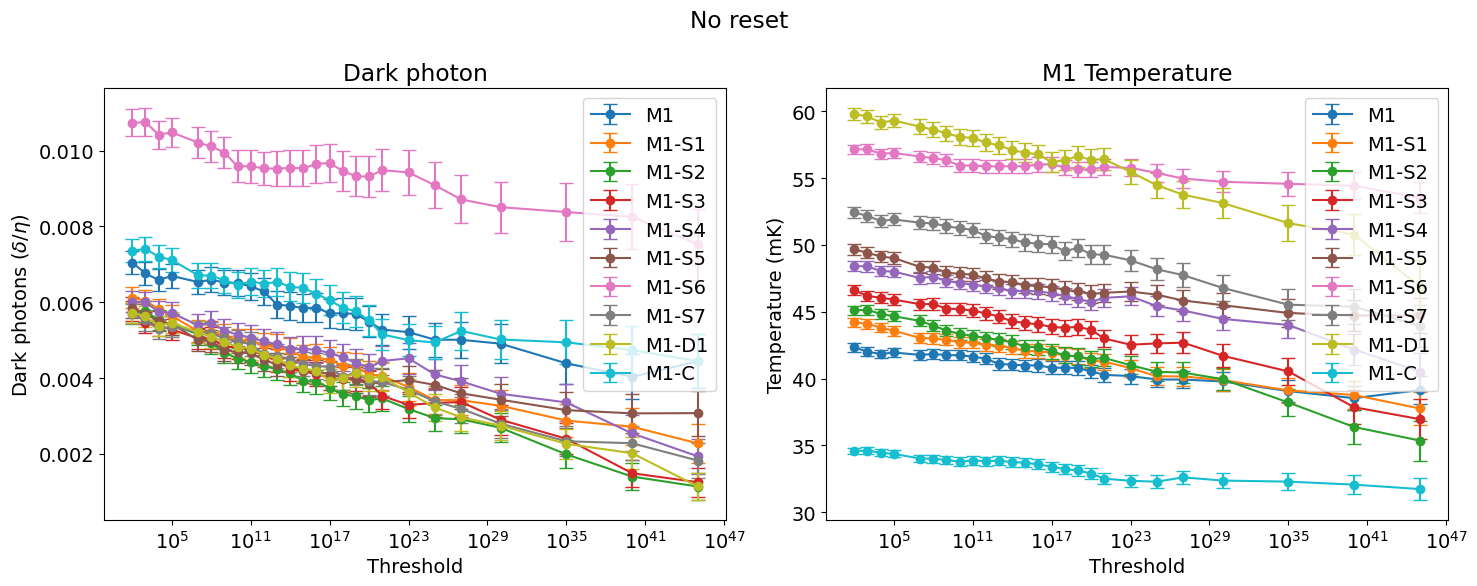

In [32]:
fig = plot_thermal_photon_and_temperature_noeff(threshold_counts_list, efficiency_list[:end_idx], full_threshold_list, frequencies, mode_labels, meas_number,
                                    eff_meas_number=eff_meas_number,
                                    supertitle ='No reset')
fig.savefig('figures/no_reset_mode_temps_250115.pdf', dpi=300)

In [218]:
48 * freq / (np.log(1 + 1 / 0.5e-2))

56.40558202592183

In [216]:
0.5e-2

0.005

In [121]:
df_modes['file_name'][2]

'00151_cavity_temperature_sweep_parity_with_without_reset.h5'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


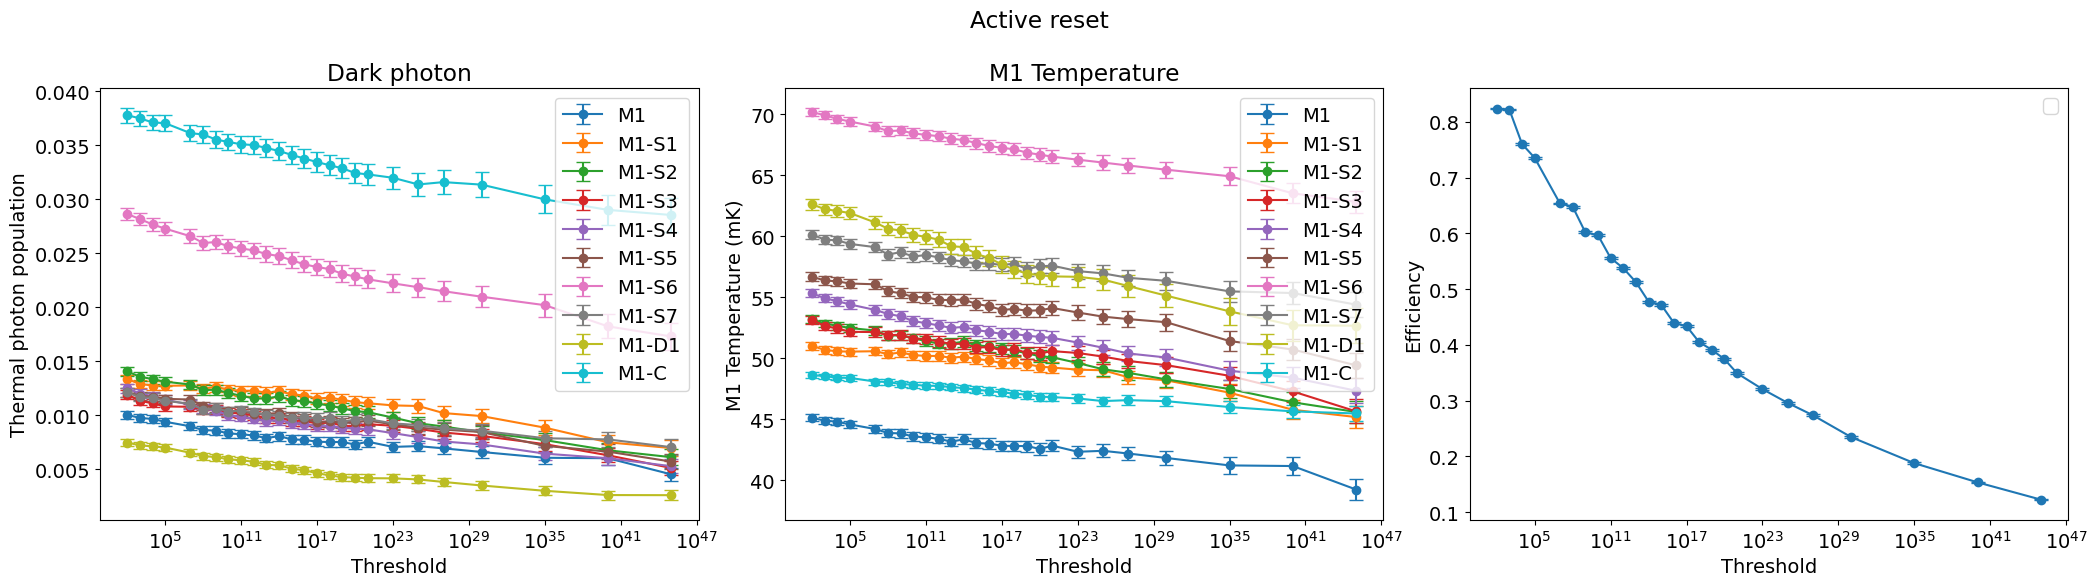

In [205]:
reset = True
man_no_for_parity = 1
single_photon = False
end_idx=-1 # for thresholds
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925, 2313.3, -944]) * 1e-3)
num_modes = len(frequencies)

# select the rows with the correct reset and man_no_for_parity
df_modes = df[(df['reset'] == reset) & (df['man_no_for_parity'] == man_no_for_parity) & (df['single_photon'] == single_photon)]
df_modes.reset_index(drop=True, inplace=True)

df_efficiency = df[(df['reset'] == reset) & (df['man_no_for_parity'] == man_no_for_parity) & (df['single_photon'] == True)]
df_efficiency.reset_index(drop=True, inplace=True)
#caculate efficiences
efficiency_list, efficiency_list_err = calculate_efficiencies_and_errs(df_efficiency)


# calculate dark counts for all modes
threshold_counts_list = [ ast.literal_eval(counts_list)[:end_idx] for counts_list in df_modes['counts_list']][:num_modes]
full_threshold_list = ast.literal_eval(df.loc[0, 'threshold_list'])[:end_idx]
mode_labels = df_modes['mode'].to_list()
# frequencies = 4.984 +np.array([0, 349.41,  1422.925, 2313.3, 170, -944]) * 1e-3 #(np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925, 2313.3, -944]) * 1e-3)  


# get meas_num 
file_name =df_efficiency['file_name'][0]
temp_data, attrs = prev_data(expt_path, file_name)
meas_number = [ reps for reps in df_modes['n_reps']] #attrs['config']['expt']['reps']
eff_meas_number = df_efficiency.loc[0, 'n_reps']
plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list[:end_idx], full_threshold_list, frequencies, mode_labels, meas_number,
                                    eff_meas_number=eff_meas_number,
                                    supertitle ='Active reset')


In [124]:
eff_meas_number

19340

In [125]:
df_modes

file_name   mode  \
0  00157_cavity_temperature_sweep_parity_with_wit...     M1   
1  00158_cavity_temperature_sweep_parity_with_wit...  M1-S1   
2  00159_cavity_temperature_sweep_parity_with_wit...  M1-S7   
3  00160_cavity_temperature_sweep_parity_with_wit...  M1-D1   
4  00161_cavity_temperature_sweep_parity_with_wit...   M1-C   
5  00162_cavity_temperature_sweep_parity_with_wit...     M2   

                                                   T  \
0  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
1  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
2  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
3  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
4  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   
5  [[9.88540058e-01 1.14599419e-02 0.00000000e+00...   

                                                   E  \
0  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   
1  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   
2  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   
3  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   
4  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   
5  [[0.49901515 0.00098485]\n [0.00832562 0.49167...   

                                      threshold_list  \
0  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   
1  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   
2  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   
3  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   
4  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   
5  [100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...   

                                         counts_list  n_reps  \
0  [214, 202, 185, 177, 158, 147, 136, 127, 118, ...   19559   
1  [279, 270, 250, 233, 201, 190, 178, 172, 161, ...   19629   
2  [255, 239, 213, 203, 167, 157, 148, 138, 120, ...   19586   
3  [153, 150, 137, 123, 105, 101, 93, 89, 82, 79,...   19599   
4  [671, 659, 606, 575, 492, 485, 457, 449, 420, ...   19597   
5  [196, 183, 160, 152, 129, 123, 116, 113, 110, ...   19644   

   man_no_for_parity  reset  single_photon                (7, 'filename')  \
0                  1   True          False  00022_ParityTempExperiment.h5   
1                  1   True          False  00022_ParityTempExperiment.h5   
2                  1   True          False  00022_ParityTempExperiment.h5   
3                  1   True          False  00022_ParityTempExperiment.h5   
4                  1   True          False  00022_ParityTempExperiment.h5   
5                  1   True          False  00022_ParityTempExperiment.h5   

                (7, 'file_name')  
0  00022_ParityTempExperiment.h5  
1  00022_ParityTempExperiment.h5  
2  00022_ParityTempExperiment.h5  
3  00022_ParityTempExperiment.h5  
4  00022_ParityTempExperiment.h5  
5  00022_ParityTempExperiment.h5

#### Computing Markov Analysis Traces for M1 with photon and without 

###### With a single photon

In [96]:
file_name = df['file_name'][0]
temp_data, attrs = prev_data(expt_path, file_name)
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)
T, E = get_evolution_matrices(attrs)

parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


In [97]:

# full_meas_sequence = bb[1000]
def find_probs_for_sequence(full_meas_sequence, T = None, E = None):
    '''
    Given a measurement record, compute the probabilities of 0 or 1 photon initially for each subset of the record
    '''
    P0_list = []
    P1_list = []
    for ii in range (len(full_meas_sequence)):
        meas_sequence = full_meas_sequence[0:ii + 1]
        gamma_first_row, dicty  = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = T, E = E)
        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        P0_list.append(P0)
        P1_list.append(P1)
    return P0_list, P1_list

# P0_list, P1_list = find_probs_for_sequence(full_meas_sequence)
    


In [98]:
len(bb)

100000

In [99]:


meas_sequences = bb[0:100000: 20]

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in tqdm(meas_sequences):
    P0_list, P1_list = find_probs_for_sequence(meas_sequence, T=T, E=E)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

xlists = [P0_lists, P1_lists, meas_sequences]
#axs = [ax1, ax2, ax3]
titles = ['P0', 'P1', 'Measurement Record']
mins = [1e-20, 1e-5, 0 ]



100%|██████████| 5000/5000 [08:16<00:00, 10.06it/s]


C:\Users\26049\AppData\Local\Temp\ipykernel_21940\1888461897.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("coolwarm")


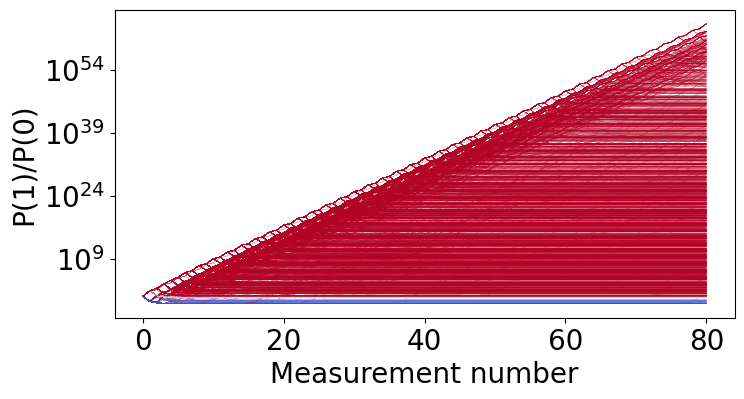

In [101]:
# only plot P(1)/P(0)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
xlist = np.array(xlists[1])/np.array(xlists[0])
for x in xlist:
    norm = matplotlib.colors.Normalize(
        vmin=1e-20, vmax=1
    )
    cmap = matplotlib.cm.get_cmap("coolwarm")
    color = cmap(norm(x[-1]))
    ax.semilogy(
        x, "-", linewidth=0.2, alpha=1, color=color
    )
    #ax.set_title(title) 
ax.set_xlabel('Measurement number')
ax.set_ylabel('P(1)/P(0)')
fig.savefig('figures/_single_photon_P1_P0_ratio.pdf', dpi=300)


0it [00:00, ?it/s]C:\Users\26049\AppData\Local\Temp\ipykernel_21940\729253365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
3it [00:03,  1.22s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

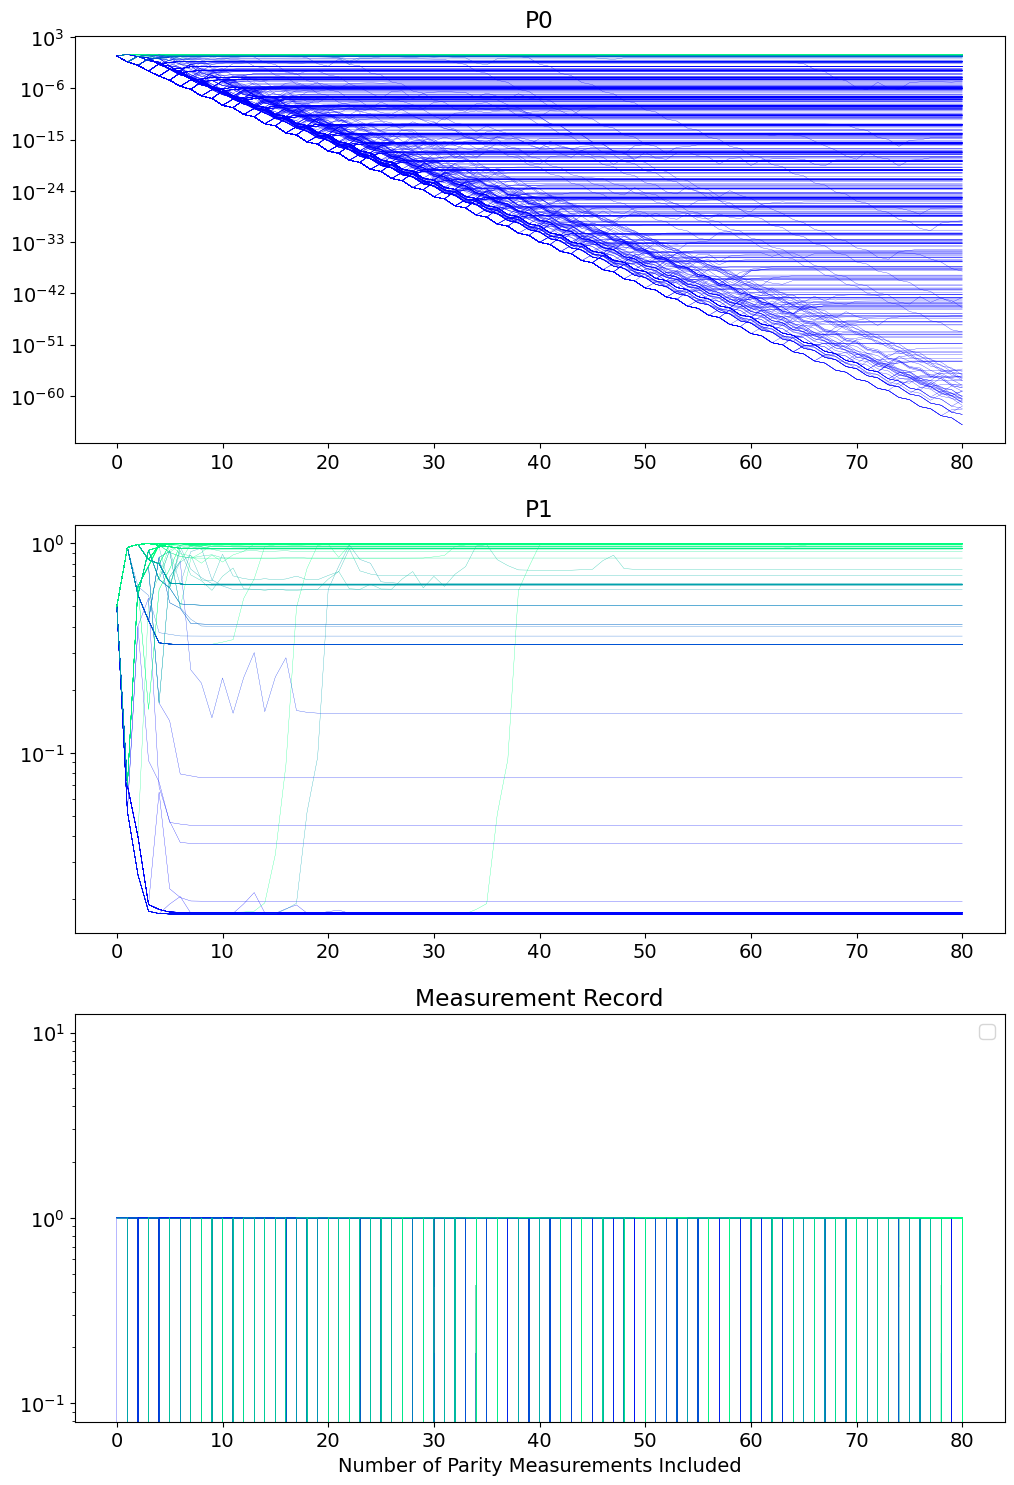

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
axs = [ax1, ax2, ax3]

for xlist, ax, title, min_ in tqdm(zip(xlists, axs, titles, mins)):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

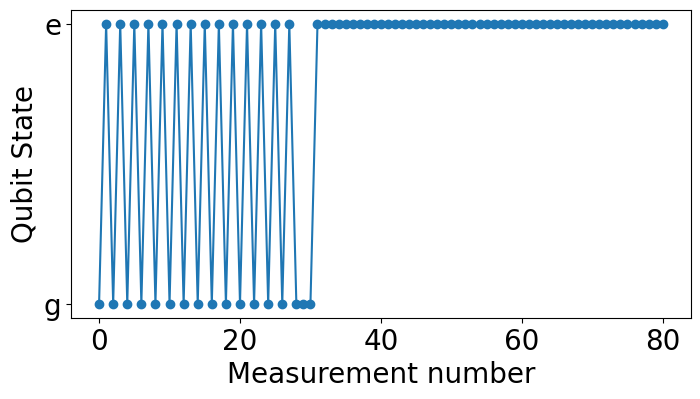

In [102]:
fig = plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 20})
plt.plot(meas_sequences[500], '-o')
# set yticks to be ['g', 'e']
plt.yticks([0, 1], ['g', 'e'])
plt.xlabel('Measurement number')
plt.ylabel('Qubit State')
plt.savefig('figures/_single_photon_measurement_sequence.pdf', dpi=300)


In [65]:
meas_sequences[900]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

###### Without a single photon

In [82]:
file_name = df['file_name'][1]
temp_data, attrs = prev_data(expt_path, file_name)
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)
T, E = get_evolution_matrices(attrs)

parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


In [ ]:

# full_meas_sequence = bb[1000]
def find_probs_for_sequence(full_meas_sequence, T = None, E = None):
    '''
    Given a measurement record, compute the probabilities of 0 or 1 photon initially for each subset of the record
    '''
    P0_list = []
    P1_list = []
    for ii in range (len(full_meas_sequence)):
        meas_sequence = full_meas_sequence[0:ii + 1]
        gamma_first_row, dicty  = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = T, E = E)
        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        P0_list.append(P0)
        P1_list.append(P1)
    return P0_list, P1_list

# P0_list, P1_list = find_probs_for_sequence(full_meas_sequence)
    


In [83]:
len(bb)

100000

In [86]:


meas_sequences = bb[0:100000: 20]

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in tqdm(meas_sequences):
    P0_list, P1_list = find_probs_for_sequence(meas_sequence, T=T, E=E)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

xlists = [P0_lists, P1_lists, meas_sequences]
#axs = [ax1, ax2, ax3]
titles = ['P0', 'P1', 'Measurement Record']
mins = [1e-20, 1e-5, 0 ]



100%|██████████| 5000/5000 [08:17<00:00, 10.05it/s]


C:\Users\26049\AppData\Local\Temp\ipykernel_21940\133127784.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("coolwarm")


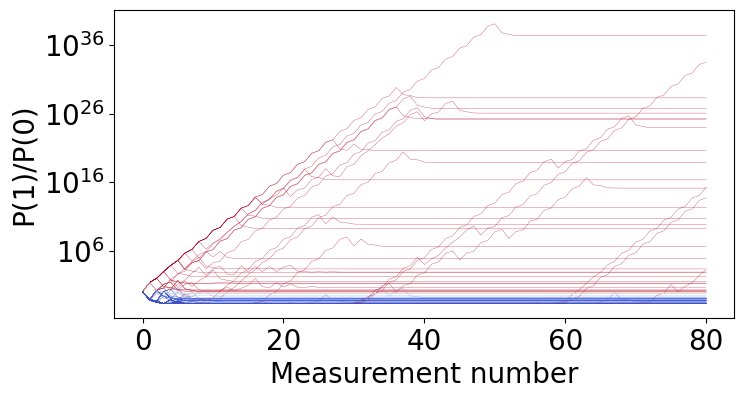

In [95]:
# only plot P(1)/P(0)
# fig = plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
xlist = np.array(xlists[1])/np.array(xlists[0])
for x in xlist:
    norm = matplotlib.colors.Normalize(
        vmin=1e-20, vmax=1
    )
    cmap = matplotlib.cm.get_cmap("coolwarm")
    color = cmap(norm(x[-1]))
    ax.semilogy(
        x, "-", linewidth=0.2, alpha=1, color=color
    )
    #ax.set_title(title) 
ax.set_xlabel('Measurement number')
ax.set_ylabel('P(1)/P(0)')
fig.savefig('figures/_no_photon_P1_P0_ratio.pdf', dpi=300)


0it [00:00, ?it/s]C:\Users\26049\AppData\Local\Temp\ipykernel_21940\729253365.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
3it [00:03,  1.25s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

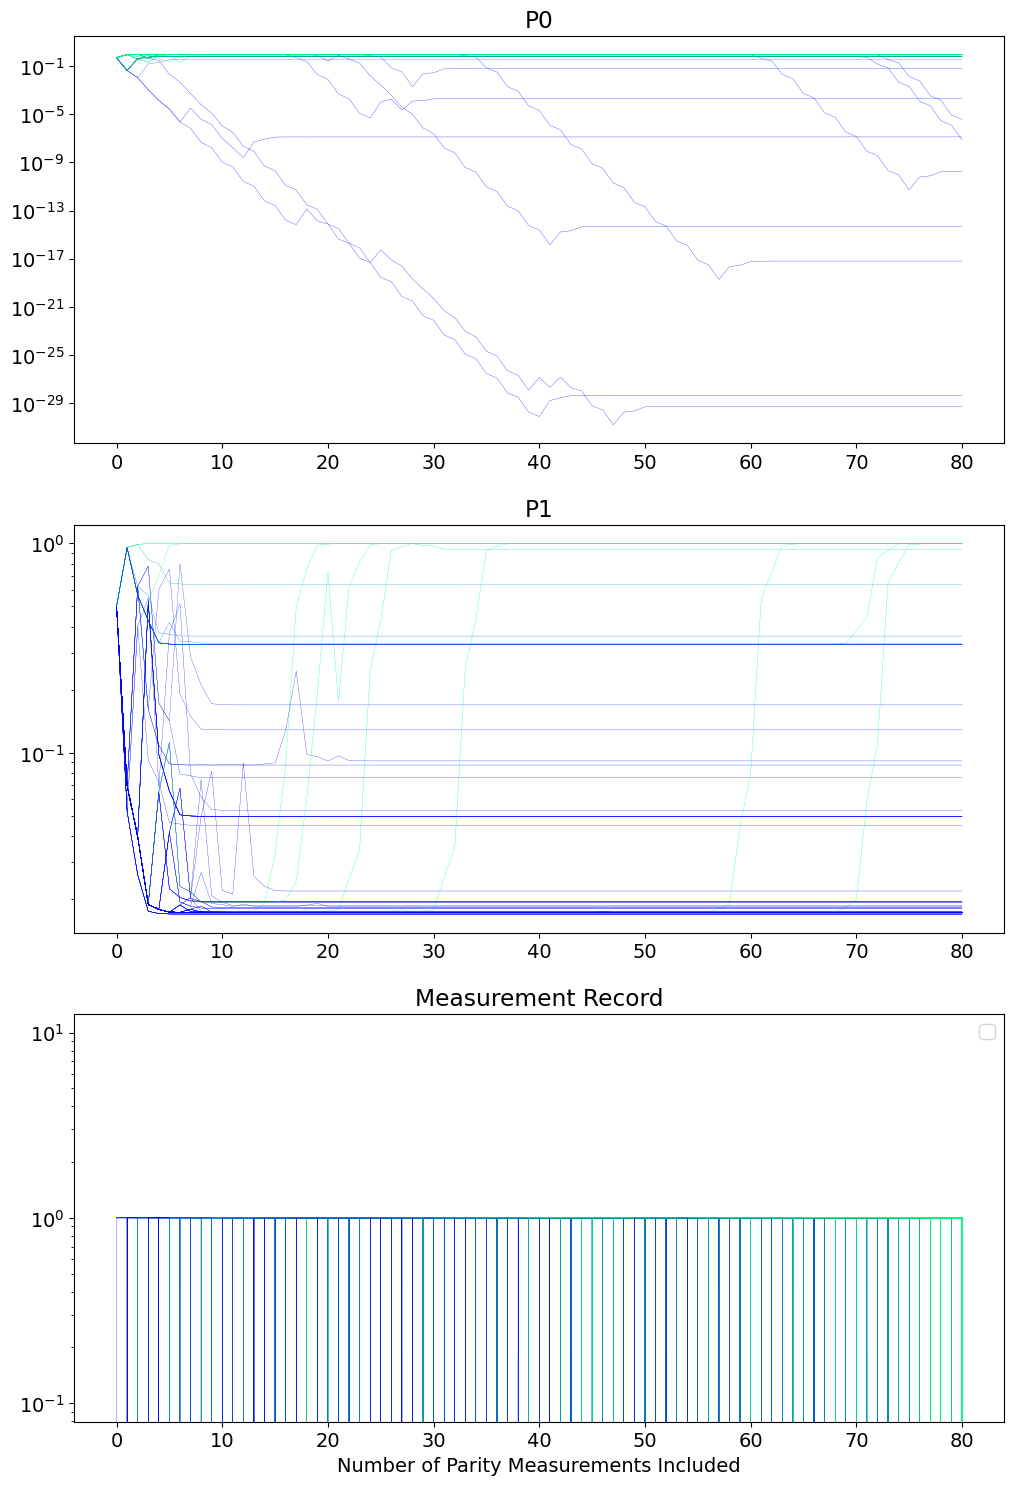

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
axs = [ax1, ax2, ax3]

for xlist, ax, title, min_ in tqdm(zip(xlists, axs, titles, mins)):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

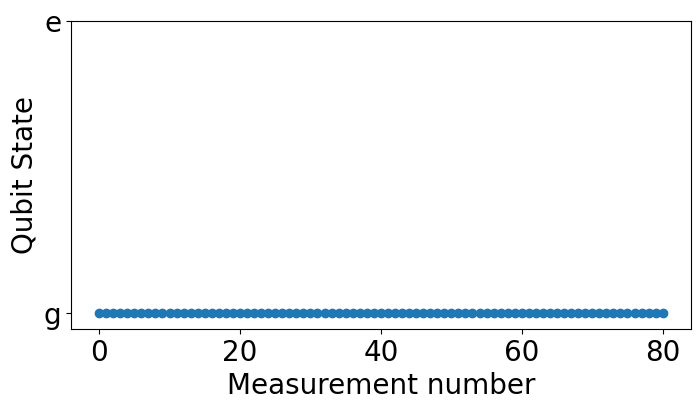

In [93]:
fig = plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size': 20})
plt.plot(meas_sequences[500], '-o')
plt.yticks([0, 1], ['g', 'e'])
plt.xlabel('Measurement number')
plt.ylabel('Qubit State')
plt.savefig('figures/_no_photon_measurement_sequence.pdf', dpi=300)


# Testing particular data

In [114]:
file_name = '00020_ParityTempExperiment.h5'
mode = 1 #df.loc[df_idx, 'mode']
  
threshold_list = [10, 100, 1000, 1e4, 1e5]

print(f'Processing {file_name} for {mode} mode')

temp_data, attrs = prev_data(expt_path, file_name)
readout_threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
active_reset = attrs['config']['expt']['active_reset']
if active_reset:
    readouts_per_rep +=3

aa, bb = parity_temp_display(temp_data, attrs, active_reset=active_reset, threshold = readout_threshold, readouts_per_rep= readouts_per_rep)

T, E = get_evolution_matrices(attrs)

Processing 00020_ParityTempExperiment.h5 for 1 mode
calling parity post select modified
size of ilist 19441
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


In [111]:
data = temp_data
I_data = data['idata'] # in shape rounds(1) x expts (1)  x reps   x read_num
Q_data = data['qdata'] 

reps = 20000
# assume we have made 80 parity measurements
# reshape data into (reps, read_num)
read_num = readouts_per_rep 
I_data_rs = np.reshape(I_data, (reps, read_num))
Q_data_rs = np.reshape(Q_data, (reps, read_num))

In [110]:
num = 0 
for row in I_data_rs:
    if row[2]<-70:
        num+=1
print(num)

36


In [68]:
# choose random subset of bb
bb_subset = bb[0:20000]
threshold_counts, m1_running_dict = compute_threshold_counts(bb_subset, threshold_list, T = T, E = E)

Processing: 100%|██████████| 20000/20000 [15:35<00:00, 21.37it/s]


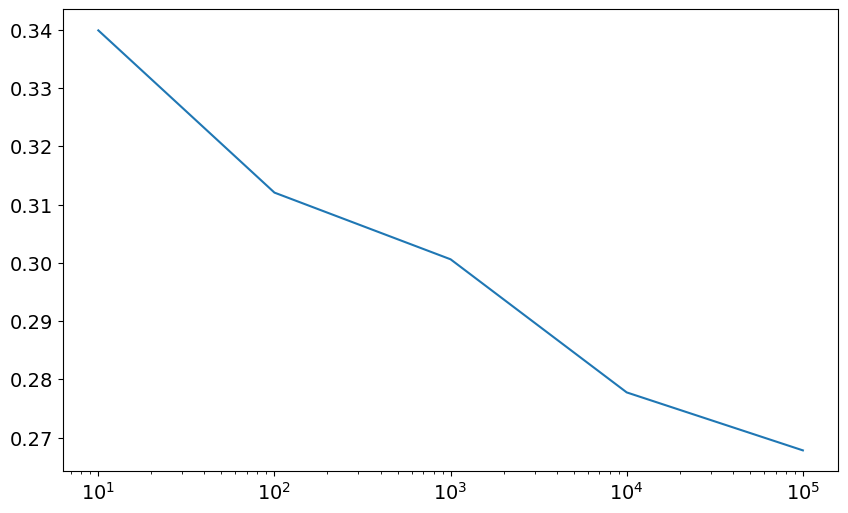

In [69]:
plt.plot(threshold_list, np.array(threshold_counts)/len(bb_subset))
plt.xscale('log')

In [70]:
aa, bb2 = parity_temp_display(temp_data, attrs, active_reset=False, threshold = readout_threshold, readouts_per_rep= readouts_per_rep, 
                             cutoff_meas_idx=60)
bb2_subset = bb2[0:20000]
threshold_counts2, m1_running_dict = compute_threshold_counts(bb2_subset, threshold_list, T = T, E = E)


Processing: 100%|██████████| 20000/20000 [16:04<00:00, 20.73it/s]


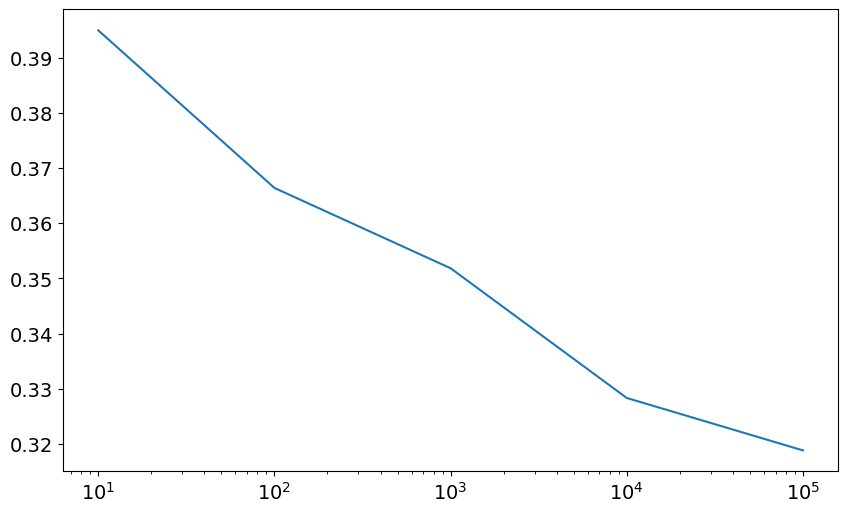

In [71]:
plt.plot(threshold_list, np.array(threshold_counts2)/len(bb2_subset))
plt.xscale('log')

In [72]:
threshold_counts2

[7899, 7328, 7037, 6567, 6377]

In [75]:
0.014 /0.4

0.034999999999999996

In [73]:
threshold_counts

[6798, 6241, 6012, 5555, 5356]

# Old Anlysis

In [195]:
temp_data, attrs = prev_data(expt_path, '00163_cavity_temperature_sweep_parity_with_without_reset.h5')
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 100000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 80}

In [196]:
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=attrs['config']['expt']['active_reset'], threshold = threshold, readouts_per_rep= readouts_per_rep,
                             consistent_parity_check_bool=True, consistent_cutoff=9)
# threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
# orig_running_dict = running_dict.copy()
T, E = get_evolution_matrices(attrs)

len of state string list before consistency check 100000
len of state string list after consistency check 62328
parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


### Calculate Efficiency

In [134]:
# temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00138_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00022_ParityTempExperiment.h5')

threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=attrs['config']['expt']['active_reset'], threshold = threshold, readouts_per_rep= readouts_per_rep)
# threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
# orig_running_dict = running_dict.copy()
T, E = get_evolution_matrices(attrs)

calling parity post select modified
size of ilist 19340
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


In [135]:
full_threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, T = T, E = E)

Processing: 100%|██████████| 19340/19340 [00:41<00:00, 462.37it/s]


#### Looking at maximal attainable threshold

In [66]:
temp_data, attrs = prev_data(expt_path, '00140_cavity_temperature_sweep_parity_with_without_reset.h5')

threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)
T, E = get_evolution_matrices(attrs)

parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


In [174]:

# full_meas_sequence = bb[1000]
def find_probs_for_sequence(full_meas_sequence, T = None, E = None):
    '''
    Given a measurement record, compute the probabilities of 0 or 1 photon initially for each subset of the record
    '''
    P0_list = []
    P1_list = []
    for ii in range (len(full_meas_sequence)):
        meas_sequence = full_meas_sequence[0:ii + 1]
        gamma_first_row, dicty  = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = T, E = E)
        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        P0_list.append(P0)
        P1_list.append(P1)
    return P0_list, P1_list

# P0_list, P1_list = find_probs_for_sequence(full_meas_sequence)
    


100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]
0it [00:00, ?it/s]C:\Users\26049\AppData\Local\Temp\ipykernel_10340\316664330.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
3it [00:04,  1.43s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

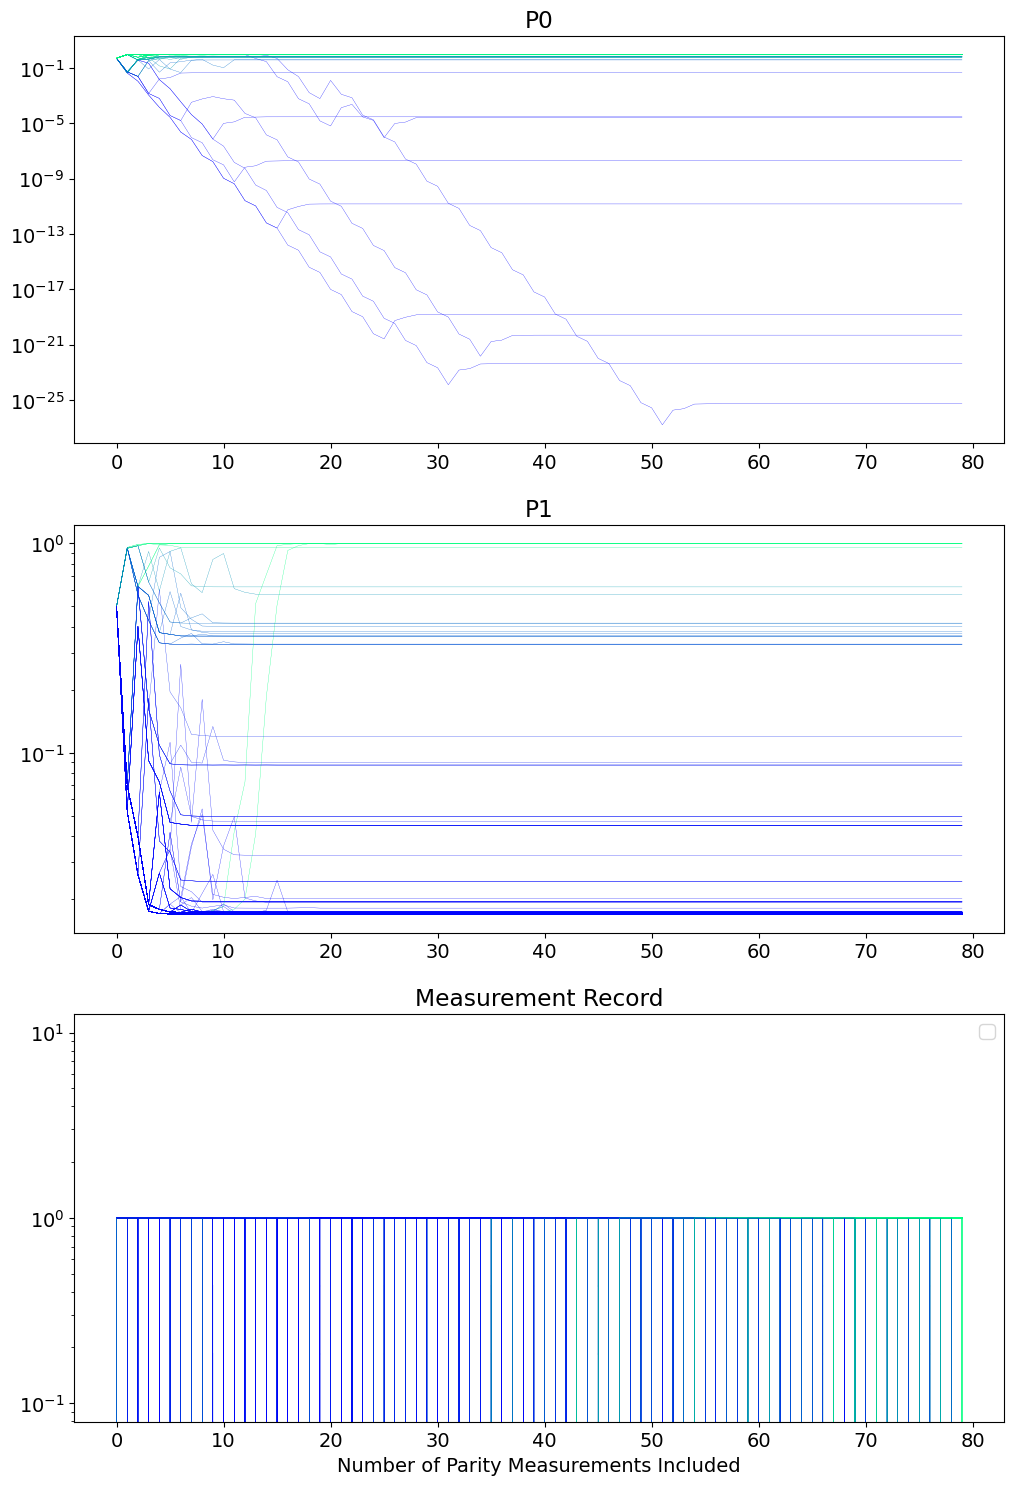

In [60]:


meas_sequences = bb[0:20000: 20]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in tqdm(meas_sequences):
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

xlists = [P0_lists, P1_lists, meas_sequences]
axs = [ax1, ax2, ax3]
titles = ['P0', 'P1', 'Measurement Record']
mins = [1e-20, 1e-5, 0 ]

for xlist, ax, title, min_ in tqdm(zip(xlists, axs, titles, mins)):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

In [ ]:
def plot_fidelities(self, timestamp=None, fig=None, ax=None, log=True, **kwargs):
        fidelities = self.fidelities(timestamp).T
        fig = fig if fig is not None else plt.figure(figsize=(3.5, 2.25), dpi=200)
        ax = ax if ax is not None else fig.subplots()
        end_fids = fidelities[:, -1]
        indxs = np.argsort(end_fids)
        fidelities = fidelities[indxs]
        for fids in fidelities[:-1]:
            import matplotlib

            norm = matplotlib.colors.Normalize(
                vmin=np.log10(1 - fidelities[-1][-1]), vmax=0
            )
            cmap = matplotlib.cm.get_cmap("winter")
            color = cmap(norm(np.log10(1 - fids[-1])))
            if log:
                ax.semilogy(
                    1 - fids, "-", linewidth=0.2, alpha=1, color=color, **kwargs
                )
            else:
                ax.plot(fids, "-", linewidth=0.5, **kwargs)
        color = cmap(norm(np.log10(1 - fidelities[-1][-1])))
        if log:
            ax.semilogy(1 - fidelities[-1], linewidth=1, color=color, **kwargs)
        else:
            ax.plot(fidelities[-1], **kwargs)

        # ax.set_xlabel("epoch", size=8)
        # if log:
        #    ax.set_ylabel("infidelity", size=8)
        # else:
        #    ax.set_ylabel("fidelity", size=8)
        fig.tight_layout()

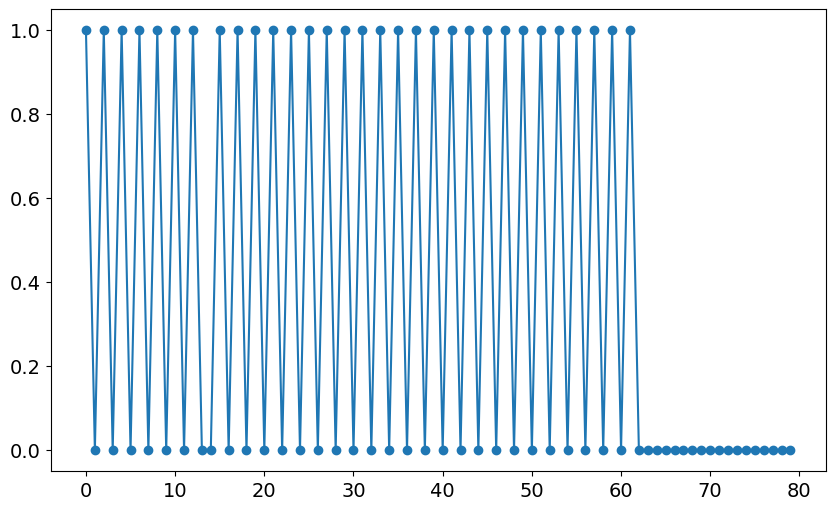

In [ ]:
plt.plot(meas_sequences[200], '-o')

In [ ]:
meas_sequences[200]

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Now computing efficiency

In [136]:
threshold_counts

[15955,
 15183,
 15086,
 15012,
 15004,
 13861,
 13818,
 13732,
 13357,
 11728,
 10561,
 8075,
 6188,
 3723,
 2268]

In [133]:
n

20000

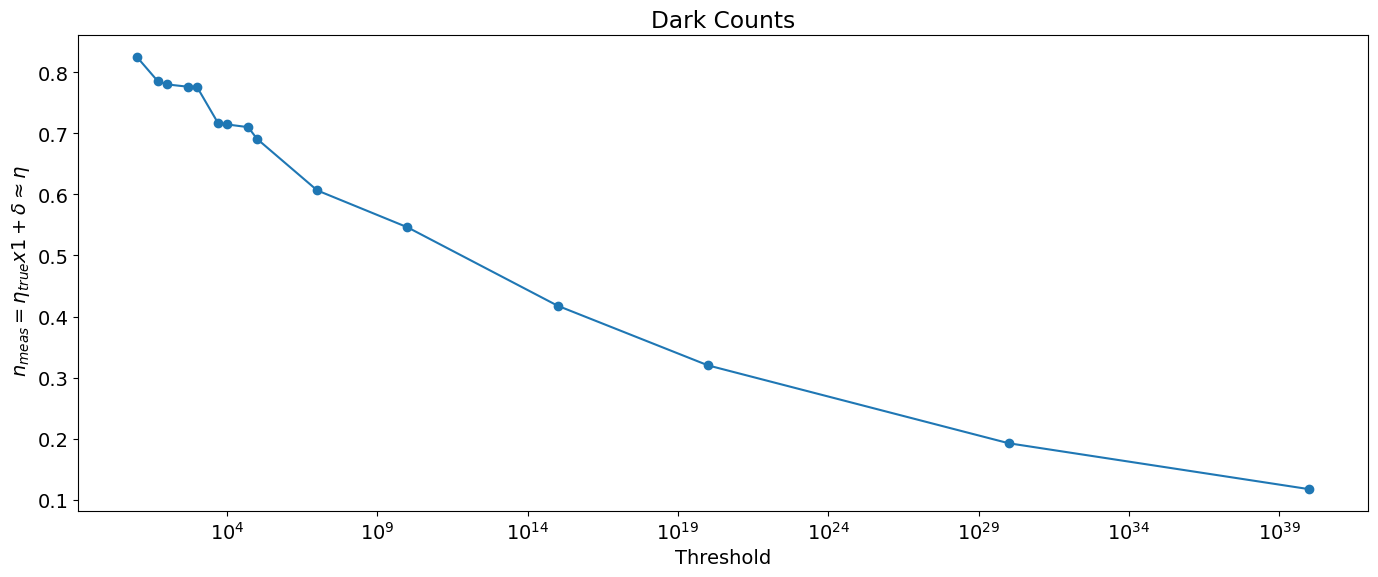

In [137]:
n = len(bb)
dark_counts = np.array(threshold_counts) / n

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [138]:
efficiency_list = np.array(threshold_counts) /len(bb)

In [139]:
efficiency_list 

array([0.82497415, 0.78505688, 0.78004137, 0.7762151 , 0.77580145,
       0.71670114, 0.71447777, 0.71003102, 0.69064116, 0.60641158,
       0.54607032, 0.41752844, 0.31995863, 0.19250259, 0.11726991])

Text(0, 0.5, 'Dark Counts')

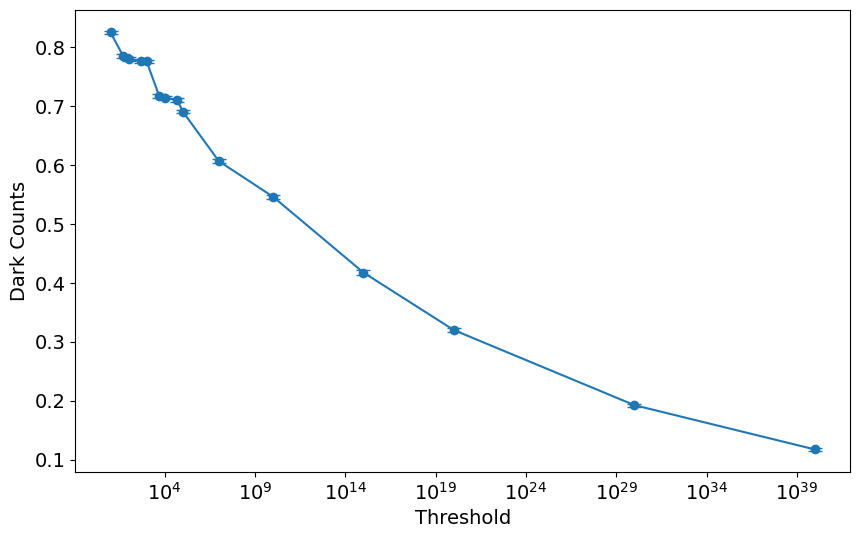

In [140]:
dark_counts =  efficiency_list
# standard error from binomial distribution sqrt(p(1-p)/n)
probs = efficiency_list 
n = attrs['config']['expt']['reps']
efficiency_list_err = np.sqrt(probs*(1-probs)/n)
# dark_counts_err = np.sqrt(dark_counts )
# efficiency_list_err = dark_counts_err/1e5

# plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.errorbar(full_threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Dark Counts')

In [141]:
efficiency_list_err

array([0.00268693, 0.00290467, 0.00292897, 0.00294708, 0.00294901,
       0.00318623, 0.00319374, 0.00320848, 0.00326845, 0.00345454,
       0.00352049, 0.00348711, 0.00329837, 0.00278788, 0.00227506])

In [ ]:
# efficiency_list = [0.6611 , 0.63235, 0.62515, 0.61114, 0.60217, 0.57661, 0.57405,
#        0.54543, 0.53883, 0.49583, 0.49091, 0.4786 , 0.46403, 0.45069,
#        0.44733]

### Use above for Coupler temp 

In [168]:

temp_data, attrs = prev_data(expt_path, '00025_ParityTempExperiment.h5') # with reset 

threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=attrs['config']['expt']['active_reset'],
                              threshold = threshold, readouts_per_rep= readouts_per_rep)
# threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
# orig_running_dict = running_dict.copy()
T, E = get_evolution_matrices(attrs)

calling parity post select modified
size of ilist 19804
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0019696969696967326
e_infidelity 0.016651248843663313


In [169]:
full_threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, T = T, E = E)

Processing: 100%|██████████| 19804/19804 [00:17<00:00, 1164.91it/s]


In [170]:
threshold_counts

[768, 734, 733, 722, 720, 661, 659, 654, 643, 576, 519, 409, 322, 200, 133]

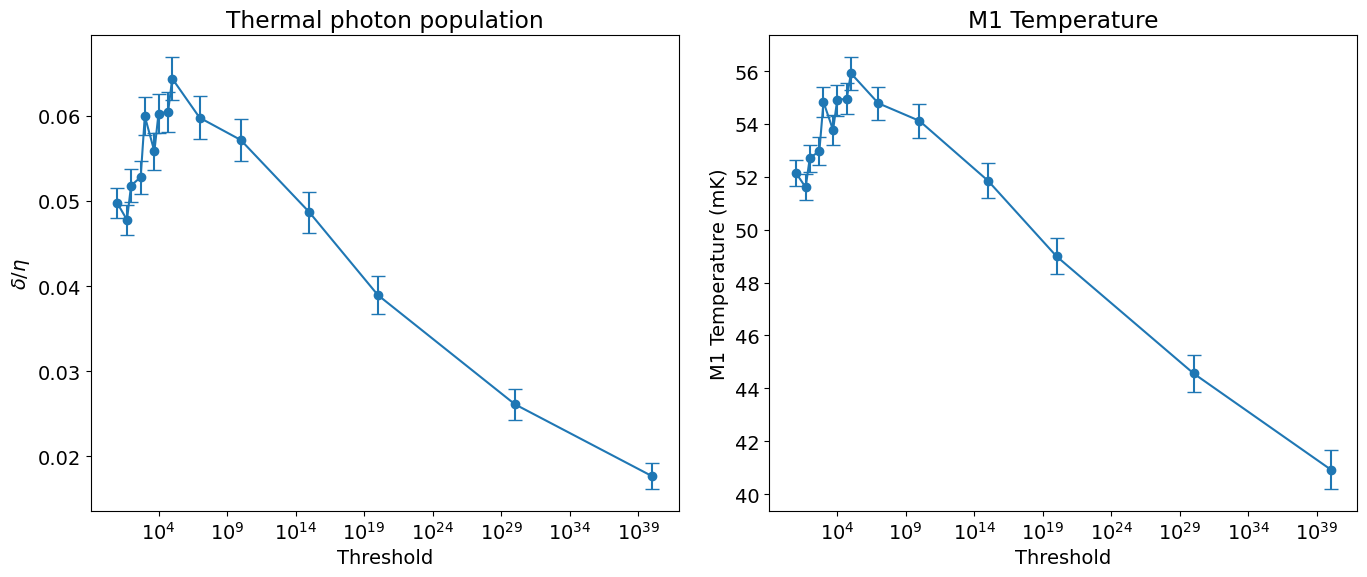

In [171]:
start_idx = 0
end_idx =  None

n = len(bb)
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 -0.944 #+1.4

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp_single_val = 48 * frequency / (np.log(1 + 1 / now[i]))
    tempr.append(temp_single_val)
    temp_err = np.abs(temp_single_val * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [164]:
efficiency_list 

array([0.78004137, 0.77580145, 0.71447777, 0.69064116, 0.60641158,
       0.59808687, 0.55222337, 0.54607032, 0.50439504, 0.48660807,
       0.45853154, 0.42430196, 0.41752844, 0.38681489, 0.38009307,
       0.35263702, 0.33867632, 0.31995863, 0.29746639, 0.27125129,
       0.24710445, 0.22481903, 0.19250259, 0.15010341, 0.11726991,
       0.09120993, 0.07166494])

In [ ]:
thermal_photon_population = []
        thermal_photon_population_err = []
        for i in range(len(dark_counts)):
            thermal_photon_population.append(dark_counts[i] / efficiency_list[i])
            ratio = dark_counts[i] / efficiency_list[i]
            err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
            thermal_photon_population_err.append(err)

        now = np.array(thermal_photon_population) / 2
        now_err = np.array(thermal_photon_population_err) / 2
        tempr = []
        tempr_err = []
        for i in range(len(now)):
            temp_single_val = 48 * frequency / (np.log(1 + 1 / now[i]))
            tempr.append(temp_single_val)
            temp_err = np.abs(temp_single_val * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
            tempr_err.append(temp_err)

In [156]:
threshold_counts

[777, 731, 720, 713, 711, 646, 644, 636, 618, 553, 494, 398, 313, 175, 111]

In [161]:
777/19700/0.8

0.049302030456852795

In [150]:
frequency

4.04

In [149]:
48 * frequency / (np.log(1 + 1 / 0.04))

59.51941501333175

### Use above efficiency to calculate temperature for M1
This is really the efficiency-normalized false positive  probability for M1

In [ ]:
temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

threshold_counts, m1_running_dict = compute_threshold_counts(bb, full_threshold_list)#, m1_running_dict)


Processing: 100%|██████████| 200000/200000 [49:13<00:00, 67.71it/s] 


#### Measurement record analsysi

calling parity post select modified
size of ilist 19804


100%|██████████| 991/991 [01:42<00:00,  9.63it/s]
C:\Users\26049\AppData\Local\Temp\ipykernel_10340\2359025679.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

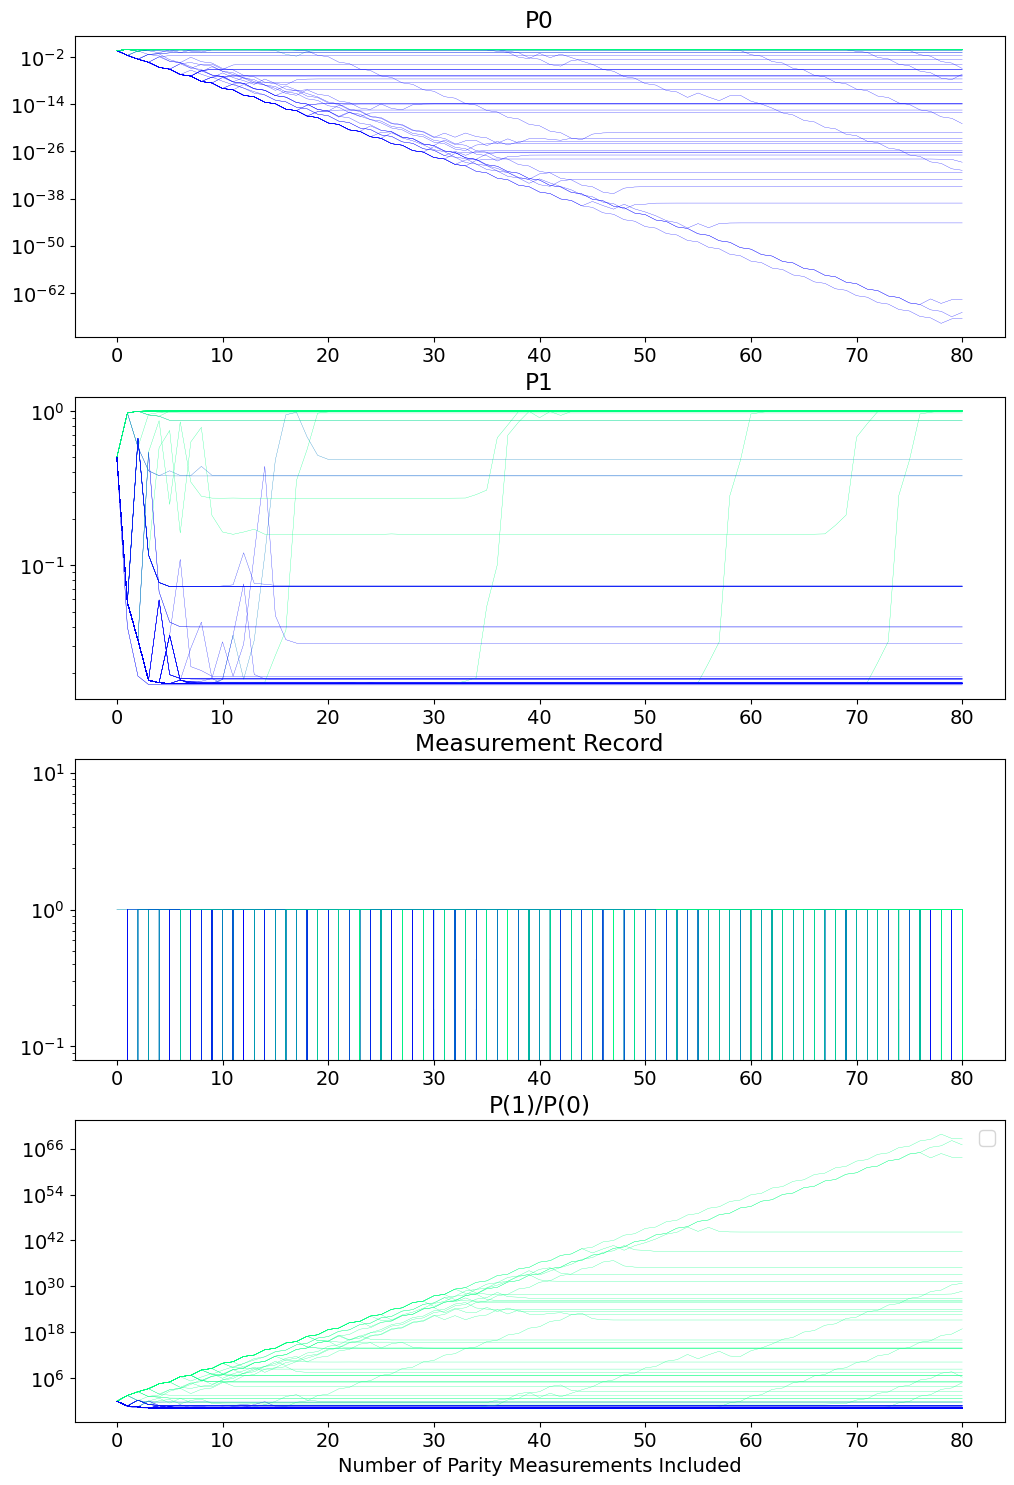

In [175]:
temp_data, attrs = prev_data(expt_path, '00025_ParityTempExperiment.h5')
# threshold = attrs['config']['device']['readout']['threshold'][0]
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
threshold_list = [10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 1e7, 1e10, 1e15, 1e20, 1e30, 1e40]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=attrs['config']['expt']['active_reset'],
                              threshold = threshold, readouts_per_rep= readouts_per_rep)

meas_sequences = bb[0:20000: 20]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in tqdm(meas_sequences):
    P0_list, P1_list = find_probs_for_sequence(meas_sequence, T = T, E = E)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [P0_lists, P1_lists, meas_sequences, ratio_list]
axs = [ax1, ax2, ax3, ax4]
titles = ['P0', 'P1', 'Measurement Record', 'P(1)/P(0)']
mins = [1e-20, 1e-20, 0 , 1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\2593989401.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

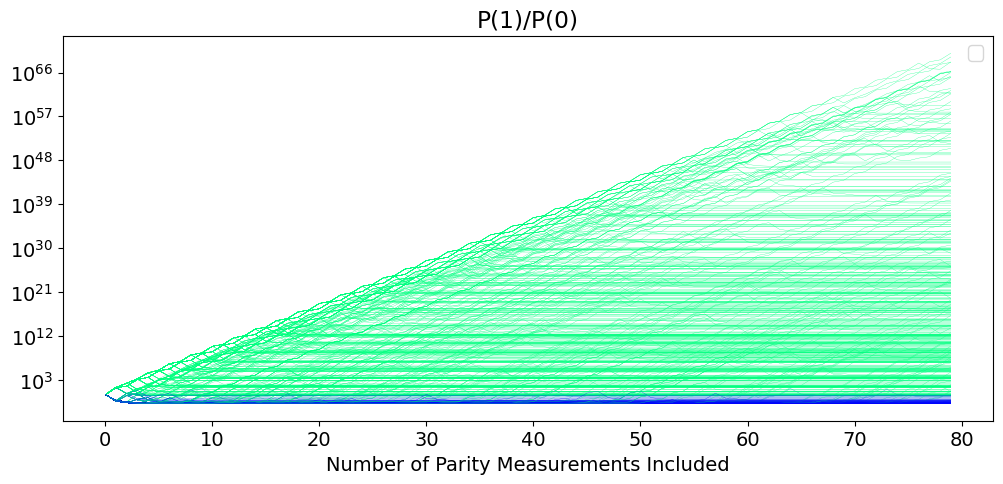

In [ ]:
temp_data, attrs = prev_data(expt_path, '00110_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[0:10000: 10]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists.npy', P1_lists)
np.save('p0_lists.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\1666274284.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

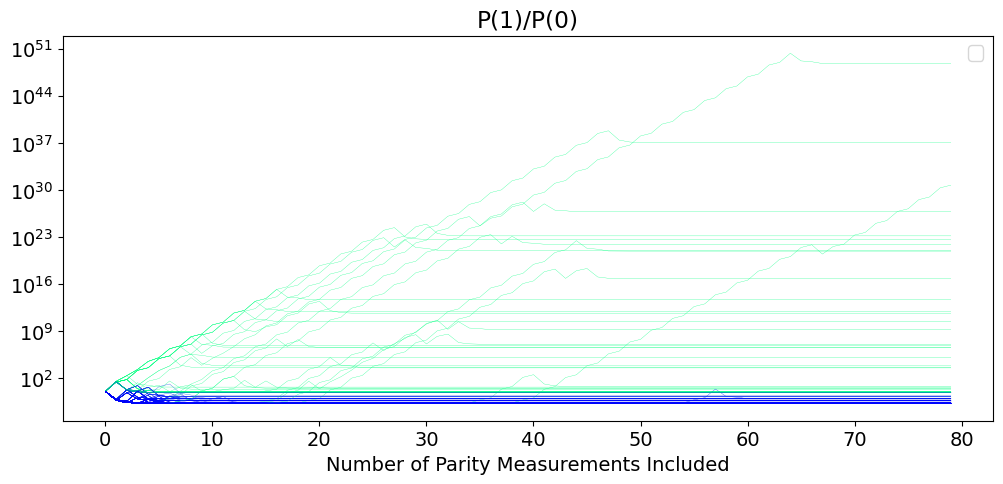

In [ ]:
temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[1:10000: 5]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists2.npy', P1_lists)
np.save('p0_lists2.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

#### Back to temp calculation

In [ ]:
full_threshold_list

(10000000.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0,
 10000000000.0,
 50000000000.0,
 100000000000.0,
 1000000000000.0,
 5000000000000.0,
 10000000000000.0,
 100000000000000.0,
 1000000000000000.0,
 1e+16,
 1e+17,
 1e+18,
 1e+19,
 1e+20,
 1e+21,
 1e+25,
 1e+30,
 1e+35,
 1e+40,
 1e+45,
 1e+50)

In [ ]:
threshold_counts

[1657,
 1533,
 1360,
 1298,
 1070,
 1006,
 899,
 859,
 762,
 721,
 666,
 614,
 579,
 526,
 497,
 454,
 426,
 376,
 342,
 290,
 241,
 198,
 155,
 115,
 79,
 50,
 31]

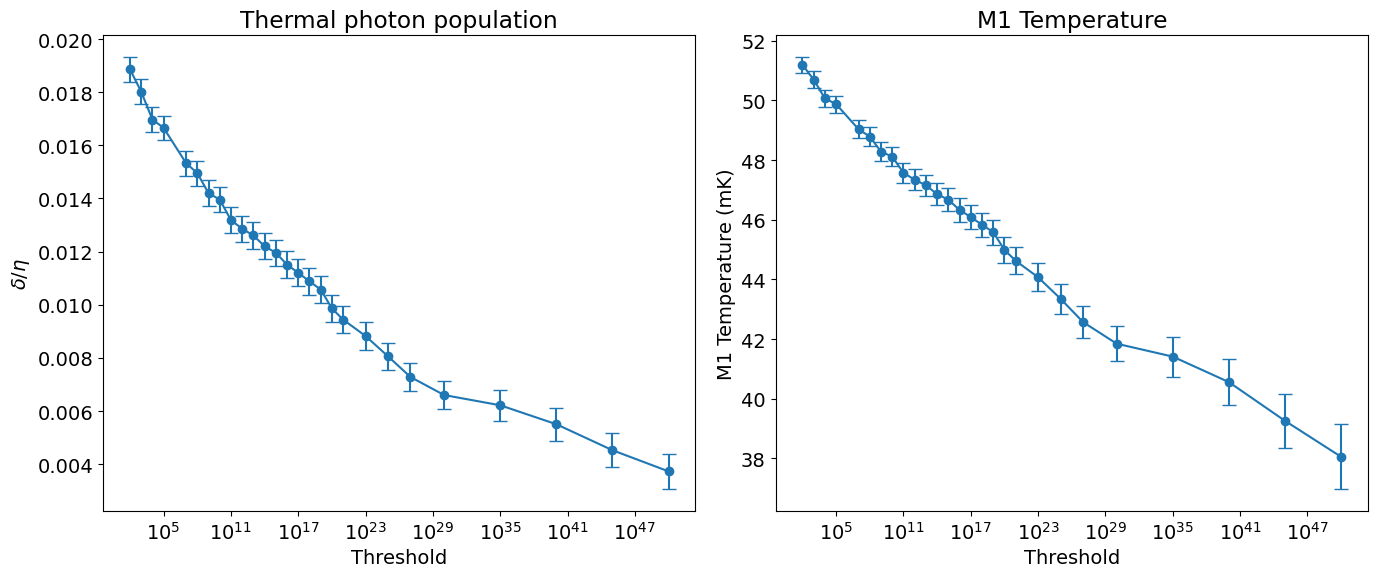

In [ ]:
start_idx = 0
end_idx =  None

n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 #+1.4

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp = 48 * frequency / (np.log(1 + 1 / now[i]))
    temp_err = np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr.append(temp)
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 20000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[944.25],
  [1000],
  [0.316677658],
  [0],
  [1],
  ['flat_top'],
  [0.005]],
 'readout_no_placeholder': 80}

In [ ]:
i = 5
temp = 48 * frequency / (np.log(1 + 1 / now[i]))
np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))

0.4443015985375665

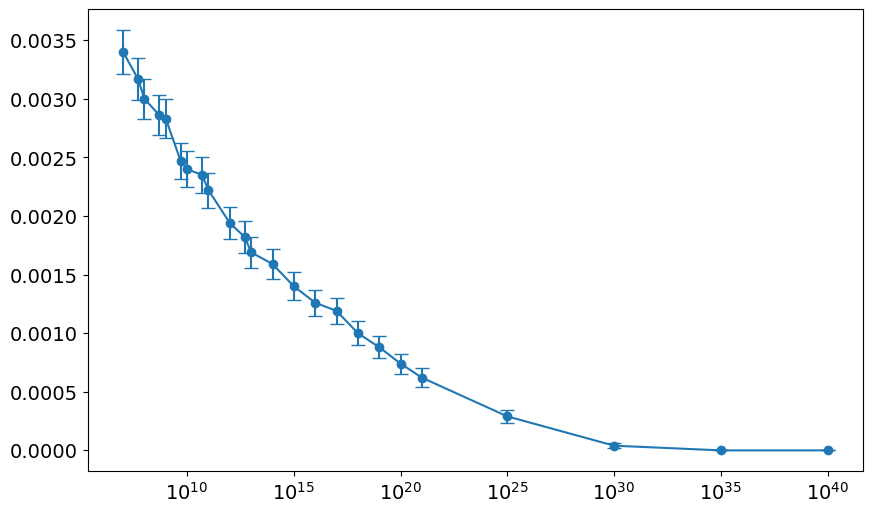

In [ ]:
plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.xscale('log')

In [ ]:
temp

40.922135993882144

In [ ]:
i = -10
thermal_photon_population[i] * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)

0.0003759365748738378

In [ ]:
0.0003/(0.003

33.33333333333333

In [ ]:
dark_counts[-3]

4e-05

In [ ]:
thermal_photon_population_err[i]

0.00036647106255566675

## Manipulate 2

In [96]:
temp_data, attrs = prev_data(expt_path, '00013_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=80)

In [109]:
ii = 2
temp_meas_sequence = meas_sequence[0:ii+1]
    
# forward-backward algorithm return state probabilities at each step
gamma_matrix, alpha, beta = gamma(temp_meas_sequence, T, E, ret_all = False)

# pick off probability of cavitiy state at the beginning, 0 in the first index
# # sum over qubit state probability, second index
# P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
# P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

# gamma_matrix

In [110]:
meas_sequence = bb[5000]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # # pick off probability of cavitiy state at the beginning, 0 in the first index
    # # sum over qubit state probability, second index
    # P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    # P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

    gamma_first_row = wrapper_gamma(temp_meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
    P0_first.append(gamma_first_row[0] + gamma_first_row[1])
    P1_first.append(gamma_first_row[2] + gamma_first_row[3])
# figure(figsize = (12,8))

# # plot measurement record
# subplot(2,1,1)
# plot(meas_sequence, 'o--')
# ylim(-0.1, 1.1)

# # plot reconstructed probabilities for subsets of the measurement record
# subplot(2,1,2)
# semilogy(P0_first, 'o', label= "P(n=0)")
# semilogy(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-9)
# #         plot(P0_first, 'o', label= "P(n=0)")
# #         plot(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-8)
# #         ylim(1e-16,1e0)
# ylabel('P(t=0)')
# xlabel('Number of Parity Measurements Included')
# legend()
# tight_layout

In [987]:
temp_data, attrs = prev_data(expt_path, '00012_ParityTempExperiment.h5')
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)
threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
orig_running_dict = running_dict.copy()

Processing: 100%|██████████| 100000/100000 [05:20<00:00, 311.63it/s]


In [ ]:
full_threshold_list =[100.0,
 1000.0,
 10000.0,
 100000.0,
 10000000.0,
 100000000.0,
 1000000000.0,
 10000000000.0,
 100000000000.0,
 1000000000000.0,
 10000000000000.0,
 100000000000000.0,
 1000000000000000.0,
 1e+16,
 1e+17,
 1e+18,
 1e+19,
 1e+20,
 1e+21,
 1e+23,
 1e+25,
 1e+27,
 1e+30,
 1e+35,
 1e+40,
 1e+45,
 1e+50]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, orig_running_dict)

# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

Processing:  55%|█████▍    | 54670/100000 [36:25<33:26, 22.59it/s]  

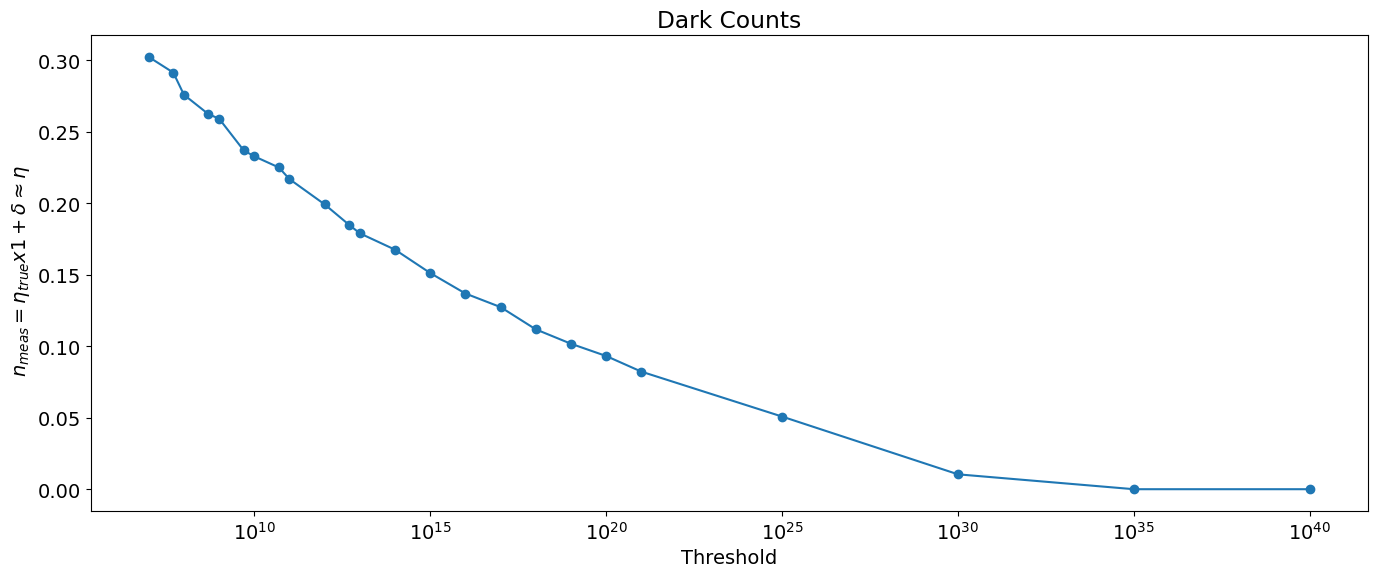

In [989]:
dark_counts = np.array(threshold_counts) / 1e5

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Manipulate 1

### Testing whether probablities of sequences are correct

In [1002]:
sequence =[0,1,0,1,0,1]
gamma_first_row = wrapper_gamma(sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
P0 = gamma_first_row[0] + gamma_first_row[1]
P1 = gamma_first_row[2] + gamma_first_row[3]

# orint probabilities of 0 and 1 photons in the cavity
print('P0: ', P0)
print('P1: ', P1)


P0:  2.7929897975595212e-05
P1:  0.9999720701020245


### Efficiency (prepare|1>, perform measurements)

In [44]:
temp_data, attrs = prev_data(expt_path, '00140_cavity_temperature_sweep_parity_with_without_reset.h5')
# temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
if attrs['config']['expt']['active_reset']:
    readouts_per_rep +=3
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

In [46]:
T, E = get_evolution_matrices(attrs)

parity_time 1.6833333333333333
g_infidelity 0.008850000000000136
e_infidelity 0.023800000000000043


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

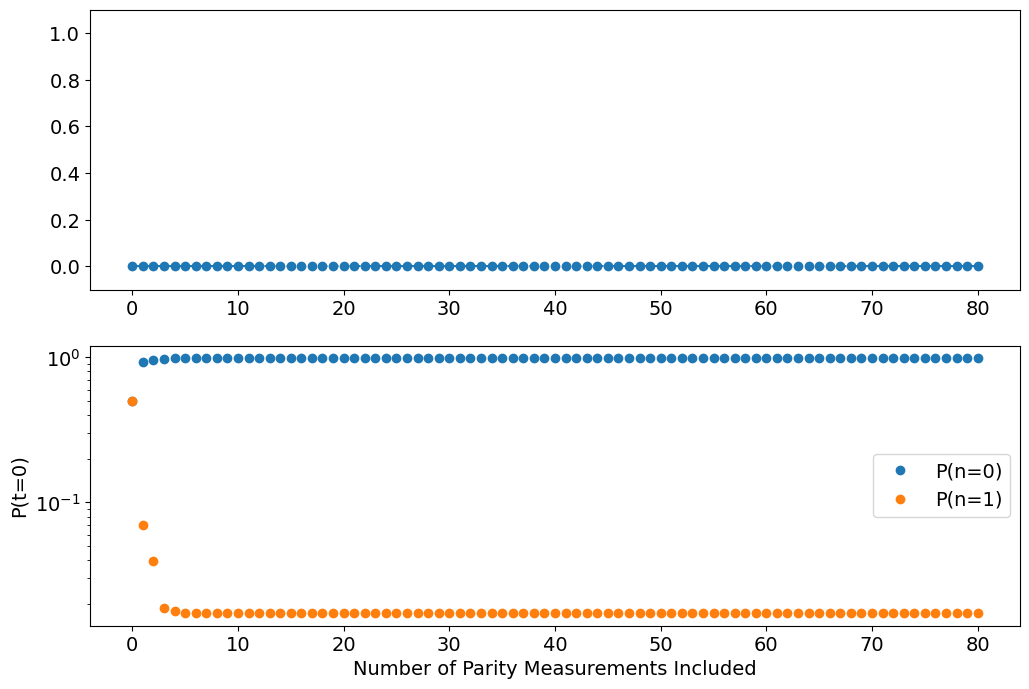

In [48]:
meas_sequence = bb[20000 -1]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # # pick off probability of cavitiy state at the beginning, 0 in the first index
    # # sum over qubit state probability, second index
    # P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    # P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

    gamma_first_row, dicty = wrapper_gamma(temp_meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = T, E = E)
    P0_first.append(gamma_first_row[0] + gamma_first_row[1])
    P1_first.append(gamma_first_row[2] + gamma_first_row[3])
figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [533]:
# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 10
calculating threshold: 50
calculating threshold: 100
calculating threshold: 500
calculating threshold: 1000
calculating threshold: 5000
calculating threshold: 10000
calculating threshold: 50000
calculating threshold: 100000
[12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092]


Text(0.5, 1.0, 'M1=|1>')

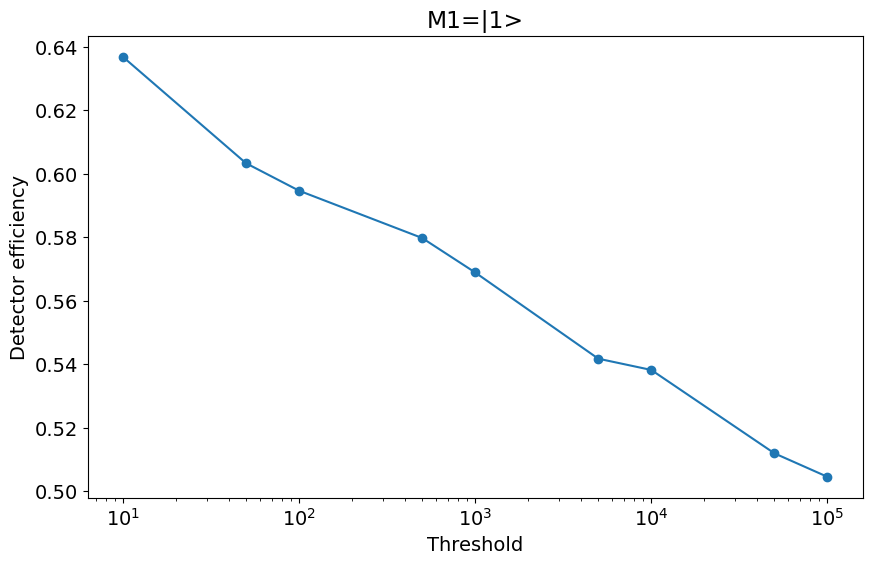

In [534]:
plt.plot(threshold_list, np.array(counts_list)/len(bb), 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Detector efficiency')
plt.title('M1=|1>')

### Actual Dark counts

In [546]:
temp_data, attrs = prev_data(expt_path, '00007_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

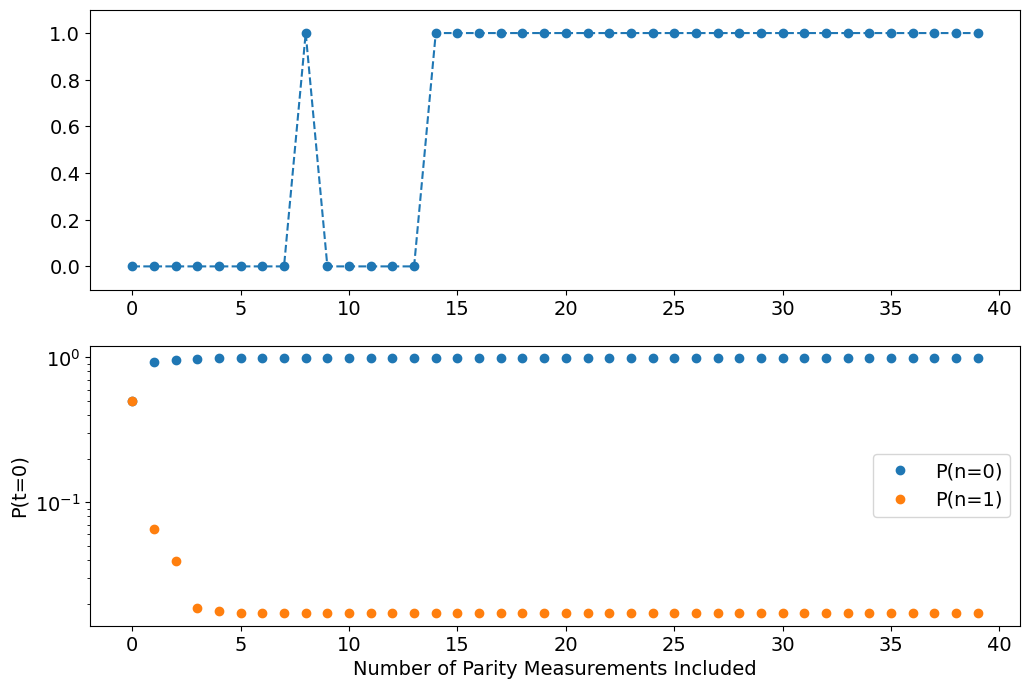

In [547]:
meas_sequence = bb[1600]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [538]:
# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 10
calculating threshold: 50
calculating threshold: 100
calculating threshold: 500
calculating threshold: 1000
calculating threshold: 5000
calculating threshold: 10000
calculating threshold: 50000
calculating threshold: 100000
[157, 131, 127, 117, 117, 104, 104, 89, 88]


Text(0.5, 1.0, 'Dark photon')

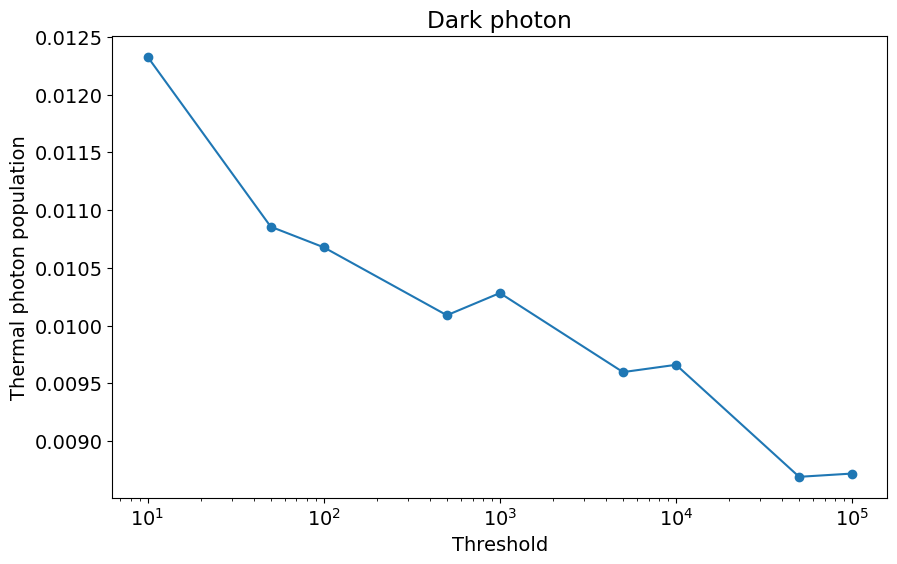

In [539]:
dark_counts = np.array([157, 131, 127, 117, 117, 104, 104, 89, 88])/20000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[i])

plt.plot(threshold_list, thermal_photon_population, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Thermal photon population')
plt.title('Dark photon')

Text(0, 0.5, 'M1 Temperature (mK)')

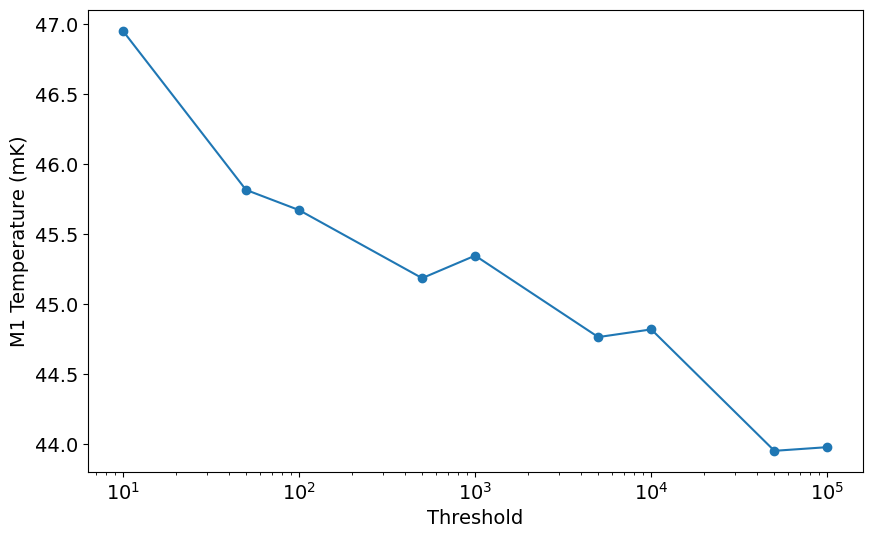

In [545]:
freq = 4.984
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
plt.plot(threshold_list, tempr, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('M1 Temperature (mK)')

In [548]:
# plot the function: efficiency vs threshold
threshold_list = [100000]
efficiency_list = np.array([10092])/20000
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 100000
[401]


In [549]:
dark_counts = np.array([401])/100000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[-1])

In [551]:
freq = 4.984
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
print(tempr)

[43.24443494250535]


## Storage without Active Reset


### Calculate Efficiency

In [27]:
# temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00110_cavity_temperature_sweep_parity_with_without_reset.h5')
# temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')

threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)
# threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
# orig_running_dict = running_dict.copy()

In [16]:
attrs['config']

{'prepulse_qubit': {'freq': [3568.1751638611518],
  'length': [0.06],
  'gain': [30],
  'phase': [0],
  'repeat_time': 10},
 'device': {'qubit': {'T1': [127.0],
   'f_ge': [3568.1515953227604],
   'f_ge_resolved': [3568.1515953227604],
   'f_ge_idle': [3568.1515953227604],
   'f_ef': [3425.5564066067],
   'f_ef_idle': [3425.5564066067],
   'ramp_sigma': [0.005],
   'ramp_sigma_num': [3],
   'pulses': {'pi_ge': {'gain': [10716],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_ftop': {'gain': [3000],
     'sigma': [0.005],
     'length': [0.190914187445986],
     'type': ['flat_top']},
    'pi_ge_fast': {'gain': [10682],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_resolved': {'gain': [50],
     'sigma': [0.005],
     'length': [6.553697146578866],
     'type': ['flat_top'],
     'repeat_no': [1]},
    'hpi_ge': {'gain': [5510],
     'length': [0],
     'sigma': [0.035],
     'type': ['gauss']},
    'hpi_ge_ftop': {'gain': 

In [28]:
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, orig_running_dict)

Processing: 100%|██████████| 200000/200000 [44:03<00:00, 75.67it/s] 


In [29]:
threshold_counts

[87849,
 85081,
 80145,
 77923,
 69796,
 67270,
 63299,
 61546,
 57782,
 56067,
 52828,
 50320,
 48423,
 45709,
 44360,
 41734,
 40287,
 38129,
 36227,
 32870,
 29905,
 27192,
 23475,
 18495,
 14353,
 11046,
 8310]

In [30]:
# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

In [8]:
dicty = {'keys':[], 'values':[]}

n =20000
for i in range(n):
    # express i in binary with 80 digits
    binary = format(i, '080b')
    dicty['keys'].append(binary)
    dicty['values'].append(1)



In [12]:
string =  format(10000, '080b')
if string in dicty['keys']:
    print('yes')

yes


In [7]:
format(20000, '080b')

'00000000000000000000000000000000000000000000000000000000000000000100111000100000'

#### Looking at maximal attainable threshold

In [1014]:
temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

In [72]:

full_meas_sequence = bb[1000]

def find_probs_for_sequence(full_meas_sequence):
    '''
    Given a measurement record, compute the probabilities of 0 or 1 photon initially for each subset of the record
    '''
    P0_list = []
    P1_list = []
    for ii in range (len(full_meas_sequence)):
        meas_sequence = full_meas_sequence[0:ii + 1]
        gamma_first_row = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        P0_list.append(P0)
        P1_list.append(P1)
    return P0_list, P1_list

P0_list, P1_list = find_probs_for_sequence(full_meas_sequence)
    

# # plot the P0 and P1 probabilities
# figure(figsize = (12,8))

# # plot measurement record
# subplot(2,1,1)
# plot(meas_sequence, 'o--')
# ylim(-0.1, 1.1)

# # plot reconstructed probabilities for subsets of the measurement record
# subplot(2,1,2)
# semilogy(P0_list, 'o', label= "P(n=0)")
# semilogy(P1_list, 'o', label= "P(n=1)")
# #         axhline(1e-9)
# #         plot(P0_first, 'o', label= "P(n=0)")
# #         plot(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-8)
# #         ylim(1e-16,1e0)
# ylabel('P(t=0)')
# xlabel('Number of Parity Measurements Included')
# title('Looking at a measurement sequence to get max threshold')
# legend()
# tight_layout

0it [00:00, ?it/s]C:\Users\26049\AppData\Local\Temp\ipykernel_24012\3479883377.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
3it [00:06,  2.09s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

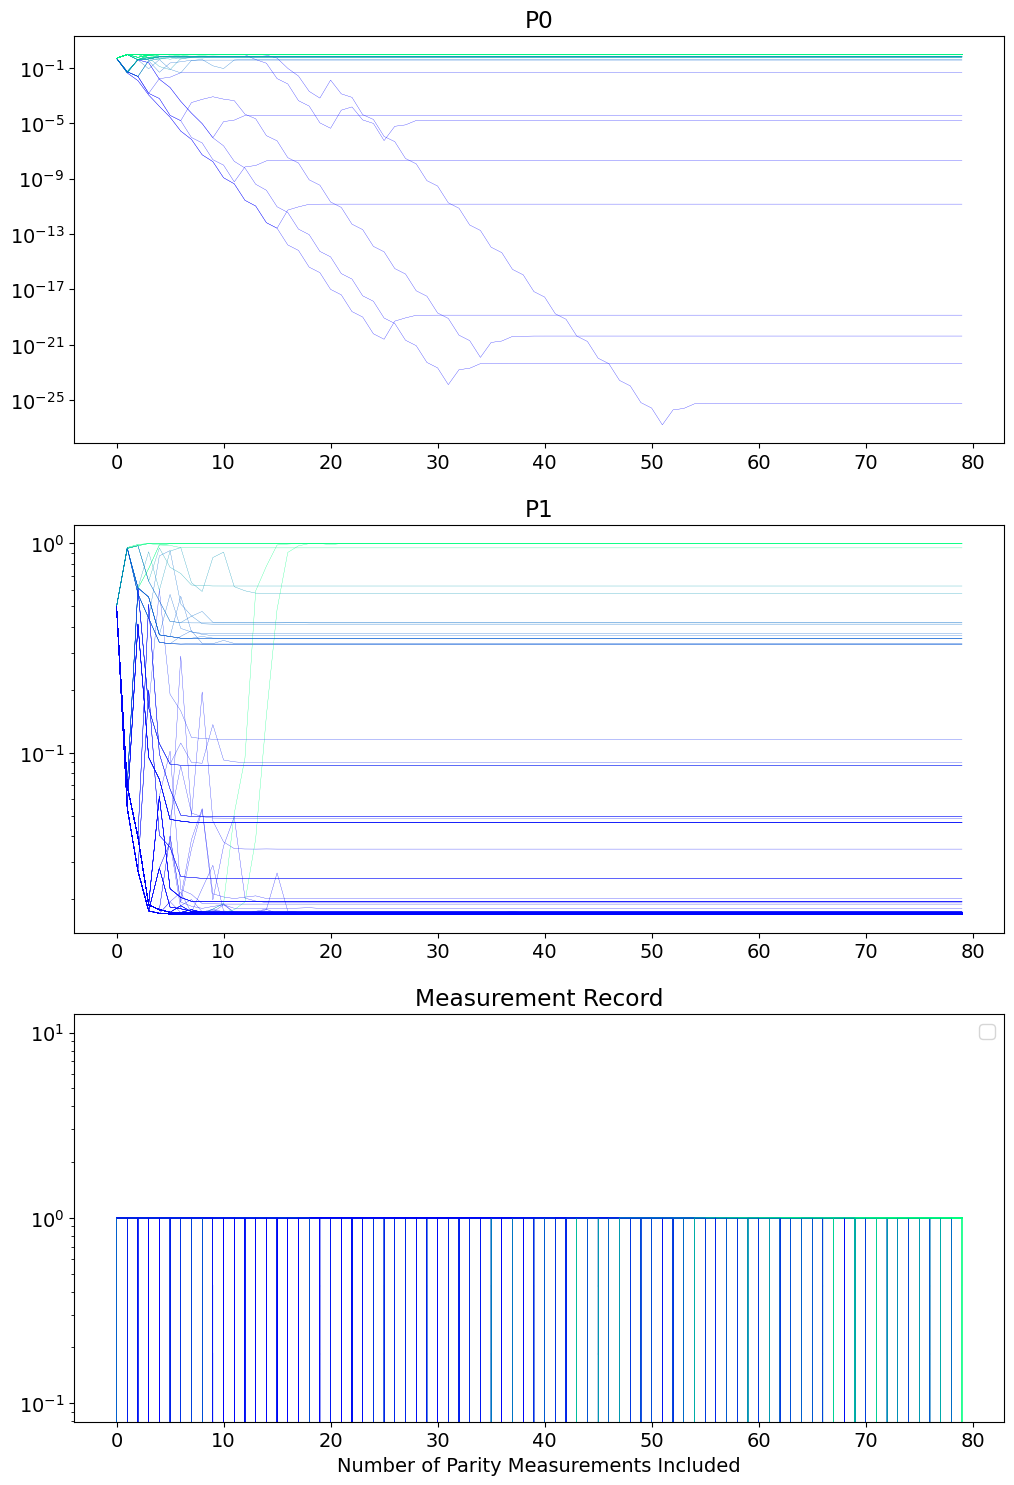

In [1018]:
temp_data, attrs = prev_data(expt_path, '00058_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

meas_sequences = bb[0:20000: 20]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

xlists = [P0_lists, P1_lists, meas_sequences]
axs = [ax1, ax2, ax3]
titles = ['P0', 'P1', 'Measurement Record']
mins = [1e-20, 1e-5, 0 ]

for xlist, ax, title, min_ in tqdm(zip(xlists, axs, titles, mins)):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

In [ ]:
def plot_fidelities(self, timestamp=None, fig=None, ax=None, log=True, **kwargs):
        fidelities = self.fidelities(timestamp).T
        fig = fig if fig is not None else plt.figure(figsize=(3.5, 2.25), dpi=200)
        ax = ax if ax is not None else fig.subplots()
        end_fids = fidelities[:, -1]
        indxs = np.argsort(end_fids)
        fidelities = fidelities[indxs]
        for fids in fidelities[:-1]:
            import matplotlib

            norm = matplotlib.colors.Normalize(
                vmin=np.log10(1 - fidelities[-1][-1]), vmax=0
            )
            cmap = matplotlib.cm.get_cmap("winter")
            color = cmap(norm(np.log10(1 - fids[-1])))
            if log:
                ax.semilogy(
                    1 - fids, "-", linewidth=0.2, alpha=1, color=color, **kwargs
                )
            else:
                ax.plot(fids, "-", linewidth=0.5, **kwargs)
        color = cmap(norm(np.log10(1 - fidelities[-1][-1])))
        if log:
            ax.semilogy(1 - fidelities[-1], linewidth=1, color=color, **kwargs)
        else:
            ax.plot(fidelities[-1], **kwargs)

        # ax.set_xlabel("epoch", size=8)
        # if log:
        #    ax.set_ylabel("infidelity", size=8)
        # else:
        #    ax.set_ylabel("fidelity", size=8)
        fig.tight_layout()

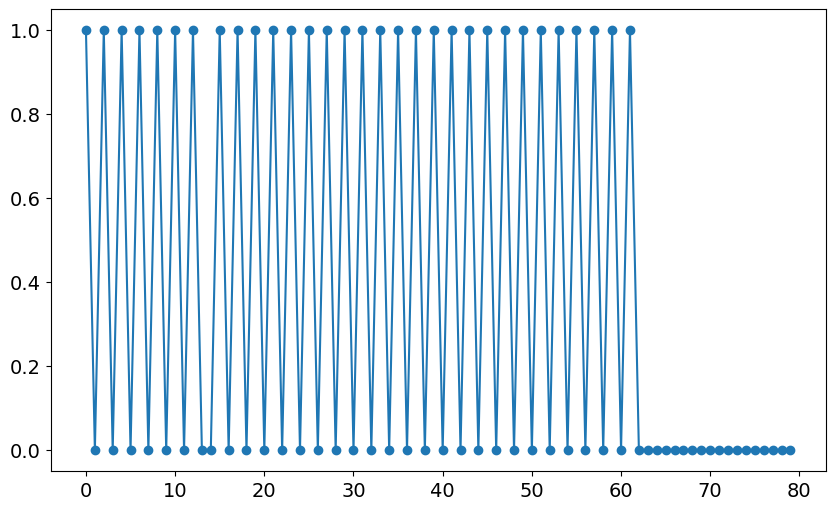

In [93]:
plt.plot(meas_sequences[200], '-o')

In [94]:
meas_sequences[200]

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Now computing efficiency

In [31]:
attrs['config']['expt'] 

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 200000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 80}

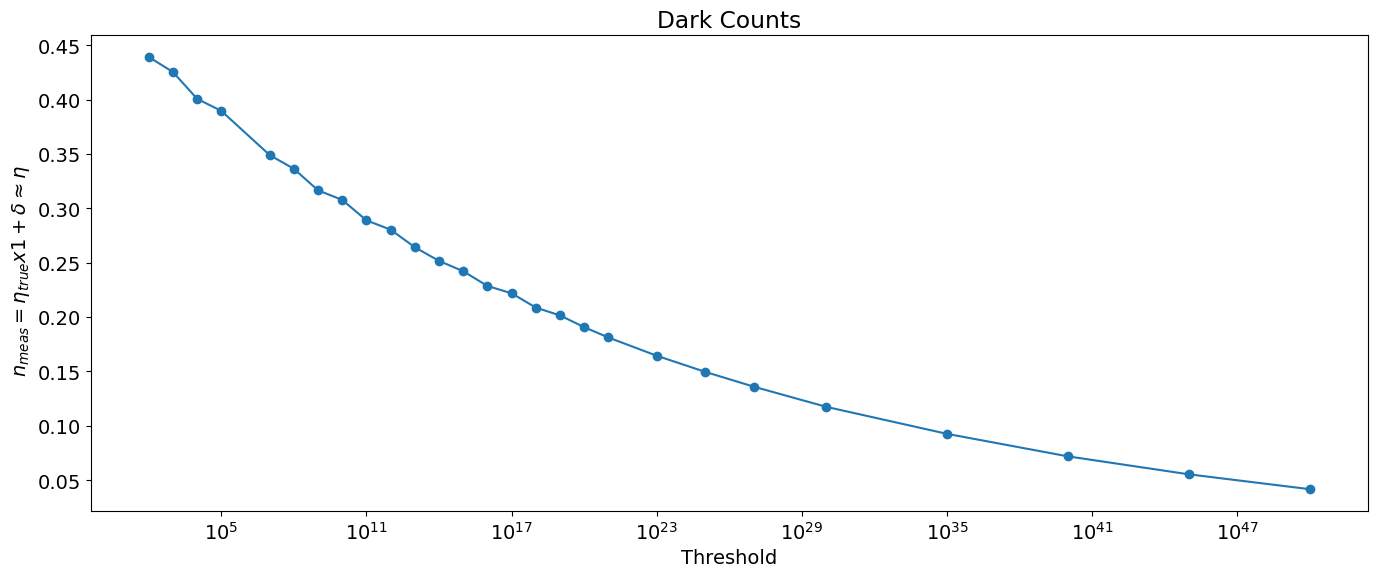

In [32]:
n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [33]:
efficiency_list = np.array(threshold_counts) /attrs['config']['expt']['reps']

In [34]:
efficiency_list 

array([0.439245, 0.425405, 0.400725, 0.389615, 0.34898 , 0.33635 ,
       0.316495, 0.30773 , 0.28891 , 0.280335, 0.26414 , 0.2516  ,
       0.242115, 0.228545, 0.2218  , 0.20867 , 0.201435, 0.190645,
       0.181135, 0.16435 , 0.149525, 0.13596 , 0.117375, 0.092475,
       0.071765, 0.05523 , 0.04155 ])

Text(0, 0.5, 'Dark Counts')

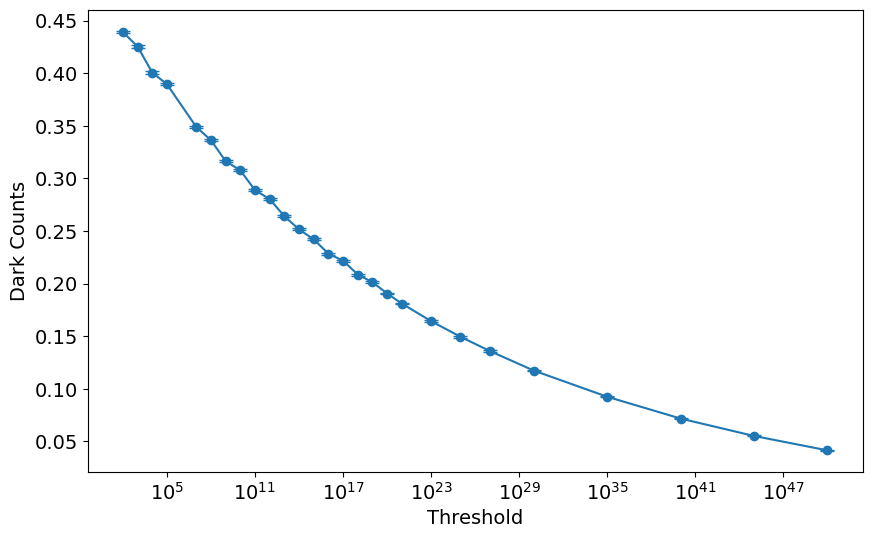

In [35]:
dark_counts =  efficiency_list
# standard error from binomial distribution sqrt(p(1-p)/n)
probs = efficiency_list 
n = attrs['config']['expt']['reps']
efficiency_list_err = np.sqrt(probs*(1-probs)/n)
# dark_counts_err = np.sqrt(dark_counts )
# efficiency_list_err = dark_counts_err/1e5

# plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.errorbar(full_threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Dark Counts')

In [36]:
efficiency_list_err

array([0.00110975, 0.00110552, 0.00109577, 0.00109045, 0.00106582,
       0.00105645, 0.00104001, 0.00103207, 0.00101351, 0.00100436,
       0.00098582, 0.0009703 , 0.00095785, 0.00093891, 0.00092899,
       0.00090864, 0.00089682, 0.00087835, 0.00086118, 0.00082867,
       0.00079739, 0.0007664 , 0.00071972, 0.00064778, 0.00057713,
       0.00051078, 0.00044623])

In [831]:
# efficiency_list = [0.6611 , 0.63235, 0.62515, 0.61114, 0.60217, 0.57661, 0.57405,
#        0.54543, 0.53883, 0.49583, 0.49091, 0.4786 , 0.46403, 0.45069,
#        0.44733]

### Use above efficiency to calculate temperature for M1
This is really the efficiency-normalized false positive  probability for M1

In [79]:
# temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00015_ParityTempExperiment.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

threshold_counts, m1_running_dict = compute_threshold_counts(bb, full_threshold_list)#, m1_running_dict)


Processing:   0%|          | 0/100000 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

#### Measurement record analsysi

C:\Users\26049\AppData\Local\Temp\ipykernel_24012\1498363134.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

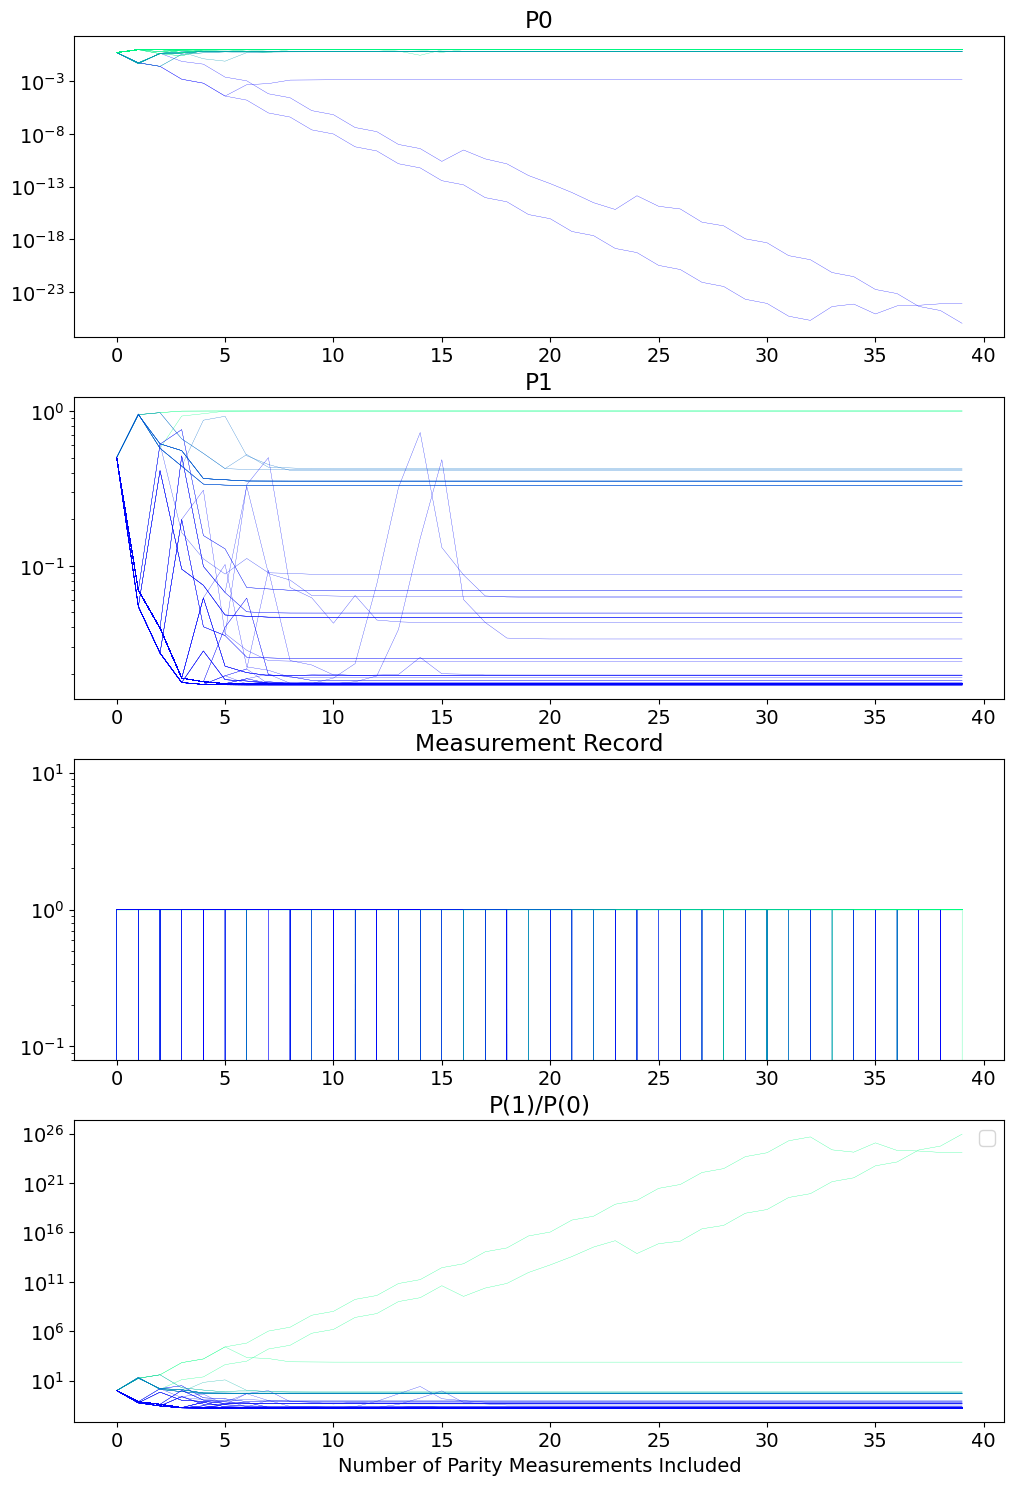

In [964]:
temp_data, attrs = prev_data(expt_path, '00008_cavity_temperature_sweep_parity.h5')
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=40)

meas_sequences = bb[0:10000: 20]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [P0_lists, P1_lists, meas_sequences, ratio_list]
axs = [ax1, ax2, ax3, ax4]
titles = ['P0', 'P1', 'Measurement Record', 'P(1)/P(0)']
mins = [1e-20, 1e-20, 0 , 1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\2593989401.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

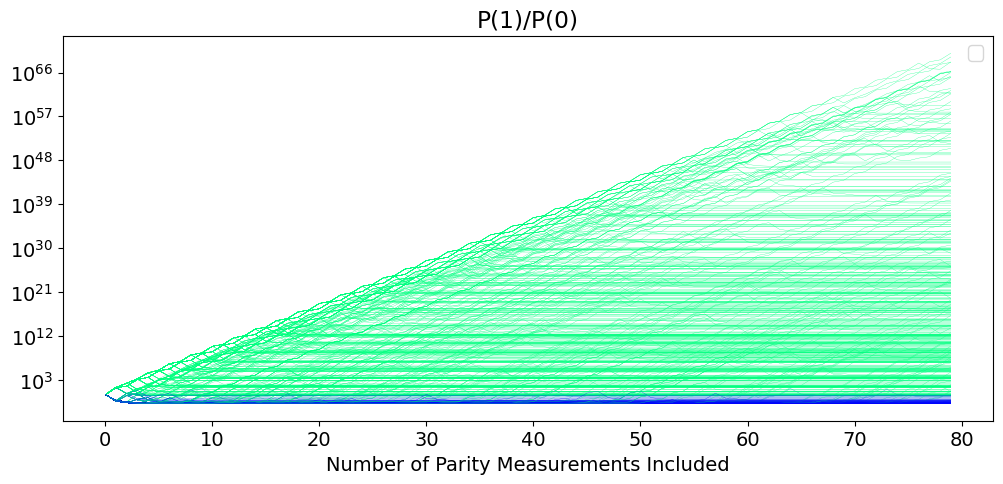

In [81]:
temp_data, attrs = prev_data(expt_path, '00110_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[0:10000: 10]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists.npy', P1_lists)
np.save('p0_lists.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\4055057483.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

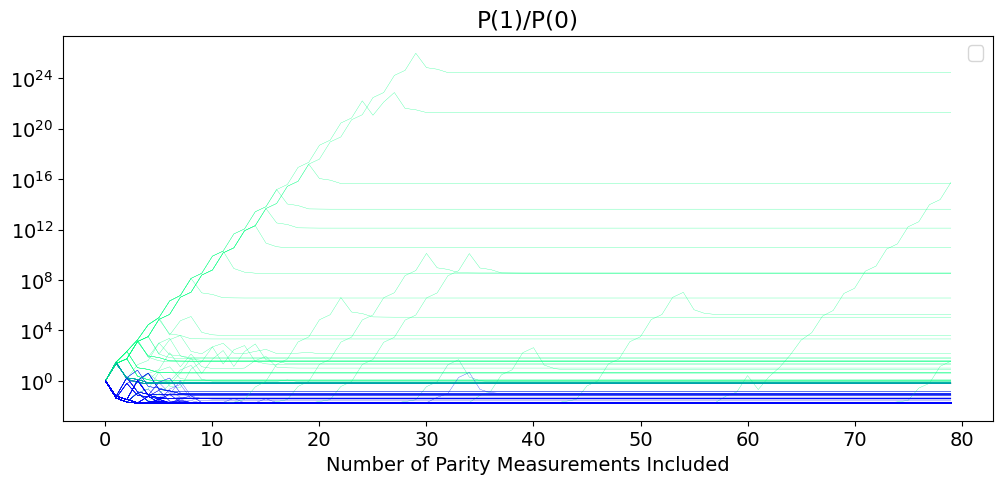

In [80]:
temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[0:10000: 5]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists2.npy', P1_lists)
np.save('p0_lists2.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

#### Back to temp calculation

In [78]:
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]

In [38]:
threshold_counts

[1657,
 1533,
 1360,
 1298,
 1070,
 1006,
 899,
 859,
 762,
 721,
 666,
 614,
 579,
 526,
 497,
 454,
 426,
 376,
 342,
 290,
 241,
 198,
 155,
 115,
 79,
 50,
 31]

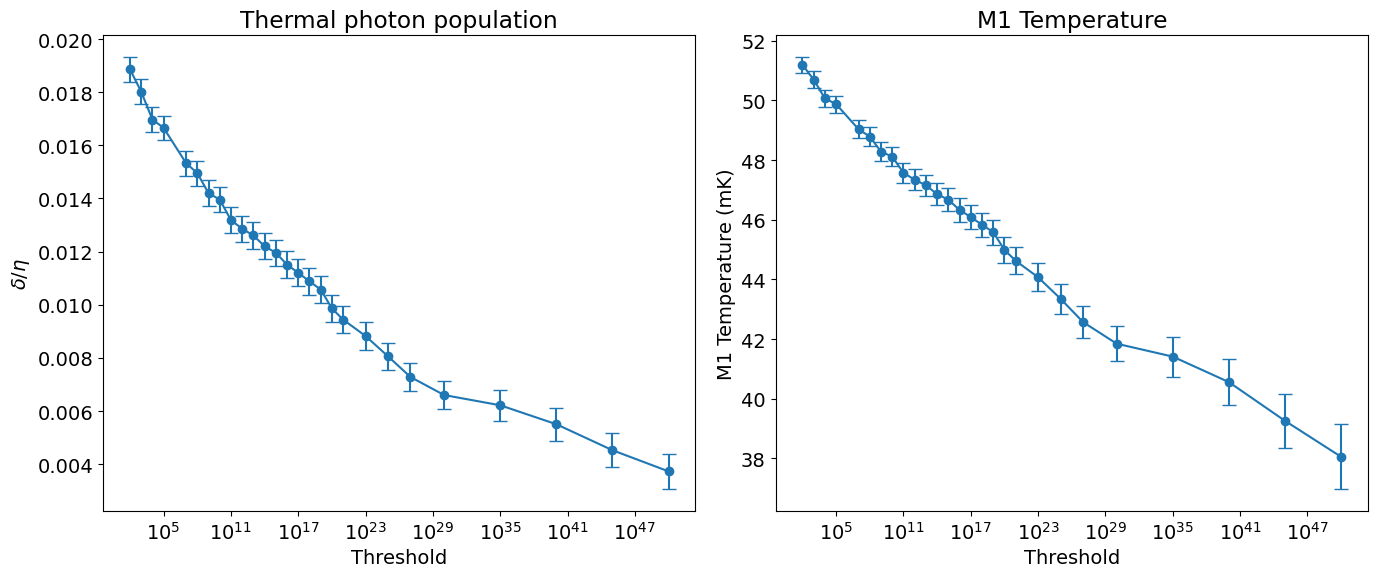

In [39]:
start_idx = 0
end_idx =  None

n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 #+1.4

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp = 48 * frequency / (np.log(1 + 1 / now[i]))
    temp_err = np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr.append(temp)
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [1066]:
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 20000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[944.25],
  [1000],
  [0.316677658],
  [0],
  [1],
  ['flat_top'],
  [0.005]],
 'readout_no_placeholder': 80}

In [921]:
i = 5
temp = 48 * frequency / (np.log(1 + 1 / now[i]))
np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))

0.4443015985375665

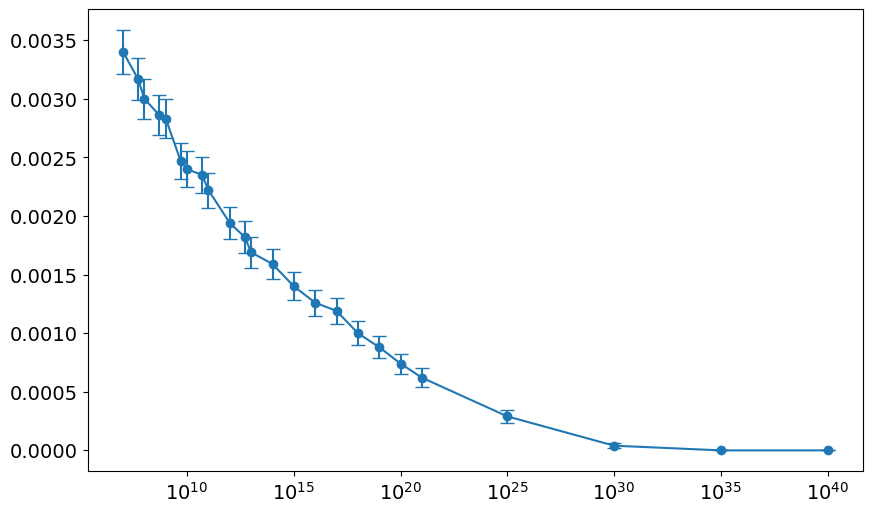

In [962]:
plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.xscale('log')

In [920]:
temp

40.922135993882144

In [915]:
i = -10
thermal_photon_population[i] * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)

0.0003759365748738378

In [918]:
0.0003/(0.003

33.33333333333333

In [906]:
dark_counts[-3]

4e-05

In [911]:
thermal_photon_population_err[i]

0.00036647106255566675

#### Dataframe to save M1 with and without |1> data

In [49]:
columns = ['file_name', 'mode', 'T', 'E', 'threshold_list', 'counts_list', 'man_no_for_parity', 'reset', 'single_photon']
df = pd.DataFrame(columns=columns)

modes = ['M1', 'M2', 'M1', 'M1-S1', 'M1-S2', 'M1-S3', 'M1-S4', 'M1-S5', 'M1-S6', 'M1-S7', 'M1-D1', 'M1-C',
                'M2', 'M2-D2'] * 2
file_no_start = 110

for idx, mode in enumerate(modes): 
    # add row to dataframe
    file_no = int(file_no_start + idx)
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')
    reset = attrs['config']['expt']['active_reset']

    prepulse_len = 0
    if attrs['config']['expt']['prepulse']:
        prepulse_len = len(attrs['config']['expt']['pre_sweep_pulse'][0])

    single_photon = False
    if prepulse_len >1: 
        single_photon = True
    file_no = int(file_no_start + idx)

    df.loc[idx] = [f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5', mode, T, E, [0 for i in range(len(full_threshold_list))], [0 for i in range(len(full_threshold_list))], attrs['config']['expt']['man_no'], reset, single_photon]   
    print(f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')

df


00110_cavity_temperature_sweep_parity_with_without_reset.h5
00111_cavity_temperature_sweep_parity_with_without_reset.h5
00112_cavity_temperature_sweep_parity_with_without_reset.h5
00113_cavity_temperature_sweep_parity_with_without_reset.h5
00114_cavity_temperature_sweep_parity_with_without_reset.h5
00115_cavity_temperature_sweep_parity_with_without_reset.h5
00116_cavity_temperature_sweep_parity_with_without_reset.h5
00117_cavity_temperature_sweep_parity_with_without_reset.h5
00118_cavity_temperature_sweep_parity_with_without_reset.h5
00119_cavity_temperature_sweep_parity_with_without_reset.h5
00120_cavity_temperature_sweep_parity_with_without_reset.h5
00121_cavity_temperature_sweep_parity_with_without_reset.h5
00122_cavity_temperature_sweep_parity_with_without_reset.h5
00123_cavity_temperature_sweep_parity_with_without_reset.h5
00124_cavity_temperature_sweep_parity_with_without_reset.h5
00125_cavity_temperature_sweep_parity_with_without_reset.h5
00126_cavity_temperature_sweep_parity_wi

file_name   mode  \
0   00110_cavity_temperature_sweep_parity_with_wit...     M1   
1   00111_cavity_temperature_sweep_parity_with_wit...     M2   
2   00112_cavity_temperature_sweep_parity_with_wit...     M1   
3   00113_cavity_temperature_sweep_parity_with_wit...  M1-S1   
4   00114_cavity_temperature_sweep_parity_with_wit...  M1-S2   
5   00115_cavity_temperature_sweep_parity_with_wit...  M1-S3   
6   00116_cavity_temperature_sweep_parity_with_wit...  M1-S4   
7   00117_cavity_temperature_sweep_parity_with_wit...  M1-S5   
8   00118_cavity_temperature_sweep_parity_with_wit...  M1-S6   
9   00119_cavity_temperature_sweep_parity_with_wit...  M1-S7   
10  00120_cavity_temperature_sweep_parity_with_wit...  M1-D1   
11  00121_cavity_temperature_sweep_parity_with_wit...   M1-C   
12  00122_cavity_temperature_sweep_parity_with_wit...     M2   
13  00123_cavity_temperature_sweep_parity_with_wit...  M2-D2   
14  00124_cavity_temperature_sweep_parity_with_wit...     M1   
15  00125_cavity_temperature_sweep_parity_with_wit...     M2   
16  00126_cavity_temperature_sweep_parity_with_wit...     M1   
17  00127_cavity_temperature_sweep_parity_with_wit...  M1-S1   
18  00128_cavity_temperature_sweep_parity_with_wit...  M1-S2   
19  00129_cavity_temperature_sweep_parity_with_wit...  M1-S3   
20  00130_cavity_temperature_sweep_parity_with_wit...  M1-S4   
21  00131_cavity_temperature_sweep_parity_with_wit...  M1-S5   
22  00132_cavity_temperature_sweep_parity_with_wit...  M1-S6   
23  00133_cavity_temperature_sweep_parity_with_wit...  M1-S7   
24  00134_cavity_temperature_sweep_parity_with_wit...  M1-D1   
25  00135_cavity_temperature_sweep_parity_with_wit...   M1-C   
26  00136_cavity_temperature_sweep_parity_with_wit...     M2   
27  00137_cavity_temperature_sweep_parity_with_wit...  M2-D2   

                                                    T  \
0   [[0.9885400581248439, 0.011459941875156051, 0....   
1   [[0.9885400581248439, 0.011459941875156051, 0....   
2   [[0.9885400581248439, 0.011459941875156051, 0....   
3   [[0.9885400581248439, 0.011459941875156051, 0....   
4   [[0.9885400581248439, 0.011459941875156051, 0....   
5   [[0.9885400581248439, 0.011459941875156051, 0....   
6   [[0.9885400581248439, 0.011459941875156051, 0....   
7   [[0.9885400581248439, 0.011459941875156051, 0....   
8   [[0.9885400581248439, 0.011459941875156051, 0....   
9   [[0.9885400581248439, 0.011459941875156051, 0....   
10  [[0.9885400581248439, 0.011459941875156051, 0....   
11  [[0.9885400581248439, 0.011459941875156051, 0....   
12  [[0.9885400581248439, 0.011459941875156051, 0....   
13  [[0.9885400581248439, 0.011459941875156051, 0....   
14  [[0.9885400581248439, 0.011459941875156051, 0....   
15  [[0.9885400581248439, 0.011459941875156051, 0....   
16  [[0.9885400581248439, 0.011459941875156051, 0....   
17  [[0.9885400581248439, 0.011459941875156051, 0....   
18  [[0.9885400581248439, 0.011459941875156051, 0....   
19  [[0.9885400581248439, 0.011459941875156051, 0....   
20  [[0.9885400581248439, 0.011459941875156051, 0....   
21  [[0.9885400581248439, 0.011459941875156051, 0....   
22  [[0.9885400581248439, 0.011459941875156051, 0....   
23  [[0.9885400581248439, 0.011459941875156051, 0....   
24  [[0.9885400581248439, 0.011459941875156051, 0....   
25  [[0.9885400581248439, 0.011459941875156051, 0....   
26  [[0.9885400581248439, 0.011459941875156051, 0....   
27  [[0.9885400581248439, 0.011459941875156051, 0....   

                                                    E  \
0   [[0.4983785974868261, 0.0016214025131738863], ...   
1   [[0.4983785974868261, 0.0016214025131738863], ...   
2   [[0.4983785974868261, 0.0016214025131738863], ...   
3   [[0.4983785974868261, 0.0016214025131738863], ...   
4   [[0.4983785974868261, 0.0016214025131738863], ...   
5   [[0.4983785974868261, 0.0016214025131738863], ...   
6   [[0.4983785974868261, 0.0016214025131738863], ...   
7   [[0.4983785974868261, 0.0016214025131738863], ...   
8   [[0.498378597486

In [54]:
df[ 'threshold_list'][0] = list(full_threshold_list)
df[ 'counts_list'][0] = list(efficiency_list * attrs['config']['expt']['reps'])
df[ 'threshold_list'][2] = list(full_threshold_list)
df[ 'counts_list'][2] = list(threshold_counts)

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'threshold_list'][0] = list(full_threshold_list)
C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'counts_list'][0] = list(efficiency_list * attrs['config']['expt']['reps'])
C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [55]:
df

file_name   mode  \
0   00110_cavity_temperature_sweep_parity_with_wit...     M1   
1   00111_cavity_temperature_sweep_parity_with_wit...     M2   
2   00112_cavity_temperature_sweep_parity_with_wit...     M1   
3   00113_cavity_temperature_sweep_parity_with_wit...  M1-S1   
4   00114_cavity_temperature_sweep_parity_with_wit...  M1-S2   
5   00115_cavity_temperature_sweep_parity_with_wit...  M1-S3   
6   00116_cavity_temperature_sweep_parity_with_wit...  M1-S4   
7   00117_cavity_temperature_sweep_parity_with_wit...  M1-S5   
8   00118_cavity_temperature_sweep_parity_with_wit...  M1-S6   
9   00119_cavity_temperature_sweep_parity_with_wit...  M1-S7   
10  00120_cavity_temperature_sweep_parity_with_wit...  M1-D1   
11  00121_cavity_temperature_sweep_parity_with_wit...   M1-C   
12  00122_cavity_temperature_sweep_parity_with_wit...     M2   
13  00123_cavity_temperature_sweep_parity_with_wit...  M2-D2   
14  00124_cavity_temperature_sweep_parity_with_wit...     M1   
15  00125_cavity_temperature_sweep_parity_with_wit...     M2   
16  00126_cavity_temperature_sweep_parity_with_wit...     M1   
17  00127_cavity_temperature_sweep_parity_with_wit...  M1-S1   
18  00128_cavity_temperature_sweep_parity_with_wit...  M1-S2   
19  00129_cavity_temperature_sweep_parity_with_wit...  M1-S3   
20  00130_cavity_temperature_sweep_parity_with_wit...  M1-S4   
21  00131_cavity_temperature_sweep_parity_with_wit...  M1-S5   
22  00132_cavity_temperature_sweep_parity_with_wit...  M1-S6   
23  00133_cavity_temperature_sweep_parity_with_wit...  M1-S7   
24  00134_cavity_temperature_sweep_parity_with_wit...  M1-D1   
25  00135_cavity_temperature_sweep_parity_with_wit...   M1-C   
26  00136_cavity_temperature_sweep_parity_with_wit...     M2   
27  00137_cavity_temperature_sweep_parity_with_wit...  M2-D2   

                                                    T  \
0   [[0.9885400581248439, 0.011459941875156051, 0....   
1   [[0.9885400581248439, 0.011459941875156051, 0....   
2   [[0.9885400581248439, 0.011459941875156051, 0....   
3   [[0.9885400581248439, 0.011459941875156051, 0....   
4   [[0.9885400581248439, 0.011459941875156051, 0....   
5   [[0.9885400581248439, 0.011459941875156051, 0....   
6   [[0.9885400581248439, 0.011459941875156051, 0....   
7   [[0.9885400581248439, 0.011459941875156051, 0....   
8   [[0.9885400581248439, 0.011459941875156051, 0....   
9   [[0.9885400581248439, 0.011459941875156051, 0....   
10  [[0.9885400581248439, 0.011459941875156051, 0....   
11  [[0.9885400581248439, 0.011459941875156051, 0....   
12  [[0.9885400581248439, 0.011459941875156051, 0....   
13  [[0.9885400581248439, 0.011459941875156051, 0....   
14  [[0.9885400581248439, 0.011459941875156051, 0....   
15  [[0.9885400581248439, 0.011459941875156051, 0....   
16  [[0.9885400581248439, 0.011459941875156051, 0....   
17  [[0.9885400581248439, 0.011459941875156051, 0....   
18  [[0.9885400581248439, 0.011459941875156051, 0....   
19  [[0.9885400581248439, 0.011459941875156051, 0....   
20  [[0.9885400581248439, 0.011459941875156051, 0....   
21  [[0.9885400581248439, 0.011459941875156051, 0....   
22  [[0.9885400581248439, 0.011459941875156051, 0....   
23  [[0.9885400581248439, 0.011459941875156051, 0....   
24  [[0.9885400581248439, 0.011459941875156051, 0....   
25  [[0.9885400581248439, 0.011459941875156051, 0....   
26  [[0.9885400581248439, 0.011459941875156051, 0....   
27  [[0.9885400581248439, 0.011459941875156051, 0....   

                                                    E  \
0   [[0.4983785974868261, 0.0016214025131738863], ...   
1   [[0.4983785974868261, 0.0016214025131738863], ...   
2   [[0.4983785974868261, 0.0016214025131738863], ...   
3   [[0.4983785974868261, 0.0016214025131738863], ...   
4   [[0.4983785974868261, 0.0016214025131738863], ...   
5   [[0.4983785974868261, 0.0016214025131738863], ...   
6   [[0.4983785974868261, 0.0016214025131738863], ...   
7   [[0.4983785974868261, 0.0016214025131738863], ...   
8   [[0.498378597486

#### Save dataframe 

In [56]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity.csv'
file_path = os.path.join(folder, file_name)

# Ensure the directory exists
os.makedirs(folder, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to H:\Shared drives\SLab\Multimode\experiment\240911\RAM_paper_results\datasets\Cavity_Temp_Parity.csv


Procedure: 

1. Load single photon in M1 and perform N = 40 repeated parity measurements (total of N = 1e5 shots). These parameters set the maximum threshold to be $\lambda_{max} \approx 10^{20}$

2. Through Hidden Markov Analysis, we find the number of photons measured $n_{meas}$ for a range of thresholds $\lambda$ . Given the equation $$n_{meas} (\lambda) = \eta_{true} (\lambda) \times 1 \text{photon injected} + \delta (\lambda) \approx \eta(\lambda)$$, we compute get efficiencies for each threshold $\eta(\lambda)$. Here we drop the false positive probability $\delta < 0.01 <<\eta_{true}$ since it is small compared to the true efficiency. 

3. To calculate mode temperature, we repeat step 1 with no injected photon. We find the thermal photons by normalizing the false positive probability $\delta$ with the efficiency $\eta(\lambda)$
$$ n_{thermal} (\lambda) = n_{meas}(\lambda) / \eta(\lambda) = \delta(\lambda) / \eta(\lambda)$$




### Use above efficiencies to calculate for all modes

In [850]:
file_no_list = np.arange(13, 20, 1)
mode_labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
# threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

threshold_counts_list = []
current_running_dict = m1_running_dict
for file_no in file_no_list:
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
    aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)
    threshold_counts, current_running_dict = compute_threshold_counts(bb, full_threshold_list, current_running_dict)
    threshold_counts_list.append(threshold_counts)



Processing: 100%|██████████| 100000/100000 [02:42<00:00, 614.63it/s]


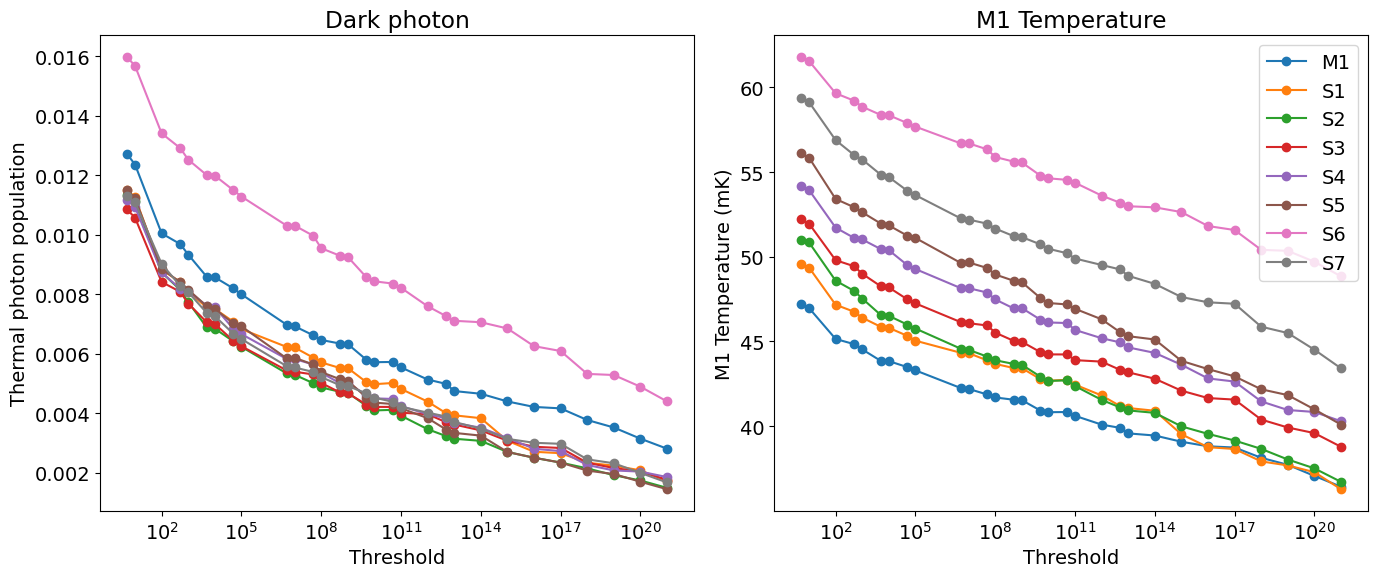

In [852]:
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925]) * 1e-3)
# efficiency_list = np.array(efficiency_list) * 1e-5#np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, full_threshold_list, frequencies, mode_labels)

In [714]:
frequencies

array([4.98    , 5.32941 , 5.50093 , 5.67666 , 5.85583 , 6.03342 ,
       6.22518 , 6.402925])

## Storage with Active Reset


### Calculate Efficiency

In [853]:
temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')
attrs['config']['device']['readout']['threshold']

[-64.47477176210509]

In [854]:
temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=40)
threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
active_reset_running_dict = running_dict.copy()

Processing: 100%|██████████| 107500/107500 [24:34<00:00, 72.93it/s] 


In [855]:
full_threshold_list = [ 5, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e12, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, active_reset_running_dict)

Processing: 100%|██████████| 107500/107500 [23:14<00:00, 77.10it/s] 


In [856]:
# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

#### Looking at maximal attainable threshold

In [ ]:
temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

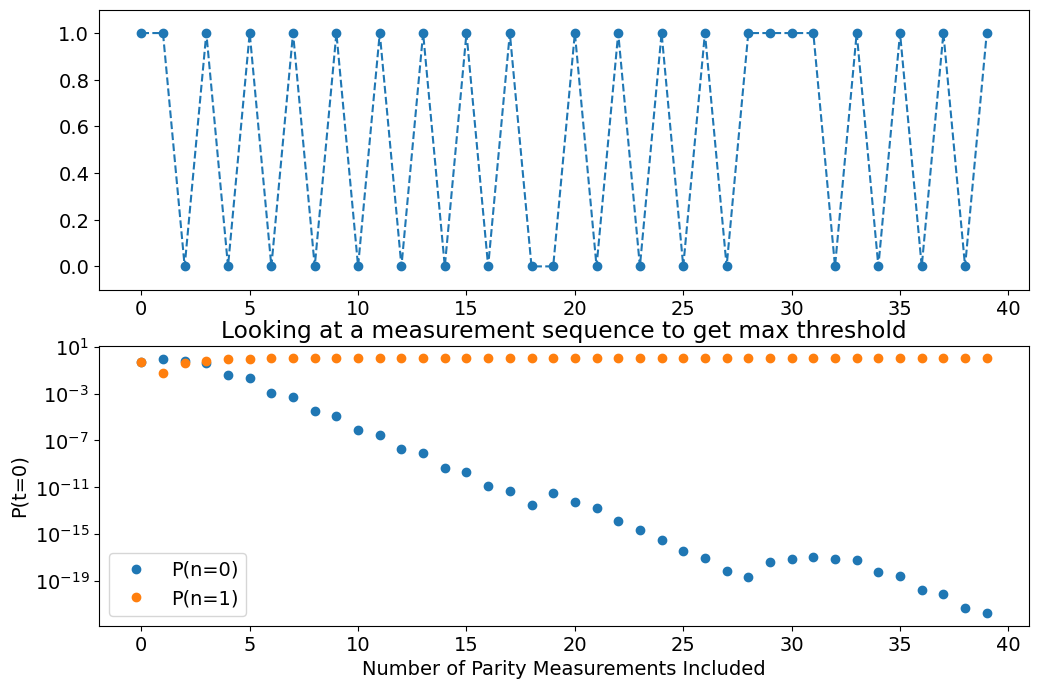

In [ ]:
P0_list = []
P1_list = []
full_meas_sequence = bb[80000]

for ii in range (len(full_meas_sequence)):
    meas_sequence = full_meas_sequence[0:ii + 1]
    gamma_first_row = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
    P0 = gamma_first_row[0] + gamma_first_row[1]
    P1 = gamma_first_row[2] + gamma_first_row[3]
    P0_list.append(P0)
    P1_list.append(P1)

# plot the P0 and P1 probabilities
figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_list, 'o', label= "P(n=0)")
semilogy(P1_list, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

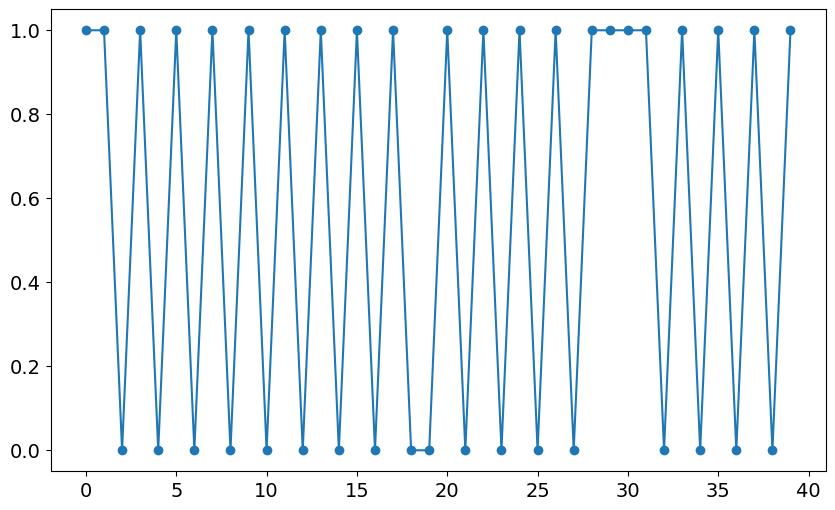

In [ ]:
plt.plot(bb[80000], '-o')

#### Now computing efficiency

In [857]:
attrs['config']['expt'] 

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 40,
 'ramsey_freq': 0.0,
 'reps': 100000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': True,
 'man_reset': True,
 'storage_reset': True,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 40}

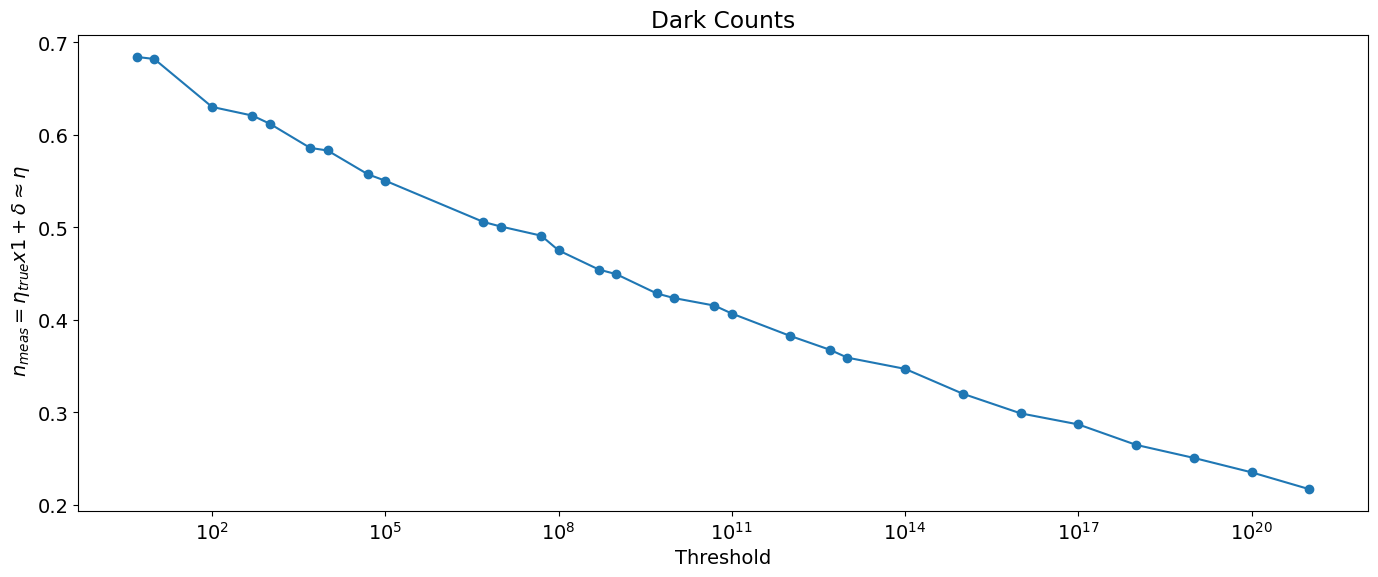

In [858]:
dark_counts = np.array(threshold_counts) / 1e5

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [859]:
efficiency_list = np.array(threshold_counts) * 1e-5

In [860]:
efficiency_list 

array([0.68422, 0.68201, 0.63019, 0.62082, 0.61202, 0.58586, 0.58308,
       0.55731, 0.55039, 0.50581, 0.50087, 0.49098, 0.47506, 0.45429,
       0.44933, 0.42851, 0.42349, 0.41536, 0.40676, 0.38281, 0.36757,
       0.35908, 0.34694, 0.32004, 0.29885, 0.28687, 0.26476, 0.25065,
       0.23505, 0.21682])

In [ ]:
# efficiency_list = [0.6611 , 0.63235, 0.62515, 0.61114, 0.60217, 0.57661, 0.57405,
#        0.54543, 0.53883, 0.49583, 0.49091, 0.4786 , 0.46403, 0.45069,
#        0.44733]

### Use above efficiency to calculate temperature for M1
This is really the efficiency-normalized false positive  probability for M1

In [1098]:
file_no = 6
temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold =  attrs['config']['device']['readout']['threshold'][0],
                              readouts_per_rep=40)
threshold_counts, m1_running_dict = compute_threshold_counts(bb, full_threshold_list, m1_running_dict)


Processing: 100%|██████████| 107500/107500 [05:47<00:00, 309.62it/s]


In [1096]:
full_threshold_list

(10000000.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0,
 10000000000.0,
 50000000000.0,
 100000000000.0,
 1000000000000.0,
 5000000000000.0,
 10000000000000.0,
 100000000000000.0,
 1000000000000000.0,
 1e+16,
 1e+17,
 1e+18,
 1e+19,
 1e+20,
 1e+21,
 1e+25,
 1e+30,
 1e+35,
 1e+40,
 1e+45,
 1e+50)

In [1099]:
threshold_counts

[1277,
 1199,
 1153,
 1074,
 1064,
 952,
 922,
 891,
 839,
 767,
 692,
 673,
 642,
 537,
 459,
 426,
 364,
 324,
 281,
 226,
 106,
 14,
 0,
 0,
 0,
 0]

C:\Users\26049\AppData\Local\Temp\ipykernel_24012\2575242693.py:12: RuntimeWarning: invalid value encountered in scalar divide
  ratio = dark_counts[i] / efficiency_list[i]
C:\Users\26049\AppData\Local\Temp\ipykernel_24012\2575242693.py:13: RuntimeWarning: invalid value encountered in scalar divide
  err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)


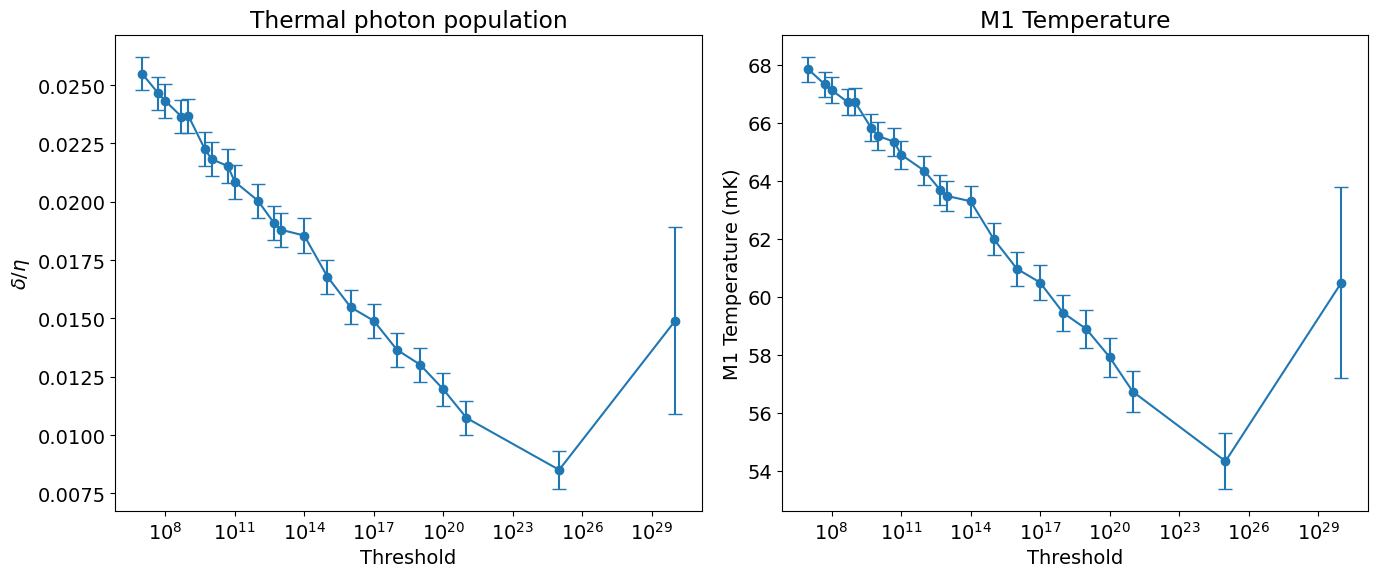

In [1101]:
start_idx = 0
end_idx =  -4

n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 +1.2

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp = 48 * frequency / (np.log(1 + 1 / now[i]))
    temp_err = np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr.append(temp)
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [1097]:
thermal_photon_population

[0.012158843612114919,
 0.011410127258896816,
 0.011244962973902402,
 0.011011518047878081,
 0.01088456573031207,
 0.009922074275150352,
 0.009848718009422571,
 0.00966627196056161,
 0.009300012433171701,
 0.008912935518440105,
 0.008604048315040538,
 0.008324952508660185,
 0.008322496749024707,
 0.007566756300418986,
 0.006948660864872159,
 0.0067499038226139264,
 0.005890076908647533,
 0.004982320797171327,
 0.0047254150702426565,
 0.003942805567431476,
 0.002809665248454684,
 0.00851063829787234,
 nan,
 nan,
 nan,
 nan]

Procedure: 

1. Load single photon in M1 and perform N = 40 repeated parity measurements (total of N = 1e5 shots). These parameters set the maximum threshold to be $\lambda_{max} \approx 10^{20}$

2. Through Hidden Markov Analysis, we find the number of photons measured $n_{meas}$ for a range of thresholds $\lambda$ . Given the equation $$n_{meas} (\lambda) = \eta_{true} (\lambda) \times 1 \text{photon injected} + \delta (\lambda) \approx \eta(\lambda)$$, we compute get efficiencies for each threshold $\eta(\lambda)$. Here we drop the false positive probability $\delta < 0.01 <<\eta_{true}$ since it is small compared to the true efficiency. 

3. To calculate mode temperature, we repeat step 1 with no injected photon. We find the thermal photons by normalizing the false positive probability $\delta$ with the efficiency $\eta(\lambda)$
$$ n_{thermal} (\lambda) = n_{meas}(\lambda) / \eta(\lambda) = \delta(\lambda) / \eta(\lambda)$$




### Use above efficiencies to calculate for all modes

In [863]:
file_no_list = np.arange(0, 8, 1)
mode_labels = ['M1', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
# threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

threshold_counts_list = []
current_running_dict = m1_running_dict
for file_no in file_no_list:
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
    aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)
    threshold_counts, current_running_dict = compute_threshold_counts(bb, full_threshold_list, current_running_dict)
    threshold_counts_list.append(threshold_counts)



Processing:   2%|▏         | 1729/107500 [00:04<04:25, 398.89it/s]


KeyboardInterrupt: 

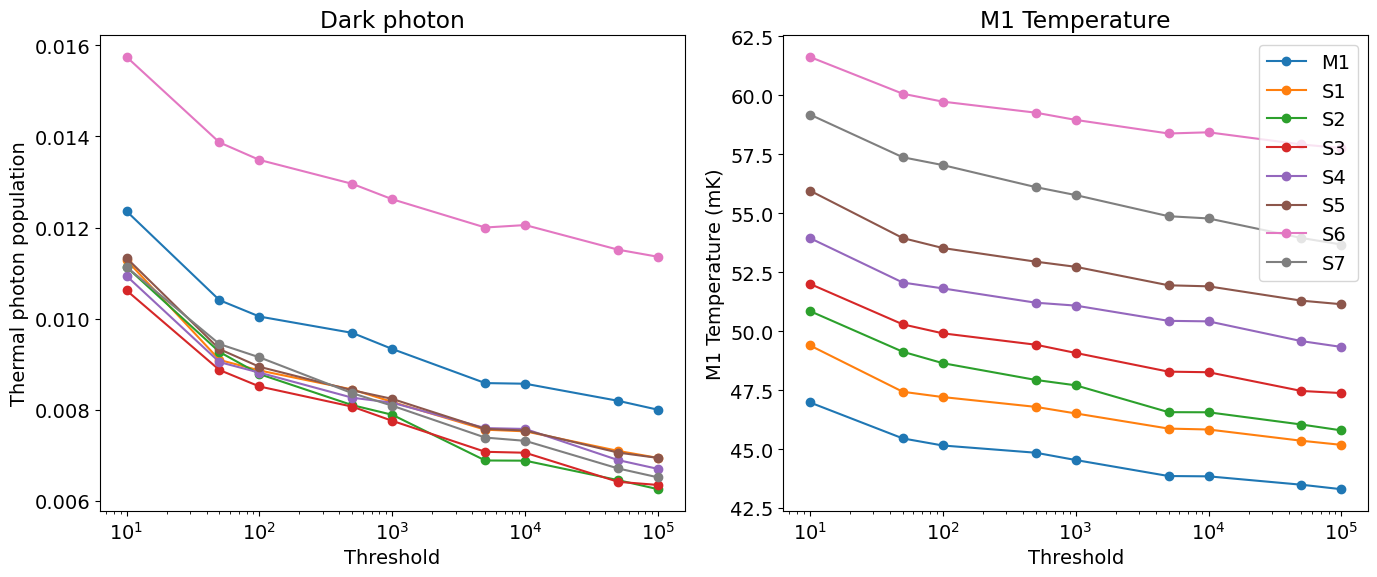

In [ ]:
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925]) * 1e-3)
# efficiency_list = np.array(efficiency_list) * 1e-5#np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, threshold_list, frequencies, mode_labels)

### Sandbox

In [735]:
temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')
# temp_data, attrs = prev_data(expt_path, '00004_cavity_temperature_sweep_parity.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)

In [736]:
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 40,
 'ramsey_freq': 0.0,
 'reps': 100000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 40}

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

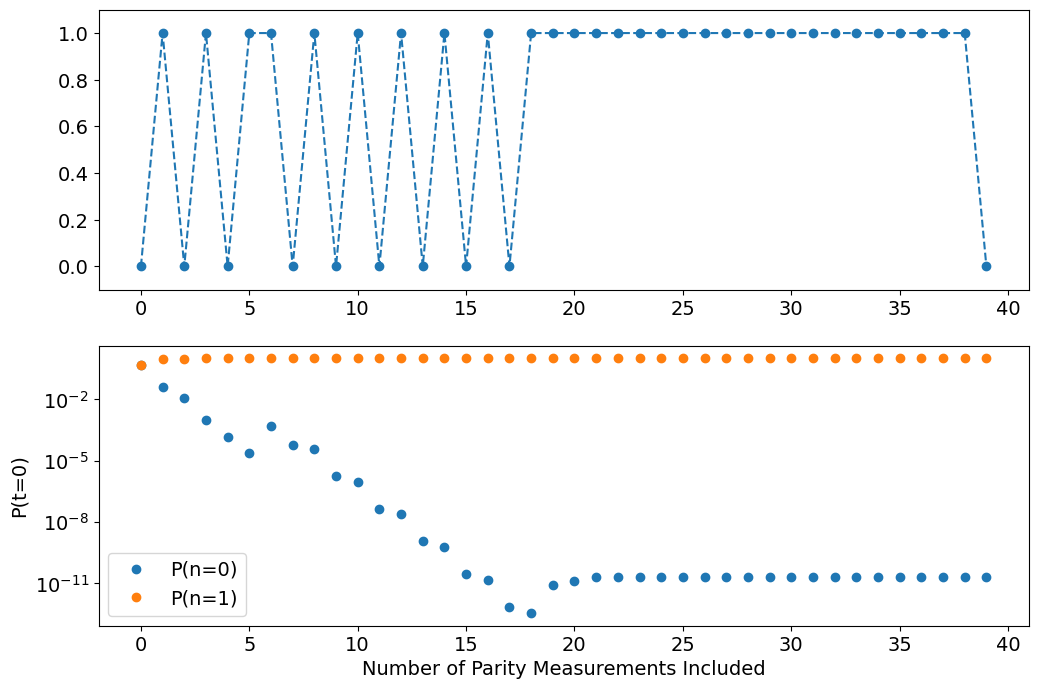

In [739]:
meas_sequence = bb[5000]

running_dict = {'meas_sequence': [], 
                'gamma_first_row': []} # stores gamma

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    gamma_first_row = wrapper_gamma(temp_meas_sequence, running_dict)
    P0 = gamma_first_row[0] + gamma_first_row[1]
    P1 = gamma_first_row[2] + gamma_first_row[3]

    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(P0)
    P1_first.append(P1)

figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [684]:
len(bb)

100000

In [689]:
from tqdm import tqdm

In [695]:

# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

threshold_counts = compute_threshold_counts(bb, threshold_list)

# print threshold counts and corresponding threshold
for jdx, threshold in enumerate(threshold_list):
    print(f'Threshold: {threshold}, Counts: {threshold_counts[jdx]}')

Processing: 100%|██████████| 107500/107500 [00:25<00:00, 4280.28it/s]

Threshold: 10, Counts: 1423
Threshold: 50, Counts: 1200
Threshold: 100, Counts: 1133
Threshold: 500, Counts: 1036
Threshold: 1000, Counts: 1010
Threshold: 5000, Counts: 915
Threshold: 10000, Counts: 894
Threshold: 50000, Counts: 790
Threshold: 100000, Counts: 753


Text(0.5, 1.0, 'Dark photon')

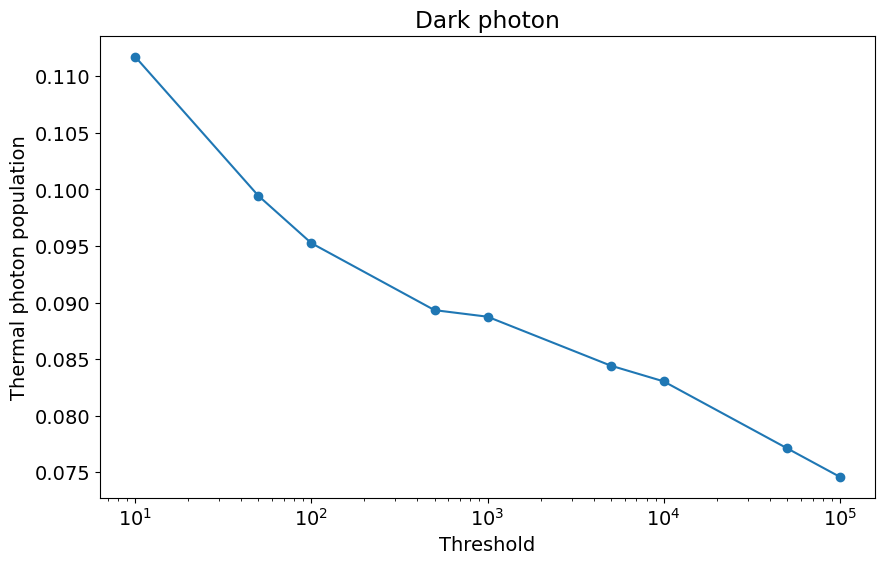

In [696]:
dark_counts = np.array(threshold_counts)/20000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[i])

plt.plot(threshold_list, thermal_photon_population, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Thermal photon population')
plt.title('Dark photon')


Text(0, 0.5, 'M1 Temperature (mK)')

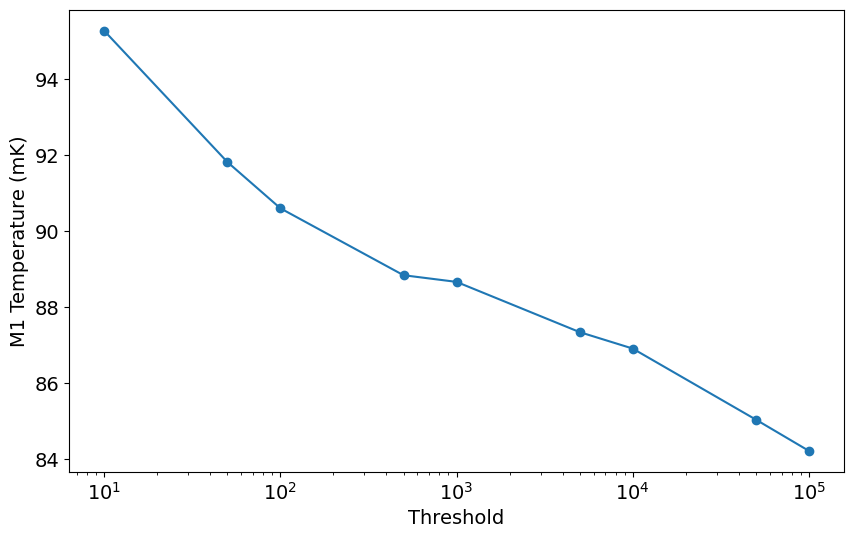

In [697]:

freq = 4.984 + 0.17 + 4* 0.17
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
plt.plot(threshold_list, tempr, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('M1 Temperature (mK)')

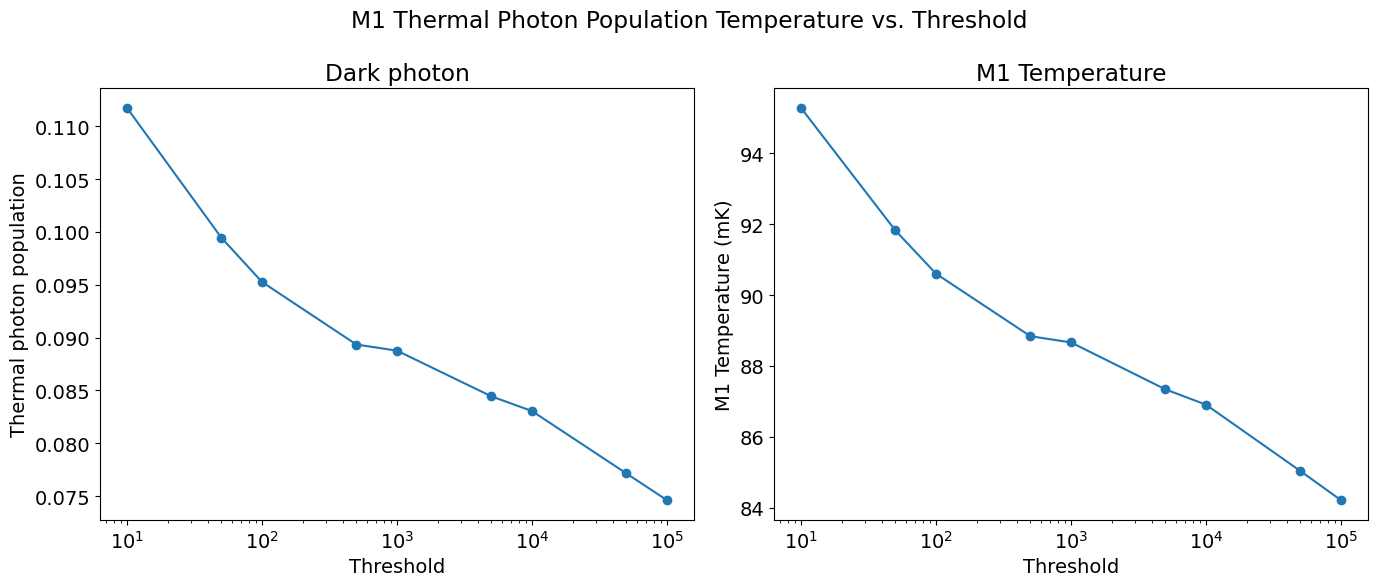

In [702]:
def plot_thermal_photon_and_temperature(threshold_counts, efficiency_list, threshold_list, frequency, mode_label='M1'):
    dark_counts = np.array(threshold_counts) / 20000

    thermal_photon_population = []
    for i in range(len(dark_counts)):
        thermal_photon_population.append(dark_counts[i] / efficiency_list[i])

    now = np.array(thermal_photon_population) / 2
    tempr = []
    for i in range(len(now)):
        tempr.append(48 * frequency / (np.log(1 + 1 / now[i])))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot thermal photon population
    ax1.plot(threshold_list, thermal_photon_population, 'o-')
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Thermal photon population')
    ax1.set_title('Dark photon')

    # Plot M1 Temperature
    ax2.plot(threshold_list, tempr, 'o-')
    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('M1 Temperature (mK)')
    ax2.set_title('M1 Temperature')

    plt.suptitle(str(mode_label) + ' Thermal Photon Population Temperature vs. Threshold')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Example usage
#threshold_counts = [100, 200, 300, 400, 500, 600, 700, 800]
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000
plot_thermal_photon_and_temperature(threshold_counts, efficiency_list, threshold_list, frequency)